### General information

<br>Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data.

Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert, hann
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from tqdm import tqdm_notebook
from itertools import product
from tsfresh.feature_extraction import feature_calculators
from joblib import Parallel, delayed
import time
import datetime
import zipfile
import gc
import os

import warnings
warnings.filterwarnings("ignore")

pd.options.display.precision = 15

In [2]:
%%time
zip_file = zipfile.ZipFile('/Users/mathvan/Documents/anaconda/Kaggle/EarthQuakes/train.csv.zip')
train = pd.read_csv(zip_file.open('train.csv'), 
                    dtype={'acoustic_data': np.int16, 
                           'time_to_failure': np.float32})

CPU times: user 1min 58s, sys: 26.1 s, total: 2min 24s
Wall time: 2min 42s


In [3]:
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [4]:
train.shape

(629145480, 2)

We have 629 million rows. Huge data, so let's plot a sample of it:

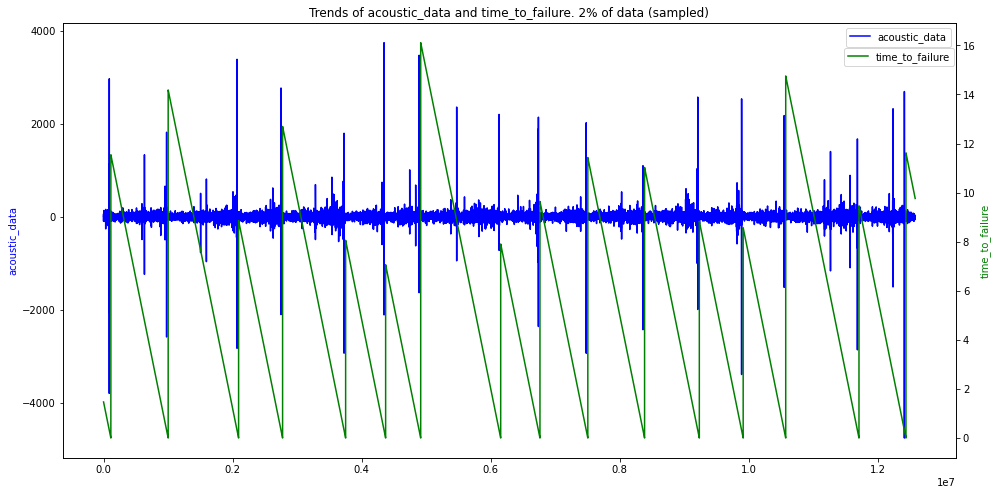

In [5]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")

plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()

plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

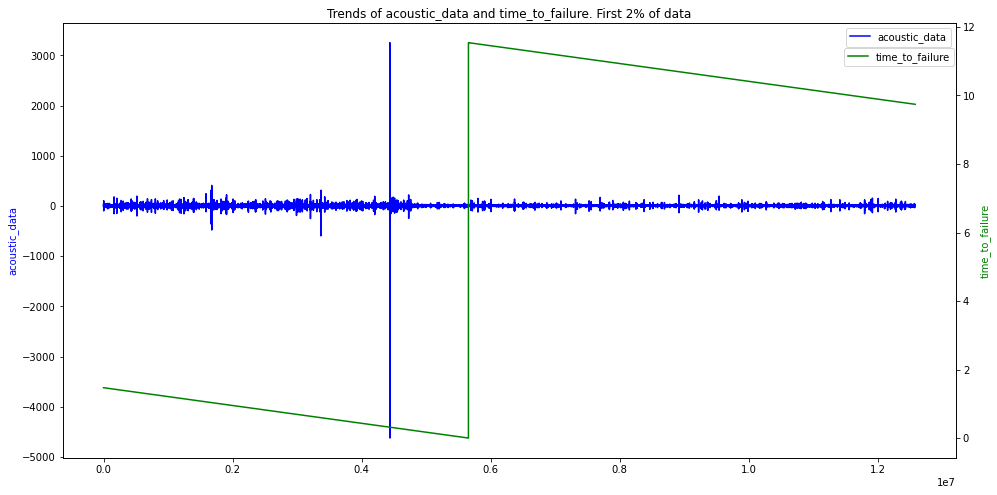

In [6]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. First 2% of data")
plt.grid(False)

plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()

plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))

On the first plot you can see 2% of all data (all data skipping each 50 rows). We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical.

On the second plot we see first 2% of the data. It seems that at first the signal has huge fluctuations for a short time, then it lowers and after some time the earthquake occurs. I think it will be quite diffucult to distinguish target values properly.

---

### Feature engineering

Let's create some new features.

Why 150000? Test segments are 150000 each. At first I create features similar to baseline kernel, but with more aggregations.

In [7]:
# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

train_X = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min',
                                'av_change_abs', 'av_change_rate', 'abs_max', 'abs_min',
                                'std_first_50000', 'std_last_50000', 'std_first_10000', 'std_last_10000',
                                'avg_first_50000', 'avg_last_50000', 'avg_first_10000', 'avg_last_10000',
                                'min_first_50000', 'min_last_50000', 'min_first_10000', 'min_last_10000',
                                'max_first_50000', 'max_last_50000', 'max_first_10000', 'max_last_10000'])
train_y = pd.DataFrame(index=range(segments), 
                       dtype=np.float64,
                       columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_max = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    train_y.loc[segment, 'time_to_failure'] = y
    train_X.loc[segment, 'ave'] = x.mean()
    train_X.loc[segment, 'std'] = x.std()
    train_X.loc[segment, 'max'] = x.max()
    train_X.loc[segment, 'min'] = x.min()
    
    
    train_X.loc[segment, 'av_change_abs'] = np.mean(np.diff(x))
    train_X.loc[segment, 'av_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    train_X.loc[segment, 'abs_max'] = np.abs(x).max()
    train_X.loc[segment, 'abs_min'] = np.abs(x).min()
    
    train_X.loc[segment, 'std_first_50000'] = x[:50000].std()
    train_X.loc[segment, 'std_last_50000'] = x[-50000:].std()
    train_X.loc[segment, 'std_first_10000'] = x[:10000].std()
    train_X.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    train_X.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    train_X.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    train_X.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    train_X.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    train_X.loc[segment, 'min_first_50000'] = x[:50000].min()
    train_X.loc[segment, 'min_last_50000'] = x[-50000:].min()
    train_X.loc[segment, 'min_first_10000'] = x[:10000].min()
    train_X.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    train_X.loc[segment, 'max_first_50000'] = x[:50000].max()
    train_X.loc[segment, 'max_last_50000'] = x[-50000:].max()
    train_X.loc[segment, 'max_first_10000'] = x[:10000].max()
    train_X.loc[segment, 'max_last_10000'] = x[-10000:].max()


In [8]:
print(f'{train_X.shape[0]} samples in new train data.')

4194 samples in new train data.


Let's see all new features:

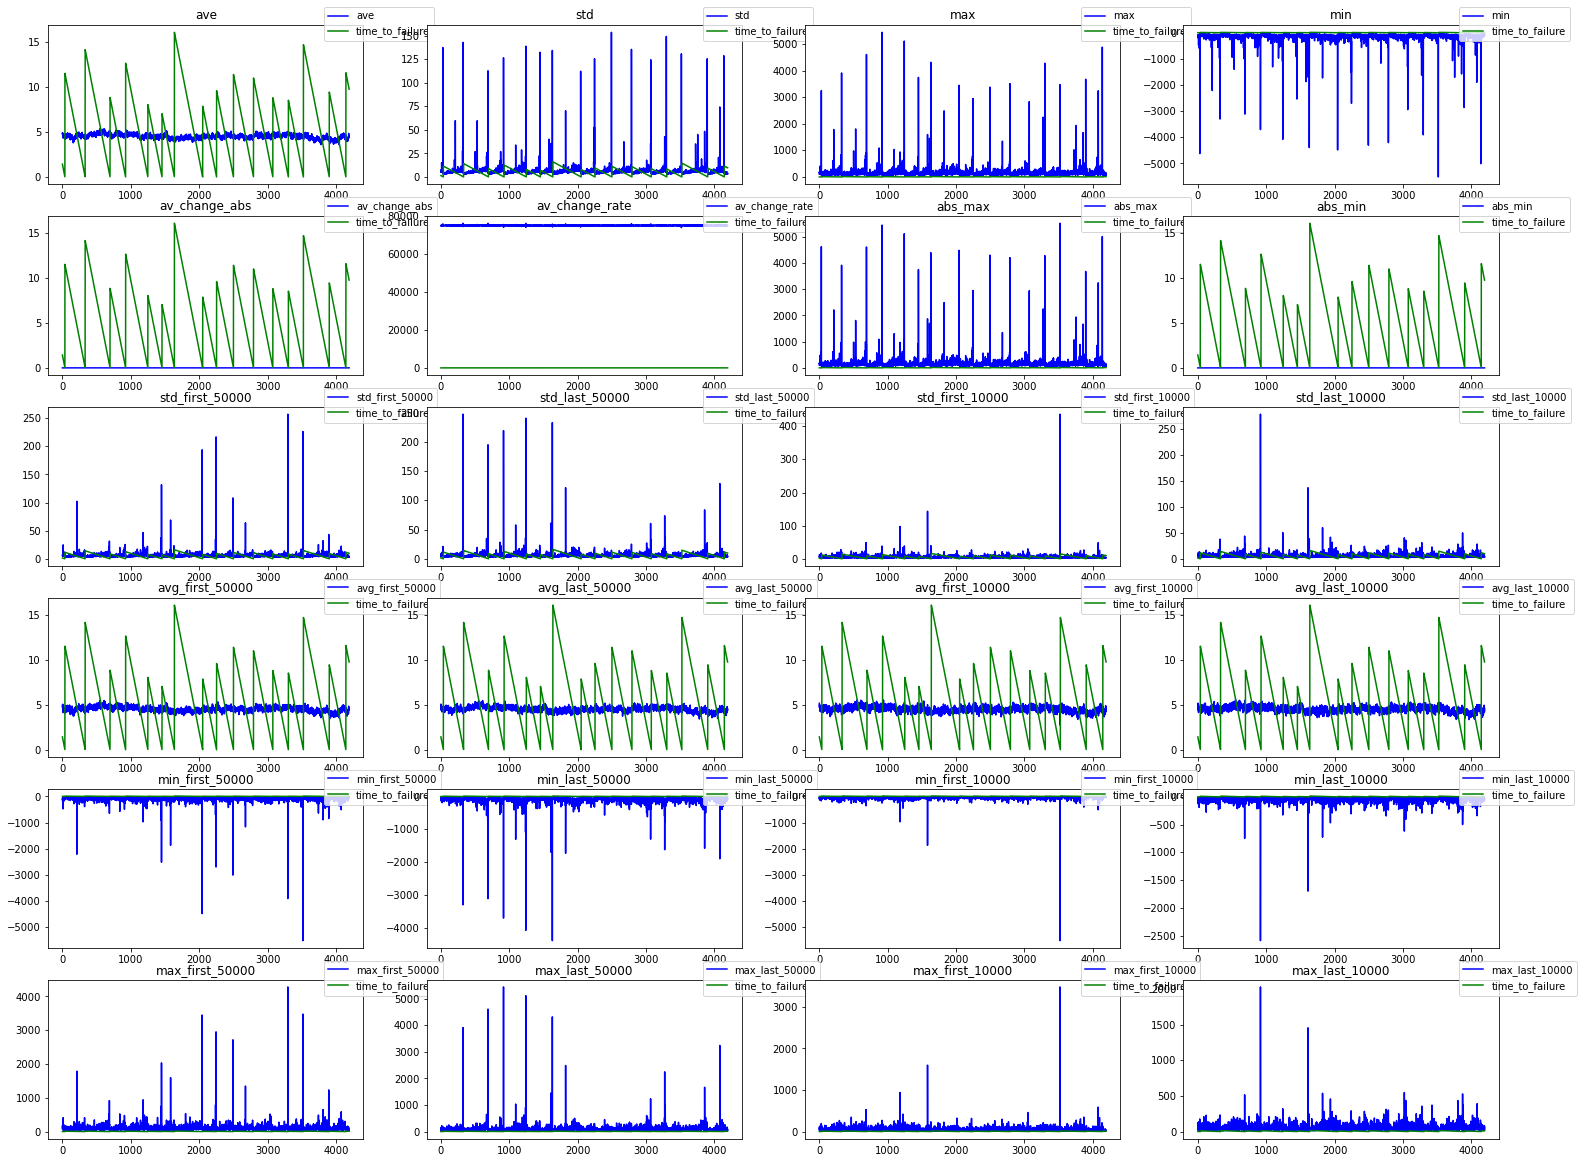

In [9]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(train_X.columns):
    plt.subplot(7, 4, i + 1)
    plt.plot(train_X[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')
    # plt.legend([col])
    ax2 = ax1.twinx()
    plt.plot(train_y, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [10]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [11]:
scaled_train_X.head(10)

,ave,std,max,min,av_change_abs,av_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000
0,1.424140499795022,-0.170213582943171,-0.218193508692627,0.193218185209325,-1.326419602086939,-1.569265388202209,-0.222566817896606,0.0,0.052067120339060,-0.285578802588458,...,2.169233854080213,0.502224097821339,-0.042512812131692,0.465851266004560,-0.563305603256716,0.406807139367380,0.011906885509013,-0.400167192506485,0.718611566927431,-0.453669501370655
1,0.805716032556442,0.004734017014316,0.063936007992510,-0.018037271219829,0.002746647790241,-1.040205647784611,0.036796505974809,0.0,0.153858292399954,-0.076987041316589,...,0.845957983265294,1.270319586552552,-0.384877683496999,-0.140002032705829,0.197633772937809,0.282558653740508,0.541182287093263,0.026976730006776,-0.316480514514776,-0.401697638798994
2,1.511155259373638,0.049252196732055,-0.086288799593083,0.163038834290874,-0.218781060522623,0.949924666794285,-0.101306043099581,0.0,0.004240793200813,0.277885119361809,...,0.532791411071448,2.128154874846584,0.024737430457921,-0.081994801978238,-0.451701161414852,-0.447401199317361,-0.036209060089555,0.179904801030043,0.622002972659492,0.741683337777560
3,1.494934375107487,0.043949637951170,0.122560323147863,-0.187796120136112,0.002746647790241,-0.634909173056099,0.097426893373321,0.0,0.020851954621430,-0.058805334800357,...,1.693272967739670,2.100493144515395,0.171465232471624,0.092026890204533,-0.056012685793699,0.096185925300201,-0.187430603399341,-0.115404577497644,0.318375962103111,-0.297753913655671
4,1.520242078970568,0.088495070341074,-0.067968701107035,0.087590456994748,-0.108017206366191,0.094279216826639,-0.084464268822216,0.0,-0.093103984672099,0.174161254562638,...,1.379779499332676,0.608046298739500,-0.030285495297217,-0.210899759150661,-0.015429252396658,-1.301609538002102,-0.063703886145880,0.116624219916967,0.069953862556981,1.313373826065837
5,1.538962489544185,-0.131053986788160,-0.078960760198664,0.019686917428235,-1.215655747930508,0.436641418028853,-0.087832623677689,0.0,-0.202997889269714,-0.116667143771301,...,0.651454736443437,-0.029460090986324,0.250942791895713,0.246712838811440,0.299092356430413,-0.059124681733388,-0.338652146709127,-0.252512503242642,-0.385486653277590,-0.055218554987917
6,1.313015726042317,-0.101218785996422,-0.159569193537274,0.268666562505451,0.556565918572399,0.808825792651953,-0.168673140209039,0.0,-0.015760036448030,-0.089102608507840,...,0.968870959408182,0.893026450756191,0.128669623550961,0.227377095235577,0.299092356430413,0.437869260774098,0.032528005051256,-0.178685158610720,-0.385486653277590,-0.505641363942317
7,-0.054824008985421,-0.081617152532347,-0.089952819290292,0.057411106076298,0.002746647790241,0.631347117732611,-0.104674397955054,0.0,-0.000132896390133,0.103848052588435,...,0.156533869740428,-0.415116075487466,0.012510113623446,-0.262461742019631,-0.431409444716331,0.437869260774098,0.005033178994932,0.174631419270620,0.580599289401804,-0.522965318132871
8,0.774732321036825,0.145943916470089,0.016303751928785,-0.025582108949441,0.224274356103104,-0.073091810876247,-0.006992107146339,0.0,0.400996086887359,-0.019941556898859,...,0.547174844449873,0.034547866407944,-0.397105000331474,-0.004651827674784,-1.040160945671951,0.437869260774098,0.451824102410208,0.116624219916967,1.105045943999189,-0.263106005274563
9,0.825998647072221,0.040204715451199,-0.042320563226568,0.087590456994748,-0.108017206366191,-0.935705767723218,-0.060885784833906,0.0,0.366676522065242,-0.139624253365394,...,-0.399843485034027,1.735422633749093,-0.213695247814345,0.208041351659713,0.228071347985590,0.344682896553944,0.341844798184909,-0.263059266761488,-0.275076831257088,-0.349725776227332


In [12]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, 
                      dtype=np.float64, 
                      index=submission.index)

In [13]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [14]:
submission.shape, test_X.shape

((2624, 1), (2624, 24))

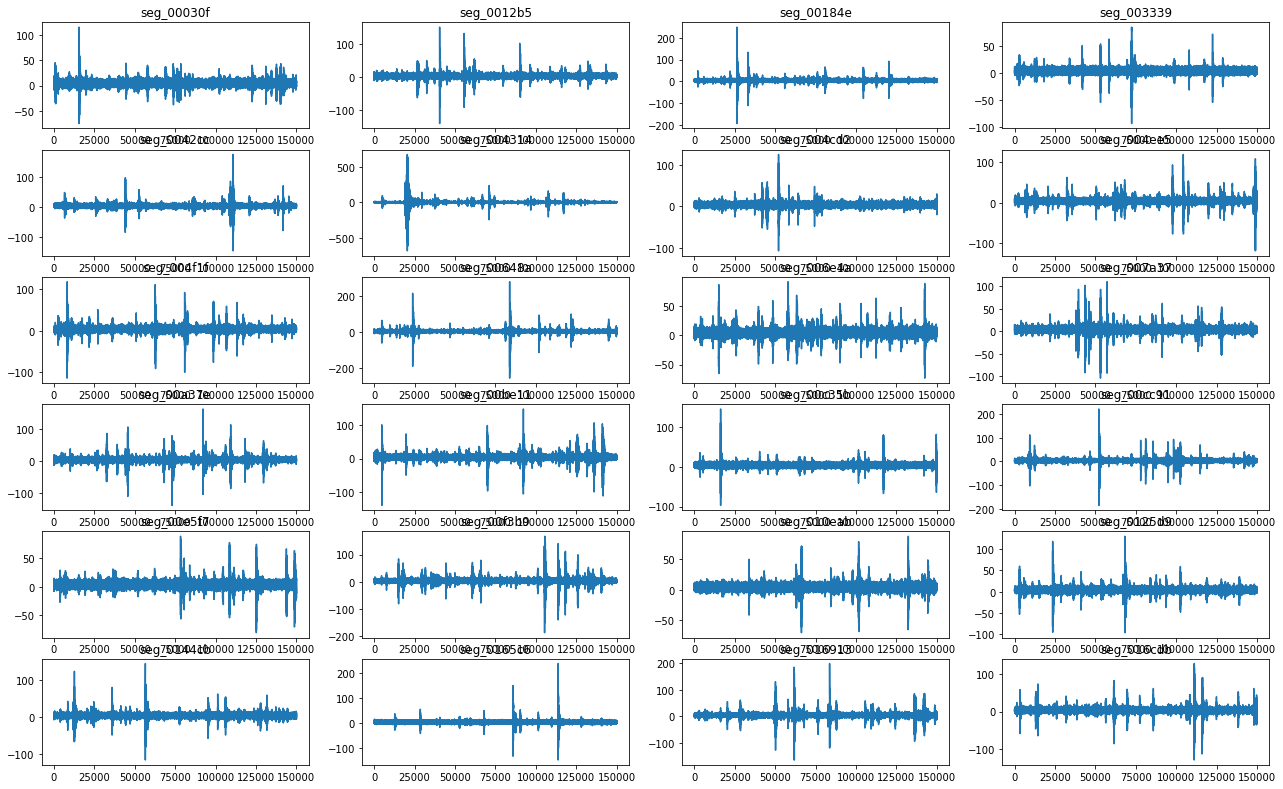

In [15]:
zip_file = zipfile.ZipFile('/Users/mathvan/Documents/anaconda/Kaggle/EarthQuakes/test.zip') 

plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(test_X.index)):
    seg = pd.read_csv(zip_file.open(seg_id + '.csv'))
    
    x = seg['acoustic_data'].values
    test_X.loc[seg_id, 'ave'] = x.mean()
    test_X.loc[seg_id, 'std'] = x.std()
    test_X.loc[seg_id, 'max'] = x.max()
    test_X.loc[seg_id, 'min'] = x.min()
        
    test_X.loc[seg_id, 'av_change_abs'] = np.mean(np.diff(x))
    test_X.loc[seg_id, 'av_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    test_X.loc[seg_id, 'abs_max'] = np.abs(x).max()
    test_X.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    test_X.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    test_X.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    test_X.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    test_X.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    test_X.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    test_X.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    test_X.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    test_X.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    test_X.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    test_X.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    test_X.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    test_X.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    test_X.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    test_X.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    test_X.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    test_X.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    if i < 24:
        plt.subplot(7, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)
    
    
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

We scale also the test data:

In [16]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), 
                             columns=test_X.columns)

In [17]:
scaled_test_X.shape

(2624, 24)

In [18]:
scaled_test_X.tail(10)

,ave,std,max,min,av_change_abs,av_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000
2614,-1.081634623438432,-0.268601942296902,-0.350098217792172,0.329025264342352,0.556565918572399,0.067458152169156,-0.343827592693630,0.0,-0.194797775810145,-0.181187014366608,...,-0.648611503238114,-1.502286407108699,0.195919866140574,0.201596103801092,-0.167617127635563,0.251496532333791,-0.263041375054234,-0.199778685648412,0.166562456824921,-0.315077867846225
2615,-0.734695164615844,-0.320940103312901,-0.390402434461477,0.400701222773672,-0.661836477148349,0.887970082254586,-0.380879496103832,0.0,-0.323533962490464,-0.274231129126028,...,-1.276579128691536,-0.165517206452531,0.324306692902564,0.343391556690758,0.288946498081152,0.034061682486766,-0.386768092307695,-0.257785885002065,-0.385486653277590,0.083373078536514
2616,-2.073321685925087,0.185999424044962,0.045615909506462,0.027231755157847,0.113510501946672,-0.237366032230119,0.019954731697444,0.0,0.306344190869034,0.331281452361380,...,-1.422374839754642,-1.714252456972128,-0.024171836879980,-0.314023724888600,0.096175189445206,0.251496532333791,0.108138776706149,0.369746544369270,-0.192269464741711,-0.419021592989548
2617,-0.427930383839279,-0.291596382506079,-0.196209390509370,0.310163170018320,0.224274356103104,0.568825376868539,-0.202356688763768,0.0,-0.210801667919105,-0.206164266538774,...,-0.792118940809200,-0.353681302310051,0.195919866140574,0.169369864507987,0.278800639731892,0.391276078664021,-0.249293962026072,0.021703348247353,-0.399287881030153,-0.488317409751763
2618,-3.374741716678421,-0.152003490043633,-0.298801942031238,0.234714792722194,0.002746647790241,-0.047520028527846,-0.279828850439645,0.0,0.026535244950846,-0.181547334067865,...,-2.558012284223770,-2.615510228925587,0.024737430457921,0.278939078104546,0.157050339540768,-0.121248924546823,-0.139314657800773,-0.263059266761488,-0.192269464741711,0.066049124345960
2619,-1.654729139621841,-0.172408272635962,-0.339106158700543,0.374294290720027,0.224274356103104,-0.236184579581601,-0.333722528127212,0.0,-0.097048178774341,-0.163937427232187,...,-2.502766824202099,-1.562434588177685,0.250942791895713,0.285384325963167,0.025154181000384,-0.105717863843465,-0.338652146709127,-0.205052067407835,-0.081859642721209,0.256612620442052
2620,-1.487885758598570,-0.060792925011241,0.001647673139947,-0.221747889919369,-0.108017206366191,-0.740492403802197,0.127742087072577,0.0,-0.286026366297055,-0.303882685189184,...,-2.279823606836542,-0.843229599566714,0.202033524557812,0.356282052408000,0.157050339540768,0.531055624994251,-0.366146972765452,-0.336886611393409,-0.192269464741711,-0.574937180704532
2621,-3.010670087956753,0.343254632011228,0.536594548932544,-0.580127682075968,0.224274356103104,-1.111938986066138,0.471314282330814,0.0,1.035622635056285,-0.005155960244568,...,-2.879024365533119,-1.572727325045103,-1.295812787665402,-0.140002032705829,-0.756076911892662,0.282558653740508,1.427890427409735,-0.078490905181683,1.422474182308132,-0.228458096893455
2622,-0.694312192710866,0.782096807867043,0.727123573187442,-0.640486383912869,0.002746647790241,1.603918810659991,0.646468734815406,0.0,0.352001246819283,0.502316164080301,...,0.346787465791388,-0.575940089040903,-0.458241584503850,-0.185118767716177,0.217925489636330,-1.130767870265153,0.568677113149588,0.169358037511197,-0.219871920246837,1.486613367971375
2623,-1.248764408517769,-0.349888468230894,-0.331778119306124,0.347887358666383,-0.329544914679054,-0.301678532603151,-0.326985818416266,0.0,-0.338573695389740,-0.336072209489055,...,-0.799637553711558,-1.161017850348305,0.342647668154277,0.491632257439044,0.075883472746685,0.515524564290892,-0.386768092307695,-0.352706756671678,-0.081859642721209,-0.609585089085640


---

### Model: RandomForestRegressor

In [19]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

train_columns = scaled_train_X.columns.values

In [20]:
params = {'criterion': 'mae',
          'max_depth': 100,
          'min_samples_split': 2,
          'min_samples_leaf': 2,
          'max_features': 15,
          'max_leaf_nodes': 15,
          'bootstrap': True,
          'verbose': 1000,
          'random_state': 42,
          'ccp_alpha': 0.005,
          'max_samples': 0.7}

In [21]:
oof_rfr = np.zeros(len(scaled_train_X))
prediction_rfr = np.zeros(len(scaled_test_X))
feature_importance_rfr = pd.DataFrame()

In [22]:
%%time
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = RandomForestRegressor(**params, n_estimators = 10000, n_jobs = -1)
    model.fit(X_tr, y_tr)
    oof_rfr[val_idx] = model.predict(X_val, 
                                     num_iteration=model.best_iteration_)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_rfr = pd.concat([feature_importance_rfr, fold_importance_df], axis=0)
    
    #predictions
    prediction_rfr += model.predict(scaled_test_X, 
                                    num_iteration=model.best_iteration_) / \
                      folds.n_splits
    
print('------------------------------')
print('------------------------------')

fold 0
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
building tree 1 of 10000building tree 2 of 10000
building tree 3 of 10000
building tree 4 of 10000

building tree 5 of 10000[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s

building tree 6 of 10000[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s

building tree 7 of 10000[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s

building tree 8 of 10000[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s

building tree 9 of 10000building tree 10 of 10000[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.9s

building tree 11 of 10000[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.0s

building tree 12 of 10000[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s

building tree 13 of 10000[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s

building tree 14 of 10000

building tree 98 of 10000[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   10.7s

building tree 99 of 10000[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   10.8s

building tree 100 of 10000[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   10.9s

building tree 101 of 10000[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   11.0s

building tree 102 of 10000[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   11.2s

building tree 103 of 10000[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed:   11.3s

building tree 104 of 10000[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:   11.3s

building tree 105 of 10000[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   11.4s

building tree 106 of 10000[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:   11.7s

building tree 107 of 10000[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:   11.7s

building tree 108 of 10000[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.8s

building tree 109 of 10

building tree 192 of 10000[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   21.9s

building tree 193 of 10000[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   22.2s

building tree 194 of 10000[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:   22.5s

building tree 195 of 10000[Parallel(n_jobs=-1)]: Done 191 tasks      | elapsed:   22.5s

building tree 196 of 10000[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.5s

building tree 197 of 10000[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:   22.7s

building tree 198 of 10000[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   22.9s

building tree 199 of 10000[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:   23.0s

building tree 200 of 10000[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   23.0s

building tree 201 of 10000[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   23.1s

building tree 202 of 10000[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:   23.4s

building tree 203 of 

building tree 285 of 10000[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:   32.3s

building tree 286 of 10000[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   32.6s

building tree 287 of 10000[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:   32.7s

building tree 288 of 10000[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   32.7s

building tree 289 of 10000
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:   32.7s
building tree 290 of 10000[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:   33.1s

building tree 291 of 10000[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed:   33.2s

building tree 292 of 10000[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   33.2s

building tree 293 of 10000[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   33.2s

building tree 294 of 10000[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   33.5s

building tree 295 of 10000[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:   33.6s

building tree 296 of 

building tree 379 of 10000[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   43.8s

building tree 380 of 10000[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   44.0s

building tree 381 of 10000[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:   44.0s

building tree 382 of 10000[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   44.1s

building tree 383 of 10000[Parallel(n_jobs=-1)]: Done 379 tasks      | elapsed:   44.2s

building tree 384 of 10000[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:   44.4s

building tree 385 of 10000[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   44.5s

building tree 386 of 10000[Parallel(n_jobs=-1)]: Done 382 tasks      | elapsed:   44.6s

building tree 387 of 10000[Parallel(n_jobs=-1)]: Done 383 tasks      | elapsed:   44.7s

building tree 388 of 10000[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   44.8s

building tree 389 of 10000[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed:   45.0s

building tree 390 of 

building tree 472 of 10000[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   54.3s

building tree 473 of 10000[Parallel(n_jobs=-1)]: Done 469 tasks      | elapsed:   54.5s

building tree 474 of 10000[Parallel(n_jobs=-1)]: Done 470 tasks      | elapsed:   54.7s

building tree 475 of 10000[Parallel(n_jobs=-1)]: Done 471 tasks      | elapsed:   54.7s

building tree 476 of 10000[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   54.8s

building tree 477 of 10000[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:   55.0s

building tree 478 of 10000[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   55.1s

building tree 479 of 10000[Parallel(n_jobs=-1)]: Done 475 tasks      | elapsed:   55.1s

building tree 480 of 10000[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:   55.2s

building tree 481 of 10000[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:   55.4s

building tree 482 of 10000[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed:   55.5s

building tree 483 of 

building tree 568 of 10000[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:  1.1min

building tree 569 of 10000[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed:  1.1min

building tree 570 of 10000[Parallel(n_jobs=-1)]: Done 566 tasks      | elapsed:  1.1min

building tree 571 of 10000[Parallel(n_jobs=-1)]: Done 567 tasks      | elapsed:  1.1min

building tree 572 of 10000[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:  1.1min

building tree 573 of 10000
[Parallel(n_jobs=-1)]: Done 569 tasks      | elapsed:  1.1min
building tree 574 of 10000[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  1.1min
building tree 575 of 10000

[Parallel(n_jobs=-1)]: Done 571 tasks      | elapsed:  1.1min
building tree 576 of 10000[Parallel(n_jobs=-1)]: Done 572 tasks      | elapsed:  1.1min

building tree 577 of 10000[Parallel(n_jobs=-1)]: Done 573 tasks      | elapsed:  1.1min

building tree 578 of 10000[Parallel(n_jobs=-1)]: Done 574 tasks      | elapsed:  1.1min

building tree 579 of 

building tree 662 of 10000[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:  1.3min

building tree 663 of 10000[Parallel(n_jobs=-1)]: Done 659 tasks      | elapsed:  1.3min

building tree 664 of 10000[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  1.3min

building tree 665 of 10000[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed:  1.3min

building tree 666 of 10000[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:  1.3min

building tree 667 of 10000[Parallel(n_jobs=-1)]: Done 663 tasks      | elapsed:  1.3min

building tree 668 of 10000[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  1.3min

building tree 669 of 10000[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed:  1.3min

building tree 670 of 10000[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:  1.3min

building tree 671 of 10000[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed:  1.3min

building tree 672 of 10000[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:  1.3min

building tree 673 of 

building tree 755 of 10000[Parallel(n_jobs=-1)]: Done 751 tasks      | elapsed:  1.5min

building tree 756 of 10000[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  1.5min

building tree 757 of 10000[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed:  1.5min

building tree 758 of 10000[Parallel(n_jobs=-1)]: Done 754 tasks      | elapsed:  1.5min

building tree 759 of 10000[Parallel(n_jobs=-1)]: Done 755 tasks      | elapsed:  1.5min

building tree 760 of 10000[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:  1.5min

building tree 761 of 10000[Parallel(n_jobs=-1)]: Done 757 tasks      | elapsed:  1.5min

building tree 762 of 10000[Parallel(n_jobs=-1)]: Done 758 tasks      | elapsed:  1.5min

building tree 763 of 10000[Parallel(n_jobs=-1)]: Done 759 tasks      | elapsed:  1.5min

building tree 764 of 10000[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  1.5min

building tree 765 of 10000[Parallel(n_jobs=-1)]: Done 761 tasks      | elapsed:  1.5min

building tree 766 of 

building tree 848 of 10000[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:  1.6min

building tree 849 of 10000[Parallel(n_jobs=-1)]: Done 845 tasks      | elapsed:  1.6min

building tree 850 of 10000[Parallel(n_jobs=-1)]: Done 846 tasks      | elapsed:  1.6min

building tree 851 of 10000[Parallel(n_jobs=-1)]: Done 847 tasks      | elapsed:  1.6min

building tree 852 of 10000[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:  1.6min

building tree 853 of 10000[Parallel(n_jobs=-1)]: Done 849 tasks      | elapsed:  1.6min

building tree 854 of 10000[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.6min

building tree 855 of 10000[Parallel(n_jobs=-1)]: Done 851 tasks      | elapsed:  1.7min

building tree 856 of 10000[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:  1.7min

building tree 857 of 10000[Parallel(n_jobs=-1)]: Done 853 tasks      | elapsed:  1.7min

building tree 858 of 10000[Parallel(n_jobs=-1)]: Done 854 tasks      | elapsed:  1.7min

building tree 859 of 


building tree 943 of 10000[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed:  1.8min

building tree 944 of 10000[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:  1.8min

building tree 945 of 10000[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed:  1.8min

building tree 946 of 10000[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  1.8min

building tree 947 of 10000[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed:  1.8min

building tree 948 of 10000[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:  1.8min

building tree 949 of 10000[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:  1.8min

building tree 950 of 10000[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:  1.8min

building tree 951 of 10000[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed:  1.8min

building tree 952 of 10000[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:  1.8min

building tree 953 of 10000[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:  1.8min

building tree 954 of

building tree 1037 of 10000[Parallel(n_jobs=-1)]: Done 1033 tasks      | elapsed:  2.0min

building tree 1038 of 10000[Parallel(n_jobs=-1)]: Done 1034 tasks      | elapsed:  2.0min

building tree 1039 of 10000[Parallel(n_jobs=-1)]: Done 1035 tasks      | elapsed:  2.0min

building tree 1040 of 10000[Parallel(n_jobs=-1)]: Done 1036 tasks      | elapsed:  2.0min

building tree 1041 of 10000[Parallel(n_jobs=-1)]: Done 1037 tasks      | elapsed:  2.0min

building tree 1042 of 10000[Parallel(n_jobs=-1)]: Done 1038 tasks      | elapsed:  2.0min

building tree 1043 of 10000[Parallel(n_jobs=-1)]: Done 1039 tasks      | elapsed:  2.0min

building tree 1044 of 10000[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:  2.0min

building tree 1045 of 10000[Parallel(n_jobs=-1)]: Done 1041 tasks      | elapsed:  2.0min

building tree 1046 of 10000[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed:  2.0min

building tree 1047 of 10000[Parallel(n_jobs=-1)]: Done 1043 tasks      | elapsed:  2.0min


building tree 1128 of 10000[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed:  2.2min

building tree 1129 of 10000[Parallel(n_jobs=-1)]: Done 1125 tasks      | elapsed:  2.2min

building tree 1130 of 10000
building tree 1131 of 10000
[Parallel(n_jobs=-1)]: Done 1126 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1127 tasks      | elapsed:  2.2min
building tree 1132 of 10000[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  2.2min

building tree 1133 of 10000[Parallel(n_jobs=-1)]: Done 1129 tasks      | elapsed:  2.2min

building tree 1134 of 10000[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:  2.2min

building tree 1135 of 10000[Parallel(n_jobs=-1)]: Done 1131 tasks      | elapsed:  2.2min

building tree 1136 of 10000[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:  2.2min

building tree 1137 of 10000[Parallel(n_jobs=-1)]: Done 1133 tasks      | elapsed:  2.2min

building tree 1138 of 10000[Parallel(n_jobs=-1)]: Done 1134 tasks      | elapsed:  2.2min


building tree 1221 of 10000[Parallel(n_jobs=-1)]: Done 1217 tasks      | elapsed:  2.4min

building tree 1222 of 10000[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.4min

building tree 1223 of 10000[Parallel(n_jobs=-1)]: Done 1219 tasks      | elapsed:  2.4min

building tree 1224 of 10000[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:  2.4min

building tree 1225 of 10000[Parallel(n_jobs=-1)]: Done 1221 tasks      | elapsed:  2.4min

building tree 1226 of 10000[Parallel(n_jobs=-1)]: Done 1222 tasks      | elapsed:  2.4min

building tree 1227 of 10000[Parallel(n_jobs=-1)]: Done 1223 tasks      | elapsed:  2.4min

building tree 1228 of 10000[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:  2.4min

building tree 1229 of 10000[Parallel(n_jobs=-1)]: Done 1225 tasks      | elapsed:  2.4min

building tree 1230 of 10000[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.4min

building tree 1231 of 10000[Parallel(n_jobs=-1)]: Done 1227 tasks      | elapsed:  2.4min


building tree 1312 of 10000[Parallel(n_jobs=-1)]: Done 1308 tasks      | elapsed:  2.5min

building tree 1313 of 10000[Parallel(n_jobs=-1)]: Done 1309 tasks      | elapsed:  2.5min

building tree 1314 of 10000[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:  2.5min

building tree 1315 of 10000[Parallel(n_jobs=-1)]: Done 1311 tasks      | elapsed:  2.5min

building tree 1316 of 10000[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:  2.5min

building tree 1317 of 10000[Parallel(n_jobs=-1)]: Done 1313 tasks      | elapsed:  2.5min

building tree 1318 of 10000[Parallel(n_jobs=-1)]: Done 1314 tasks      | elapsed:  2.5min

building tree 1319 of 10000[Parallel(n_jobs=-1)]: Done 1315 tasks      | elapsed:  2.5min

building tree 1320 of 10000[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:  2.5min

building tree 1321 of 10000[Parallel(n_jobs=-1)]: Done 1317 tasks      | elapsed:  2.5min

building tree 1322 of 10000[Parallel(n_jobs=-1)]: Done 1318 tasks      | elapsed:  2.5min


building tree 1403 of 10000[Parallel(n_jobs=-1)]: Done 1399 tasks      | elapsed:  2.7min

building tree 1404 of 10000[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:  2.7min

building tree 1405 of 10000[Parallel(n_jobs=-1)]: Done 1401 tasks      | elapsed:  2.7min

building tree 1406 of 10000
[Parallel(n_jobs=-1)]: Done 1402 tasks      | elapsed:  2.7min
building tree 1407 of 10000[Parallel(n_jobs=-1)]: Done 1403 tasks      | elapsed:  2.7min

building tree 1408 of 10000[Parallel(n_jobs=-1)]: Done 1404 tasks      | elapsed:  2.7min

building tree 1409 of 10000[Parallel(n_jobs=-1)]: Done 1405 tasks      | elapsed:  2.7min

building tree 1410 of 10000[Parallel(n_jobs=-1)]: Done 1406 tasks      | elapsed:  2.7min

building tree 1411 of 10000[Parallel(n_jobs=-1)]: Done 1407 tasks      | elapsed:  2.7min

building tree 1412 of 10000[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed:  2.7min

building tree 1413 of 10000[Parallel(n_jobs=-1)]: Done 1409 tasks      | elapsed:  2.7min


building tree 1494 of 10000[Parallel(n_jobs=-1)]: Done 1490 tasks      | elapsed:  2.9min

building tree 1495 of 10000[Parallel(n_jobs=-1)]: Done 1491 tasks      | elapsed:  2.9min

building tree 1496 of 10000[Parallel(n_jobs=-1)]: Done 1492 tasks      | elapsed:  2.9min

building tree 1497 of 10000[Parallel(n_jobs=-1)]: Done 1493 tasks      | elapsed:  2.9min

building tree 1498 of 10000[Parallel(n_jobs=-1)]: Done 1494 tasks      | elapsed:  2.9min

building tree 1499 of 10000[Parallel(n_jobs=-1)]: Done 1495 tasks      | elapsed:  2.9min

building tree 1500 of 10000[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:  2.9min

building tree 1501 of 10000[Parallel(n_jobs=-1)]: Done 1497 tasks      | elapsed:  2.9min

building tree 1502 of 10000[Parallel(n_jobs=-1)]: Done 1498 tasks      | elapsed:  2.9min

building tree 1503 of 10000[Parallel(n_jobs=-1)]: Done 1499 tasks      | elapsed:  2.9min

building tree 1504 of 10000[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:  2.9min


building tree 1585 of 10000[Parallel(n_jobs=-1)]: Done 1581 tasks      | elapsed:  3.1min

building tree 1586 of 10000[Parallel(n_jobs=-1)]: Done 1582 tasks      | elapsed:  3.1min

building tree 1587 of 10000[Parallel(n_jobs=-1)]: Done 1583 tasks      | elapsed:  3.1min

building tree 1588 of 10000[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:  3.1min

building tree 1589 of 10000[Parallel(n_jobs=-1)]: Done 1585 tasks      | elapsed:  3.1min

building tree 1590 of 10000[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed:  3.1min

building tree 1591 of 10000[Parallel(n_jobs=-1)]: Done 1587 tasks      | elapsed:  3.1min

building tree 1592 of 10000[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  3.1min

building tree 1593 of 10000[Parallel(n_jobs=-1)]: Done 1589 tasks      | elapsed:  3.1min

building tree 1594 of 10000[Parallel(n_jobs=-1)]: Done 1590 tasks      | elapsed:  3.1min

building tree 1595 of 10000[Parallel(n_jobs=-1)]: Done 1591 tasks      | elapsed:  3.1min


building tree 1676 of 10000[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:  3.2min

building tree 1677 of 10000[Parallel(n_jobs=-1)]: Done 1673 tasks      | elapsed:  3.2min

building tree 1678 of 10000[Parallel(n_jobs=-1)]: Done 1674 tasks      | elapsed:  3.2min

building tree 1679 of 10000[Parallel(n_jobs=-1)]: Done 1675 tasks      | elapsed:  3.2min

building tree 1680 of 10000[Parallel(n_jobs=-1)]: Done 1676 tasks      | elapsed:  3.2min

building tree 1681 of 10000[Parallel(n_jobs=-1)]: Done 1677 tasks      | elapsed:  3.2min

building tree 1682 of 10000[Parallel(n_jobs=-1)]: Done 1678 tasks      | elapsed:  3.2min

building tree 1683 of 10000[Parallel(n_jobs=-1)]: Done 1679 tasks      | elapsed:  3.2min

building tree 1684 of 10000[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:  3.2min

building tree 1685 of 10000[Parallel(n_jobs=-1)]: Done 1681 tasks      | elapsed:  3.2min

building tree 1686 of 10000[Parallel(n_jobs=-1)]: Done 1682 tasks      | elapsed:  3.2min


building tree 1768 of 10000[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:  3.4min

building tree 1769 of 10000[Parallel(n_jobs=-1)]: Done 1765 tasks      | elapsed:  3.4min

building tree 1770 of 10000[Parallel(n_jobs=-1)]: Done 1766 tasks      | elapsed:  3.4min

building tree 1771 of 10000[Parallel(n_jobs=-1)]: Done 1767 tasks      | elapsed:  3.4min

building tree 1772 of 10000[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  3.4min

building tree 1773 of 10000[Parallel(n_jobs=-1)]: Done 1769 tasks      | elapsed:  3.4min

building tree 1774 of 10000[Parallel(n_jobs=-1)]: Done 1770 tasks      | elapsed:  3.4min

building tree 1775 of 10000[Parallel(n_jobs=-1)]: Done 1771 tasks      | elapsed:  3.4min

building tree 1776 of 10000[Parallel(n_jobs=-1)]: Done 1772 tasks      | elapsed:  3.4min

building tree 1777 of 10000[Parallel(n_jobs=-1)]: Done 1773 tasks      | elapsed:  3.4min

building tree 1778 of 10000[Parallel(n_jobs=-1)]: Done 1774 tasks      | elapsed:  3.4min


building tree 1859 of 10000[Parallel(n_jobs=-1)]: Done 1855 tasks      | elapsed:  3.6min

building tree 1860 of 10000[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed:  3.6min

building tree 1861 of 10000[Parallel(n_jobs=-1)]: Done 1857 tasks      | elapsed:  3.6min

building tree 1862 of 10000[Parallel(n_jobs=-1)]: Done 1858 tasks      | elapsed:  3.6min

building tree 1863 of 10000[Parallel(n_jobs=-1)]: Done 1859 tasks      | elapsed:  3.6min

building tree 1864 of 10000[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:  3.6min

building tree 1865 of 10000[Parallel(n_jobs=-1)]: Done 1861 tasks      | elapsed:  3.6min

building tree 1866 of 10000[Parallel(n_jobs=-1)]: Done 1862 tasks      | elapsed:  3.6min

building tree 1867 of 10000[Parallel(n_jobs=-1)]: Done 1863 tasks      | elapsed:  3.6min

building tree 1868 of 10000[Parallel(n_jobs=-1)]: Done 1864 tasks      | elapsed:  3.6min

building tree 1869 of 10000[Parallel(n_jobs=-1)]: Done 1865 tasks      | elapsed:  3.6min


building tree 1951 of 10000[Parallel(n_jobs=-1)]: Done 1947 tasks      | elapsed:  3.7min

building tree 1952 of 10000[Parallel(n_jobs=-1)]: Done 1948 tasks      | elapsed:  3.7min

building tree 1953 of 10000[Parallel(n_jobs=-1)]: Done 1949 tasks      | elapsed:  3.7min

building tree 1954 of 10000[Parallel(n_jobs=-1)]: Done 1950 tasks      | elapsed:  3.8min

building tree 1955 of 10000[Parallel(n_jobs=-1)]: Done 1951 tasks      | elapsed:  3.8min

building tree 1956 of 10000[Parallel(n_jobs=-1)]: Done 1952 tasks      | elapsed:  3.8min

building tree 1957 of 10000[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  3.8min

building tree 1958 of 10000[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:  3.8min

building tree 1959 of 10000[Parallel(n_jobs=-1)]: Done 1955 tasks      | elapsed:  3.8min

building tree 1960 of 10000[Parallel(n_jobs=-1)]: Done 1956 tasks      | elapsed:  3.8min

building tree 1961 of 10000[Parallel(n_jobs=-1)]: Done 1957 tasks      | elapsed:  3.8min


building tree 2042 of 10000[Parallel(n_jobs=-1)]: Done 2038 tasks      | elapsed:  3.9min


building tree 2043 of 10000[Parallel(n_jobs=-1)]: Done 2039 tasks      | elapsed:  3.9min

building tree 2044 of 10000[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:  3.9min

building tree 2045 of 10000[Parallel(n_jobs=-1)]: Done 2041 tasks      | elapsed:  3.9min

building tree 2046 of 10000[Parallel(n_jobs=-1)]: Done 2042 tasks      | elapsed:  3.9min

building tree 2047 of 10000[Parallel(n_jobs=-1)]: Done 2043 tasks      | elapsed:  3.9min

building tree 2048 of 10000[Parallel(n_jobs=-1)]: Done 2044 tasks      | elapsed:  3.9min

building tree 2049 of 10000[Parallel(n_jobs=-1)]: Done 2045 tasks      | elapsed:  3.9min

building tree 2050 of 10000[Parallel(n_jobs=-1)]: Done 2046 tasks      | elapsed:  3.9min

building tree 2051 of 10000[Parallel(n_jobs=-1)]: Done 2047 tasks      | elapsed:  3.9min

building tree 2052 of 10000[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:  3.9min

building tree 2136 of 10000[Parallel(n_jobs=-1)]: Done 2132 tasks      | elapsed:  4.1min

building tree 2137 of 10000[Parallel(n_jobs=-1)]: Done 2133 tasks      | elapsed:  4.1min

building tree 2138 of 10000[Parallel(n_jobs=-1)]: Done 2134 tasks      | elapsed:  4.1min

building tree 2139 of 10000[Parallel(n_jobs=-1)]: Done 2135 tasks      | elapsed:  4.1min

building tree 2140 of 10000
[Parallel(n_jobs=-1)]: Done 2136 tasks      | elapsed:  4.1min
building tree 2141 of 10000[Parallel(n_jobs=-1)]: Done 2137 tasks      | elapsed:  4.1min

building tree 2142 of 10000[Parallel(n_jobs=-1)]: Done 2138 tasks      | elapsed:  4.1min

building tree 2143 of 10000[Parallel(n_jobs=-1)]: Done 2139 tasks      | elapsed:  4.1min

building tree 2144 of 10000[Parallel(n_jobs=-1)]: Done 2140 tasks      | elapsed:  4.1min

building tree 2145 of 10000
[Parallel(n_jobs=-1)]: Done 2141 tasks      | elapsed:  4.1min
building tree 2146 of 10000[Parallel(n_jobs=-1)]: Done 2142 tasks      | elapsed:  4.1min


building tree 2227 of 10000[Parallel(n_jobs=-1)]: Done 2223 tasks      | elapsed:  4.3min

building tree 2228 of 10000[Parallel(n_jobs=-1)]: Done 2224 tasks      | elapsed:  4.3min

building tree 2229 of 10000[Parallel(n_jobs=-1)]: Done 2225 tasks      | elapsed:  4.3min

building tree 2230 of 10000[Parallel(n_jobs=-1)]: Done 2226 tasks      | elapsed:  4.3min

building tree 2231 of 10000[Parallel(n_jobs=-1)]: Done 2227 tasks      | elapsed:  4.3min

building tree 2232 of 10000[Parallel(n_jobs=-1)]: Done 2228 tasks      | elapsed:  4.3min

building tree 2233 of 10000[Parallel(n_jobs=-1)]: Done 2229 tasks      | elapsed:  4.3min

building tree 2234 of 10000[Parallel(n_jobs=-1)]: Done 2230 tasks      | elapsed:  4.3min

building tree 2235 of 10000[Parallel(n_jobs=-1)]: Done 2231 tasks      | elapsed:  4.3min

building tree 2236 of 10000[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:  4.3min

building tree 2237 of 10000[Parallel(n_jobs=-1)]: Done 2233 tasks      | elapsed:  4.3min


building tree 2318 of 10000[Parallel(n_jobs=-1)]: Done 2314 tasks      | elapsed:  4.4min

building tree 2319 of 10000[Parallel(n_jobs=-1)]: Done 2315 tasks      | elapsed:  4.4min

building tree 2320 of 10000[Parallel(n_jobs=-1)]: Done 2316 tasks      | elapsed:  4.4min

building tree 2321 of 10000[Parallel(n_jobs=-1)]: Done 2317 tasks      | elapsed:  4.4min

building tree 2322 of 10000[Parallel(n_jobs=-1)]: Done 2318 tasks      | elapsed:  4.4min

building tree 2323 of 10000[Parallel(n_jobs=-1)]: Done 2319 tasks      | elapsed:  4.4min

building tree 2324 of 10000[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:  4.4min

building tree 2325 of 10000[Parallel(n_jobs=-1)]: Done 2321 tasks      | elapsed:  4.4min

building tree 2326 of 10000[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed:  4.4min

building tree 2327 of 10000[Parallel(n_jobs=-1)]: Done 2323 tasks      | elapsed:  4.4min

building tree 2328 of 10000[Parallel(n_jobs=-1)]: Done 2324 tasks      | elapsed:  4.4min


building tree 2409 of 10000[Parallel(n_jobs=-1)]: Done 2405 tasks      | elapsed:  4.6min

building tree 2410 of 10000[Parallel(n_jobs=-1)]: Done 2406 tasks      | elapsed:  4.6min

building tree 2411 of 10000[Parallel(n_jobs=-1)]: Done 2407 tasks      | elapsed:  4.6min

building tree 2412 of 10000[Parallel(n_jobs=-1)]: Done 2408 tasks      | elapsed:  4.6min

building tree 2413 of 10000[Parallel(n_jobs=-1)]: Done 2409 tasks      | elapsed:  4.6min

building tree 2414 of 10000[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:  4.6min

building tree 2415 of 10000[Parallel(n_jobs=-1)]: Done 2411 tasks      | elapsed:  4.6min

building tree 2416 of 10000[Parallel(n_jobs=-1)]: Done 2412 tasks      | elapsed:  4.6min

building tree 2417 of 10000[Parallel(n_jobs=-1)]: Done 2413 tasks      | elapsed:  4.6min

building tree 2418 of 10000[Parallel(n_jobs=-1)]: Done 2414 tasks      | elapsed:  4.6min

building tree 2419 of 10000[Parallel(n_jobs=-1)]: Done 2415 tasks      | elapsed:  4.6min


building tree 2503 of 10000[Parallel(n_jobs=-1)]: Done 2499 tasks      | elapsed:  4.8min

building tree 2504 of 10000[Parallel(n_jobs=-1)]: Done 2500 tasks      | elapsed:  4.8min

building tree 2505 of 10000[Parallel(n_jobs=-1)]: Done 2501 tasks      | elapsed:  4.8min

building tree 2506 of 10000[Parallel(n_jobs=-1)]: Done 2502 tasks      | elapsed:  4.8min

building tree 2507 of 10000[Parallel(n_jobs=-1)]: Done 2503 tasks      | elapsed:  4.8min

building tree 2508 of 10000[Parallel(n_jobs=-1)]: Done 2504 tasks      | elapsed:  4.8min

building tree 2509 of 10000[Parallel(n_jobs=-1)]: Done 2505 tasks      | elapsed:  4.8min

building tree 2510 of 10000[Parallel(n_jobs=-1)]: Done 2506 tasks      | elapsed:  4.8min

building tree 2511 of 10000[Parallel(n_jobs=-1)]: Done 2507 tasks      | elapsed:  4.8min

building tree 2512 of 10000[Parallel(n_jobs=-1)]: Done 2508 tasks      | elapsed:  4.8min

building tree 2513 of 10000[Parallel(n_jobs=-1)]: Done 2509 tasks      | elapsed:  4.8min


building tree 2595 of 10000[Parallel(n_jobs=-1)]: Done 2591 tasks      | elapsed:  5.0min

building tree 2596 of 10000[Parallel(n_jobs=-1)]: Done 2592 tasks      | elapsed:  5.0min

building tree 2597 of 10000[Parallel(n_jobs=-1)]: Done 2593 tasks      | elapsed:  5.0min

building tree 2598 of 10000[Parallel(n_jobs=-1)]: Done 2594 tasks      | elapsed:  5.0min

building tree 2599 of 10000[Parallel(n_jobs=-1)]: Done 2595 tasks      | elapsed:  5.0min

building tree 2600 of 10000[Parallel(n_jobs=-1)]: Done 2596 tasks      | elapsed:  5.0min

building tree 2601 of 10000[Parallel(n_jobs=-1)]: Done 2597 tasks      | elapsed:  5.0min

building tree 2602 of 10000[Parallel(n_jobs=-1)]: Done 2598 tasks      | elapsed:  5.0min

building tree 2603 of 10000[Parallel(n_jobs=-1)]: Done 2599 tasks      | elapsed:  5.0min

building tree 2604 of 10000[Parallel(n_jobs=-1)]: Done 2600 tasks      | elapsed:  5.0min

building tree 2605 of 10000[Parallel(n_jobs=-1)]: Done 2601 tasks      | elapsed:  5.0min


building tree 2687 of 10000[Parallel(n_jobs=-1)]: Done 2683 tasks      | elapsed:  5.1min

building tree 2688 of 10000[Parallel(n_jobs=-1)]: Done 2684 tasks      | elapsed:  5.1min

building tree 2689 of 10000[Parallel(n_jobs=-1)]: Done 2685 tasks      | elapsed:  5.1min

building tree 2690 of 10000[Parallel(n_jobs=-1)]: Done 2686 tasks      | elapsed:  5.1min

building tree 2691 of 10000[Parallel(n_jobs=-1)]: Done 2687 tasks      | elapsed:  5.2min

building tree 2692 of 10000[Parallel(n_jobs=-1)]: Done 2688 tasks      | elapsed:  5.2min

building tree 2693 of 10000[Parallel(n_jobs=-1)]: Done 2689 tasks      | elapsed:  5.2min

building tree 2694 of 10000[Parallel(n_jobs=-1)]: Done 2690 tasks      | elapsed:  5.2min

building tree 2695 of 10000[Parallel(n_jobs=-1)]: Done 2691 tasks      | elapsed:  5.2min

building tree 2696 of 10000[Parallel(n_jobs=-1)]: Done 2692 tasks      | elapsed:  5.2min

building tree 2697 of 10000[Parallel(n_jobs=-1)]: Done 2693 tasks      | elapsed:  5.2min


building tree 2778 of 10000[Parallel(n_jobs=-1)]: Done 2774 tasks      | elapsed:  5.3min

building tree 2779 of 10000[Parallel(n_jobs=-1)]: Done 2775 tasks      | elapsed:  5.3min

building tree 2780 of 10000[Parallel(n_jobs=-1)]: Done 2776 tasks      | elapsed:  5.3min

building tree 2781 of 10000[Parallel(n_jobs=-1)]: Done 2777 tasks      | elapsed:  5.3min

building tree 2782 of 10000[Parallel(n_jobs=-1)]: Done 2778 tasks      | elapsed:  5.3min

building tree 2783 of 10000[Parallel(n_jobs=-1)]: Done 2779 tasks      | elapsed:  5.3min

building tree 2784 of 10000[Parallel(n_jobs=-1)]: Done 2780 tasks      | elapsed:  5.3min

building tree 2785 of 10000
[Parallel(n_jobs=-1)]: Done 2781 tasks      | elapsed:  5.3min
building tree 2786 of 10000[Parallel(n_jobs=-1)]: Done 2782 tasks      | elapsed:  5.3min

building tree 2787 of 10000[Parallel(n_jobs=-1)]: Done 2783 tasks      | elapsed:  5.3min

building tree 2788 of 10000[Parallel(n_jobs=-1)]: Done 2784 tasks      | elapsed:  5.3min


building tree 2869 of 10000[Parallel(n_jobs=-1)]: Done 2865 tasks      | elapsed:  5.5min

building tree 2870 of 10000[Parallel(n_jobs=-1)]: Done 2866 tasks      | elapsed:  5.5min

building tree 2871 of 10000[Parallel(n_jobs=-1)]: Done 2867 tasks      | elapsed:  5.5min

building tree 2872 of 10000[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:  5.5min

building tree 2873 of 10000[Parallel(n_jobs=-1)]: Done 2869 tasks      | elapsed:  5.6min

building tree 2874 of 10000[Parallel(n_jobs=-1)]: Done 2870 tasks      | elapsed:  5.6min

building tree 2875 of 10000[Parallel(n_jobs=-1)]: Done 2871 tasks      | elapsed:  5.6min

building tree 2876 of 10000[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed:  5.6min

building tree 2877 of 10000[Parallel(n_jobs=-1)]: Done 2873 tasks      | elapsed:  5.6min

building tree 2878 of 10000[Parallel(n_jobs=-1)]: Done 2874 tasks      | elapsed:  5.6min

building tree 2879 of 10000[Parallel(n_jobs=-1)]: Done 2875 tasks      | elapsed:  5.6min


building tree 2960 of 10000
[Parallel(n_jobs=-1)]: Done 2956 tasks      | elapsed:  5.8min
building tree 2961 of 10000[Parallel(n_jobs=-1)]: Done 2957 tasks      | elapsed:  5.8min

building tree 2962 of 10000[Parallel(n_jobs=-1)]: Done 2958 tasks      | elapsed:  5.8min

building tree 2963 of 10000[Parallel(n_jobs=-1)]: Done 2959 tasks      | elapsed:  5.8min

building tree 2964 of 10000[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:  5.8min

building tree 2965 of 10000[Parallel(n_jobs=-1)]: Done 2961 tasks      | elapsed:  5.8min

building tree 2966 of 10000[Parallel(n_jobs=-1)]: Done 2962 tasks      | elapsed:  5.8min

building tree 2967 of 10000[Parallel(n_jobs=-1)]: Done 2963 tasks      | elapsed:  5.8min

building tree 2968 of 10000[Parallel(n_jobs=-1)]: Done 2964 tasks      | elapsed:  5.8min

building tree 2969 of 10000[Parallel(n_jobs=-1)]: Done 2965 tasks      | elapsed:  5.8min

building tree 2970 of 10000[Parallel(n_jobs=-1)]: Done 2966 tasks      | elapsed:  5.8min


building tree 3051 of 10000[Parallel(n_jobs=-1)]: Done 3047 tasks      | elapsed:  6.0min

building tree 3052 of 10000[Parallel(n_jobs=-1)]: Done 3048 tasks      | elapsed:  6.0min

building tree 3053 of 10000[Parallel(n_jobs=-1)]: Done 3049 tasks      | elapsed:  6.0min

building tree 3054 of 10000[Parallel(n_jobs=-1)]: Done 3050 tasks      | elapsed:  6.0min

building tree 3055 of 10000[Parallel(n_jobs=-1)]: Done 3051 tasks      | elapsed:  6.0min

building tree 3056 of 10000[Parallel(n_jobs=-1)]: Done 3052 tasks      | elapsed:  6.0min

building tree 3057 of 10000[Parallel(n_jobs=-1)]: Done 3053 tasks      | elapsed:  6.0min

building tree 3058 of 10000[Parallel(n_jobs=-1)]: Done 3054 tasks      | elapsed:  6.0min

building tree 3059 of 10000[Parallel(n_jobs=-1)]: Done 3055 tasks      | elapsed:  6.0min

building tree 3060 of 10000[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:  6.0min

building tree 3061 of 10000[Parallel(n_jobs=-1)]: Done 3057 tasks      | elapsed:  6.0min


building tree 3144 of 10000[Parallel(n_jobs=-1)]: Done 3140 tasks      | elapsed:  6.1min

building tree 3145 of 10000[Parallel(n_jobs=-1)]: Done 3141 tasks      | elapsed:  6.1min

building tree 3146 of 10000[Parallel(n_jobs=-1)]: Done 3142 tasks      | elapsed:  6.1min

building tree 3147 of 10000[Parallel(n_jobs=-1)]: Done 3143 tasks      | elapsed:  6.1min

building tree 3148 of 10000[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:  6.1min

building tree 3149 of 10000[Parallel(n_jobs=-1)]: Done 3145 tasks      | elapsed:  6.1min

building tree 3150 of 10000[Parallel(n_jobs=-1)]: Done 3146 tasks      | elapsed:  6.1min

building tree 3151 of 10000[Parallel(n_jobs=-1)]: Done 3147 tasks      | elapsed:  6.1min

building tree 3152 of 10000[Parallel(n_jobs=-1)]: Done 3148 tasks      | elapsed:  6.1min

building tree 3153 of 10000[Parallel(n_jobs=-1)]: Done 3149 tasks      | elapsed:  6.2min

building tree 3154 of 10000[Parallel(n_jobs=-1)]: Done 3150 tasks      | elapsed:  6.2min


building tree 3237 of 10000[Parallel(n_jobs=-1)]: Done 3233 tasks      | elapsed:  6.3min

building tree 3238 of 10000[Parallel(n_jobs=-1)]: Done 3234 tasks      | elapsed:  6.3min

building tree 3239 of 10000[Parallel(n_jobs=-1)]: Done 3235 tasks      | elapsed:  6.3min

building tree 3240 of 10000[Parallel(n_jobs=-1)]: Done 3236 tasks      | elapsed:  6.3min

building tree 3241 of 10000[Parallel(n_jobs=-1)]: Done 3237 tasks      | elapsed:  6.3min

building tree 3242 of 10000[Parallel(n_jobs=-1)]: Done 3238 tasks      | elapsed:  6.3min

building tree 3243 of 10000[Parallel(n_jobs=-1)]: Done 3239 tasks      | elapsed:  6.3min

building tree 3244 of 10000[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed:  6.3min

building tree 3245 of 10000[Parallel(n_jobs=-1)]: Done 3241 tasks      | elapsed:  6.3min

building tree 3246 of 10000[Parallel(n_jobs=-1)]: Done 3242 tasks      | elapsed:  6.3min

building tree 3247 of 10000[Parallel(n_jobs=-1)]: Done 3243 tasks      | elapsed:  6.3min


building tree 3330 of 10000[Parallel(n_jobs=-1)]: Done 3326 tasks      | elapsed:  6.5min

building tree 3331 of 10000[Parallel(n_jobs=-1)]: Done 3327 tasks      | elapsed:  6.5min

building tree 3332 of 10000[Parallel(n_jobs=-1)]: Done 3328 tasks      | elapsed:  6.5min

building tree 3333 of 10000[Parallel(n_jobs=-1)]: Done 3329 tasks      | elapsed:  6.5min

building tree 3334 of 10000[Parallel(n_jobs=-1)]: Done 3330 tasks      | elapsed:  6.5min

building tree 3335 of 10000[Parallel(n_jobs=-1)]: Done 3331 tasks      | elapsed:  6.5min

building tree 3336 of 10000[Parallel(n_jobs=-1)]: Done 3332 tasks      | elapsed:  6.5min

building tree 3337 of 10000[Parallel(n_jobs=-1)]: Done 3333 tasks      | elapsed:  6.5min

building tree 3338 of 10000[Parallel(n_jobs=-1)]: Done 3334 tasks      | elapsed:  6.5min

building tree 3339 of 10000[Parallel(n_jobs=-1)]: Done 3335 tasks      | elapsed:  6.5min

building tree 3340 of 10000[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:  6.5min


building tree 3421 of 10000[Parallel(n_jobs=-1)]: Done 3417 tasks      | elapsed:  6.6min

building tree 3422 of 10000[Parallel(n_jobs=-1)]: Done 3418 tasks      | elapsed:  6.6min

building tree 3423 of 10000[Parallel(n_jobs=-1)]: Done 3419 tasks      | elapsed:  6.6min

building tree 3424 of 10000[Parallel(n_jobs=-1)]: Done 3420 tasks      | elapsed:  6.6min

building tree 3425 of 10000[Parallel(n_jobs=-1)]: Done 3421 tasks      | elapsed:  6.6min

building tree 3426 of 10000[Parallel(n_jobs=-1)]: Done 3422 tasks      | elapsed:  6.6min

building tree 3427 of 10000[Parallel(n_jobs=-1)]: Done 3423 tasks      | elapsed:  6.6min

building tree 3428 of 10000[Parallel(n_jobs=-1)]: Done 3424 tasks      | elapsed:  6.6min

building tree 3429 of 10000[Parallel(n_jobs=-1)]: Done 3425 tasks      | elapsed:  6.6min

building tree 3430 of 10000[Parallel(n_jobs=-1)]: Done 3426 tasks      | elapsed:  6.6min

building tree 3431 of 10000[Parallel(n_jobs=-1)]: Done 3427 tasks      | elapsed:  6.6min


building tree 3514 of 10000[Parallel(n_jobs=-1)]: Done 3510 tasks      | elapsed:  6.8min

building tree 3515 of 10000[Parallel(n_jobs=-1)]: Done 3511 tasks      | elapsed:  6.8min

building tree 3516 of 10000[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  6.8min

building tree 3517 of 10000[Parallel(n_jobs=-1)]: Done 3513 tasks      | elapsed:  6.8min

building tree 3518 of 10000[Parallel(n_jobs=-1)]: Done 3514 tasks      | elapsed:  6.8min

building tree 3519 of 10000[Parallel(n_jobs=-1)]: Done 3515 tasks      | elapsed:  6.8min

building tree 3520 of 10000[Parallel(n_jobs=-1)]: Done 3516 tasks      | elapsed:  6.8min

building tree 3521 of 10000[Parallel(n_jobs=-1)]: Done 3517 tasks      | elapsed:  6.8min

building tree 3522 of 10000[Parallel(n_jobs=-1)]: Done 3518 tasks      | elapsed:  6.8min

building tree 3523 of 10000[Parallel(n_jobs=-1)]: Done 3519 tasks      | elapsed:  6.8min

building tree 3524 of 10000[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:  6.8min


building tree 3606 of 10000[Parallel(n_jobs=-1)]: Done 3602 tasks      | elapsed:  7.0min

building tree 3607 of 10000[Parallel(n_jobs=-1)]: Done 3603 tasks      | elapsed:  7.0min

building tree 3608 of 10000
[Parallel(n_jobs=-1)]: Done 3604 tasks      | elapsed:  7.0min
building tree 3609 of 10000[Parallel(n_jobs=-1)]: Done 3605 tasks      | elapsed:  7.0min

building tree 3610 of 10000[Parallel(n_jobs=-1)]: Done 3606 tasks      | elapsed:  7.0min

building tree 3611 of 10000[Parallel(n_jobs=-1)]: Done 3607 tasks      | elapsed:  7.0min

building tree 3612 of 10000[Parallel(n_jobs=-1)]: Done 3608 tasks      | elapsed:  7.0min

building tree 3613 of 10000[Parallel(n_jobs=-1)]: Done 3609 tasks      | elapsed:  7.0min

building tree 3614 of 10000[Parallel(n_jobs=-1)]: Done 3610 tasks      | elapsed:  7.0min

building tree 3615 of 10000[Parallel(n_jobs=-1)]: Done 3611 tasks      | elapsed:  7.0min

building tree 3616 of 10000[Parallel(n_jobs=-1)]: Done 3612 tasks      | elapsed:  7.0min


building tree 3697 of 10000[Parallel(n_jobs=-1)]: Done 3693 tasks      | elapsed:  7.1min

building tree 3698 of 10000[Parallel(n_jobs=-1)]: Done 3694 tasks      | elapsed:  7.1min

building tree 3699 of 10000[Parallel(n_jobs=-1)]: Done 3695 tasks      | elapsed:  7.1min

building tree 3700 of 10000[Parallel(n_jobs=-1)]: Done 3696 tasks      | elapsed:  7.1min

building tree 3701 of 10000[Parallel(n_jobs=-1)]: Done 3697 tasks      | elapsed:  7.1min

building tree 3702 of 10000[Parallel(n_jobs=-1)]: Done 3698 tasks      | elapsed:  7.1min

building tree 3703 of 10000[Parallel(n_jobs=-1)]: Done 3699 tasks      | elapsed:  7.1min

building tree 3704 of 10000[Parallel(n_jobs=-1)]: Done 3700 tasks      | elapsed:  7.1min

building tree 3705 of 10000[Parallel(n_jobs=-1)]: Done 3701 tasks      | elapsed:  7.1min

building tree 3706 of 10000[Parallel(n_jobs=-1)]: Done 3702 tasks      | elapsed:  7.1min

building tree 3707 of 10000[Parallel(n_jobs=-1)]: Done 3703 tasks      | elapsed:  7.1min


building tree 3789 of 10000[Parallel(n_jobs=-1)]: Done 3785 tasks      | elapsed:  7.3min

building tree 3790 of 10000[Parallel(n_jobs=-1)]: Done 3786 tasks      | elapsed:  7.3min

building tree 3791 of 10000[Parallel(n_jobs=-1)]: Done 3787 tasks      | elapsed:  7.3min

building tree 3792 of 10000
[Parallel(n_jobs=-1)]: Done 3788 tasks      | elapsed:  7.3min
building tree 3793 of 10000[Parallel(n_jobs=-1)]: Done 3789 tasks      | elapsed:  7.3min

building tree 3794 of 10000[Parallel(n_jobs=-1)]: Done 3790 tasks      | elapsed:  7.3min

building tree 3795 of 10000[Parallel(n_jobs=-1)]: Done 3791 tasks      | elapsed:  7.3min

building tree 3796 of 10000
[Parallel(n_jobs=-1)]: Done 3792 tasks      | elapsed:  7.3min
building tree 3797 of 10000[Parallel(n_jobs=-1)]: Done 3793 tasks      | elapsed:  7.3min

building tree 3798 of 10000[Parallel(n_jobs=-1)]: Done 3794 tasks      | elapsed:  7.3min

building tree 3799 of 10000[Parallel(n_jobs=-1)]: Done 3795 tasks      | elapsed:  7.3min


building tree 3881 of 10000[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  7.4min

building tree 3882 of 10000[Parallel(n_jobs=-1)]: Done 3878 tasks      | elapsed:  7.4min

building tree 3883 of 10000[Parallel(n_jobs=-1)]: Done 3879 tasks      | elapsed:  7.4min

building tree 3884 of 10000[Parallel(n_jobs=-1)]: Done 3880 tasks      | elapsed:  7.4min

building tree 3885 of 10000[Parallel(n_jobs=-1)]: Done 3881 tasks      | elapsed:  7.4min

building tree 3886 of 10000[Parallel(n_jobs=-1)]: Done 3882 tasks      | elapsed:  7.4min

building tree 3887 of 10000[Parallel(n_jobs=-1)]: Done 3883 tasks      | elapsed:  7.4min

building tree 3888 of 10000[Parallel(n_jobs=-1)]: Done 3884 tasks      | elapsed:  7.4min

building tree 3889 of 10000[Parallel(n_jobs=-1)]: Done 3885 tasks      | elapsed:  7.4min

building tree 3890 of 10000[Parallel(n_jobs=-1)]: Done 3886 tasks      | elapsed:  7.4min

building tree 3891 of 10000[Parallel(n_jobs=-1)]: Done 3887 tasks      | elapsed:  7.4min


building tree 3972 of 10000[Parallel(n_jobs=-1)]: Done 3968 tasks      | elapsed:  7.6min

building tree 3973 of 10000[Parallel(n_jobs=-1)]: Done 3969 tasks      | elapsed:  7.6min

building tree 3974 of 10000[Parallel(n_jobs=-1)]: Done 3970 tasks      | elapsed:  7.6min

building tree 3975 of 10000[Parallel(n_jobs=-1)]: Done 3971 tasks      | elapsed:  7.6min

building tree 3976 of 10000[Parallel(n_jobs=-1)]: Done 3972 tasks      | elapsed:  7.6min

building tree 3977 of 10000[Parallel(n_jobs=-1)]: Done 3973 tasks      | elapsed:  7.6min

building tree 3978 of 10000[Parallel(n_jobs=-1)]: Done 3974 tasks      | elapsed:  7.6min

building tree 3979 of 10000[Parallel(n_jobs=-1)]: Done 3975 tasks      | elapsed:  7.6min

building tree 3980 of 10000[Parallel(n_jobs=-1)]: Done 3976 tasks      | elapsed:  7.6min

building tree 3981 of 10000[Parallel(n_jobs=-1)]: Done 3977 tasks      | elapsed:  7.6min

building tree 3982 of 10000[Parallel(n_jobs=-1)]: Done 3978 tasks      | elapsed:  7.6min


building tree 4064 of 10000[Parallel(n_jobs=-1)]: Done 4060 tasks      | elapsed:  7.7min

building tree 4065 of 10000[Parallel(n_jobs=-1)]: Done 4061 tasks      | elapsed:  7.8min

building tree 4066 of 10000[Parallel(n_jobs=-1)]: Done 4062 tasks      | elapsed:  7.8min

building tree 4067 of 10000[Parallel(n_jobs=-1)]: Done 4063 tasks      | elapsed:  7.8min

building tree 4068 of 10000[Parallel(n_jobs=-1)]: Done 4064 tasks      | elapsed:  7.8min

building tree 4069 of 10000[Parallel(n_jobs=-1)]: Done 4065 tasks      | elapsed:  7.8min

building tree 4070 of 10000[Parallel(n_jobs=-1)]: Done 4066 tasks      | elapsed:  7.8min

building tree 4071 of 10000[Parallel(n_jobs=-1)]: Done 4067 tasks      | elapsed:  7.8min

building tree 4072 of 10000[Parallel(n_jobs=-1)]: Done 4068 tasks      | elapsed:  7.8min

building tree 4073 of 10000[Parallel(n_jobs=-1)]: Done 4069 tasks      | elapsed:  7.8min

building tree 4074 of 10000[Parallel(n_jobs=-1)]: Done 4070 tasks      | elapsed:  7.8min


building tree 4155 of 10000[Parallel(n_jobs=-1)]: Done 4151 tasks      | elapsed:  7.9min

building tree 4156 of 10000[Parallel(n_jobs=-1)]: Done 4152 tasks      | elapsed:  7.9min

building tree 4157 of 10000[Parallel(n_jobs=-1)]: Done 4153 tasks      | elapsed:  7.9min

building tree 4158 of 10000[Parallel(n_jobs=-1)]: Done 4154 tasks      | elapsed:  7.9min

building tree 4159 of 10000[Parallel(n_jobs=-1)]: Done 4155 tasks      | elapsed:  7.9min

building tree 4160 of 10000[Parallel(n_jobs=-1)]: Done 4156 tasks      | elapsed:  7.9min

building tree 4161 of 10000[Parallel(n_jobs=-1)]: Done 4157 tasks      | elapsed:  7.9min

building tree 4162 of 10000[Parallel(n_jobs=-1)]: Done 4158 tasks      | elapsed:  7.9min

building tree 4163 of 10000[Parallel(n_jobs=-1)]: Done 4159 tasks      | elapsed:  7.9min

building tree 4164 of 10000[Parallel(n_jobs=-1)]: Done 4160 tasks      | elapsed:  7.9min

building tree 4165 of 10000[Parallel(n_jobs=-1)]: Done 4161 tasks      | elapsed:  7.9min


building tree 4247 of 10000[Parallel(n_jobs=-1)]: Done 4243 tasks      | elapsed:  8.1min

building tree 4248 of 10000[Parallel(n_jobs=-1)]: Done 4244 tasks      | elapsed:  8.1min

building tree 4249 of 10000[Parallel(n_jobs=-1)]: Done 4245 tasks      | elapsed:  8.1min

building tree 4250 of 10000[Parallel(n_jobs=-1)]: Done 4246 tasks      | elapsed:  8.1min

building tree 4251 of 10000[Parallel(n_jobs=-1)]: Done 4247 tasks      | elapsed:  8.1min

building tree 4252 of 10000[Parallel(n_jobs=-1)]: Done 4248 tasks      | elapsed:  8.1min

building tree 4253 of 10000[Parallel(n_jobs=-1)]: Done 4249 tasks      | elapsed:  8.1min

building tree 4254 of 10000[Parallel(n_jobs=-1)]: Done 4250 tasks      | elapsed:  8.1min

building tree 4255 of 10000[Parallel(n_jobs=-1)]: Done 4251 tasks      | elapsed:  8.1min

building tree 4256 of 10000[Parallel(n_jobs=-1)]: Done 4252 tasks      | elapsed:  8.1min

building tree 4257 of 10000[Parallel(n_jobs=-1)]: Done 4253 tasks      | elapsed:  8.1min


building tree 4340 of 10000
[Parallel(n_jobs=-1)]: Done 4336 tasks      | elapsed:  8.2min
building tree 4341 of 10000[Parallel(n_jobs=-1)]: Done 4337 tasks      | elapsed:  8.2min

building tree 4342 of 10000[Parallel(n_jobs=-1)]: Done 4338 tasks      | elapsed:  8.2min

building tree 4343 of 10000[Parallel(n_jobs=-1)]: Done 4339 tasks      | elapsed:  8.2min

building tree 4344 of 10000[Parallel(n_jobs=-1)]: Done 4340 tasks      | elapsed:  8.2min

building tree 4345 of 10000[Parallel(n_jobs=-1)]: Done 4341 tasks      | elapsed:  8.2min

building tree 4346 of 10000[Parallel(n_jobs=-1)]: Done 4342 tasks      | elapsed:  8.2min

building tree 4347 of 10000[Parallel(n_jobs=-1)]: Done 4343 tasks      | elapsed:  8.2min

building tree 4348 of 10000[Parallel(n_jobs=-1)]: Done 4344 tasks      | elapsed:  8.2min

building tree 4349 of 10000[Parallel(n_jobs=-1)]: Done 4345 tasks      | elapsed:  8.2min

building tree 4350 of 10000[Parallel(n_jobs=-1)]: Done 4346 tasks      | elapsed:  8.2min


building tree 4432 of 10000[Parallel(n_jobs=-1)]: Done 4428 tasks      | elapsed:  8.4min

building tree 4433 of 10000[Parallel(n_jobs=-1)]: Done 4429 tasks      | elapsed:  8.4min

building tree 4434 of 10000[Parallel(n_jobs=-1)]: Done 4430 tasks      | elapsed:  8.4min

building tree 4435 of 10000[Parallel(n_jobs=-1)]: Done 4431 tasks      | elapsed:  8.4min

building tree 4436 of 10000[Parallel(n_jobs=-1)]: Done 4432 tasks      | elapsed:  8.4min

building tree 4437 of 10000[Parallel(n_jobs=-1)]: Done 4433 tasks      | elapsed:  8.4min

building tree 4438 of 10000[Parallel(n_jobs=-1)]: Done 4434 tasks      | elapsed:  8.4min

building tree 4439 of 10000[Parallel(n_jobs=-1)]: Done 4435 tasks      | elapsed:  8.4min

building tree 4440 of 10000[Parallel(n_jobs=-1)]: Done 4436 tasks      | elapsed:  8.4min

building tree 4441 of 10000[Parallel(n_jobs=-1)]: Done 4437 tasks      | elapsed:  8.4min

building tree 4442 of 10000[Parallel(n_jobs=-1)]: Done 4438 tasks      | elapsed:  8.4min


building tree 4526 of 10000[Parallel(n_jobs=-1)]: Done 4522 tasks      | elapsed:  8.5min

building tree 4527 of 10000[Parallel(n_jobs=-1)]: Done 4523 tasks      | elapsed:  8.5min

building tree 4528 of 10000[Parallel(n_jobs=-1)]: Done 4524 tasks      | elapsed:  8.5min

building tree 4529 of 10000[Parallel(n_jobs=-1)]: Done 4525 tasks      | elapsed:  8.5min

building tree 4530 of 10000[Parallel(n_jobs=-1)]: Done 4526 tasks      | elapsed:  8.6min

building tree 4531 of 10000[Parallel(n_jobs=-1)]: Done 4527 tasks      | elapsed:  8.6min

building tree 4532 of 10000[Parallel(n_jobs=-1)]: Done 4528 tasks      | elapsed:  8.6min

building tree 4533 of 10000[Parallel(n_jobs=-1)]: Done 4529 tasks      | elapsed:  8.6min

building tree 4534 of 10000[Parallel(n_jobs=-1)]: Done 4530 tasks      | elapsed:  8.6min

building tree 4535 of 10000[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  8.6min

building tree 4536 of 10000[Parallel(n_jobs=-1)]: Done 4532 tasks      | elapsed:  8.6min


building tree 4619 of 10000[Parallel(n_jobs=-1)]: Done 4615 tasks      | elapsed:  8.7min

building tree 4620 of 10000[Parallel(n_jobs=-1)]: Done 4616 tasks      | elapsed:  8.7min

building tree 4621 of 10000[Parallel(n_jobs=-1)]: Done 4617 tasks      | elapsed:  8.7min

building tree 4622 of 10000[Parallel(n_jobs=-1)]: Done 4618 tasks      | elapsed:  8.7min

building tree 4623 of 10000[Parallel(n_jobs=-1)]: Done 4619 tasks      | elapsed:  8.7min

building tree 4624 of 10000[Parallel(n_jobs=-1)]: Done 4620 tasks      | elapsed:  8.7min

building tree 4625 of 10000[Parallel(n_jobs=-1)]: Done 4621 tasks      | elapsed:  8.7min

building tree 4626 of 10000[Parallel(n_jobs=-1)]: Done 4622 tasks      | elapsed:  8.7min

building tree 4627 of 10000[Parallel(n_jobs=-1)]: Done 4623 tasks      | elapsed:  8.7min

building tree 4628 of 10000[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:  8.7min

building tree 4629 of 10000[Parallel(n_jobs=-1)]: Done 4625 tasks      | elapsed:  8.7min


building tree 4712 of 10000[Parallel(n_jobs=-1)]: Done 4708 tasks      | elapsed:  8.9min

building tree 4713 of 10000[Parallel(n_jobs=-1)]: Done 4709 tasks      | elapsed:  8.9min

building tree 4714 of 10000[Parallel(n_jobs=-1)]: Done 4710 tasks      | elapsed:  8.9min

building tree 4715 of 10000[Parallel(n_jobs=-1)]: Done 4711 tasks      | elapsed:  8.9min

building tree 4716 of 10000[Parallel(n_jobs=-1)]: Done 4712 tasks      | elapsed:  8.9min

building tree 4717 of 10000[Parallel(n_jobs=-1)]: Done 4713 tasks      | elapsed:  8.9min

building tree 4718 of 10000[Parallel(n_jobs=-1)]: Done 4714 tasks      | elapsed:  8.9min

building tree 4719 of 10000[Parallel(n_jobs=-1)]: Done 4715 tasks      | elapsed:  8.9min

building tree 4720 of 10000[Parallel(n_jobs=-1)]: Done 4716 tasks      | elapsed:  8.9min

building tree 4721 of 10000[Parallel(n_jobs=-1)]: Done 4717 tasks      | elapsed:  8.9min

building tree 4722 of 10000[Parallel(n_jobs=-1)]: Done 4718 tasks      | elapsed:  8.9min


building tree 4803 of 10000[Parallel(n_jobs=-1)]: Done 4799 tasks      | elapsed:  9.0min

building tree 4804 of 10000[Parallel(n_jobs=-1)]: Done 4800 tasks      | elapsed:  9.0min

building tree 4805 of 10000[Parallel(n_jobs=-1)]: Done 4801 tasks      | elapsed:  9.0min

building tree 4806 of 10000[Parallel(n_jobs=-1)]: Done 4802 tasks      | elapsed:  9.0min

building tree 4807 of 10000[Parallel(n_jobs=-1)]: Done 4803 tasks      | elapsed:  9.0min

building tree 4808 of 10000[Parallel(n_jobs=-1)]: Done 4804 tasks      | elapsed:  9.0min

building tree 4809 of 10000[Parallel(n_jobs=-1)]: Done 4805 tasks      | elapsed:  9.0min

building tree 4810 of 10000[Parallel(n_jobs=-1)]: Done 4806 tasks      | elapsed:  9.0min

building tree 4811 of 10000[Parallel(n_jobs=-1)]: Done 4807 tasks      | elapsed:  9.0min

building tree 4812 of 10000[Parallel(n_jobs=-1)]: Done 4808 tasks      | elapsed:  9.0min

building tree 4813 of 10000[Parallel(n_jobs=-1)]: Done 4809 tasks      | elapsed:  9.0min


building tree 4894 of 10000[Parallel(n_jobs=-1)]: Done 4890 tasks      | elapsed:  9.2min

building tree 4895 of 10000[Parallel(n_jobs=-1)]: Done 4891 tasks      | elapsed:  9.2min

building tree 4896 of 10000[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  9.2min

building tree 4897 of 10000[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed:  9.2min

building tree 4898 of 10000[Parallel(n_jobs=-1)]: Done 4894 tasks      | elapsed:  9.2min

building tree 4899 of 10000[Parallel(n_jobs=-1)]: Done 4895 tasks      | elapsed:  9.2min

building tree 4900 of 10000[Parallel(n_jobs=-1)]: Done 4896 tasks      | elapsed:  9.2min

building tree 4901 of 10000[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed:  9.2min

building tree 4902 of 10000[Parallel(n_jobs=-1)]: Done 4898 tasks      | elapsed:  9.2min

building tree 4903 of 10000[Parallel(n_jobs=-1)]: Done 4899 tasks      | elapsed:  9.2min

building tree 4904 of 10000[Parallel(n_jobs=-1)]: Done 4900 tasks      | elapsed:  9.2min


building tree 4987 of 10000[Parallel(n_jobs=-1)]: Done 4983 tasks      | elapsed:  9.4min

building tree 4988 of 10000[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  9.4min

building tree 4989 of 10000[Parallel(n_jobs=-1)]: Done 4985 tasks      | elapsed:  9.4min

building tree 4990 of 10000[Parallel(n_jobs=-1)]: Done 4986 tasks      | elapsed:  9.4min

building tree 4991 of 10000[Parallel(n_jobs=-1)]: Done 4987 tasks      | elapsed:  9.4min

building tree 4992 of 10000[Parallel(n_jobs=-1)]: Done 4988 tasks      | elapsed:  9.4min

building tree 4993 of 10000[Parallel(n_jobs=-1)]: Done 4989 tasks      | elapsed:  9.4min

building tree 4994 of 10000[Parallel(n_jobs=-1)]: Done 4990 tasks      | elapsed:  9.4min

building tree 4995 of 10000[Parallel(n_jobs=-1)]: Done 4991 tasks      | elapsed:  9.4min

building tree 4996 of 10000[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  9.4min

building tree 4997 of 10000[Parallel(n_jobs=-1)]: Done 4993 tasks      | elapsed:  9.4min


building tree 5081 of 10000[Parallel(n_jobs=-1)]: Done 5077 tasks      | elapsed:  9.6min

building tree 5082 of 10000[Parallel(n_jobs=-1)]: Done 5078 tasks      | elapsed:  9.6min

building tree 5083 of 10000[Parallel(n_jobs=-1)]: Done 5079 tasks      | elapsed:  9.6min

building tree 5084 of 10000[Parallel(n_jobs=-1)]: Done 5080 tasks      | elapsed:  9.6min

building tree 5085 of 10000[Parallel(n_jobs=-1)]: Done 5081 tasks      | elapsed:  9.6min

building tree 5086 of 10000[Parallel(n_jobs=-1)]: Done 5082 tasks      | elapsed:  9.6min

building tree 5087 of 10000[Parallel(n_jobs=-1)]: Done 5083 tasks      | elapsed:  9.6min

building tree 5088 of 10000[Parallel(n_jobs=-1)]: Done 5084 tasks      | elapsed:  9.6min

building tree 5089 of 10000[Parallel(n_jobs=-1)]: Done 5085 tasks      | elapsed:  9.6min

building tree 5090 of 10000[Parallel(n_jobs=-1)]: Done 5086 tasks      | elapsed:  9.6min

building tree 5091 of 10000[Parallel(n_jobs=-1)]: Done 5087 tasks      | elapsed:  9.6min


building tree 5175 of 10000[Parallel(n_jobs=-1)]: Done 5171 tasks      | elapsed:  9.8min

building tree 5176 of 10000[Parallel(n_jobs=-1)]: Done 5172 tasks      | elapsed:  9.8min

building tree 5177 of 10000[Parallel(n_jobs=-1)]: Done 5173 tasks      | elapsed:  9.8min

building tree 5178 of 10000[Parallel(n_jobs=-1)]: Done 5174 tasks      | elapsed:  9.8min

building tree 5179 of 10000[Parallel(n_jobs=-1)]: Done 5175 tasks      | elapsed:  9.8min

building tree 5180 of 10000[Parallel(n_jobs=-1)]: Done 5176 tasks      | elapsed:  9.8min

building tree 5181 of 10000[Parallel(n_jobs=-1)]: Done 5177 tasks      | elapsed:  9.8min

building tree 5182 of 10000[Parallel(n_jobs=-1)]: Done 5178 tasks      | elapsed:  9.8min

building tree 5183 of 10000[Parallel(n_jobs=-1)]: Done 5179 tasks      | elapsed:  9.8min

building tree 5184 of 10000[Parallel(n_jobs=-1)]: Done 5180 tasks      | elapsed:  9.8min

building tree 5185 of 10000[Parallel(n_jobs=-1)]: Done 5181 tasks      | elapsed:  9.8min


building tree 5267 of 10000[Parallel(n_jobs=-1)]: Done 5263 tasks      | elapsed:  9.9min

building tree 5268 of 10000[Parallel(n_jobs=-1)]: Done 5264 tasks      | elapsed:  9.9min

building tree 5269 of 10000[Parallel(n_jobs=-1)]: Done 5265 tasks      | elapsed:  9.9min

building tree 5270 of 10000[Parallel(n_jobs=-1)]: Done 5266 tasks      | elapsed:  9.9min

building tree 5271 of 10000[Parallel(n_jobs=-1)]: Done 5267 tasks      | elapsed:  9.9min

building tree 5272 of 10000[Parallel(n_jobs=-1)]: Done 5268 tasks      | elapsed:  9.9min

building tree 5273 of 10000[Parallel(n_jobs=-1)]: Done 5269 tasks      | elapsed:  9.9min

building tree 5274 of 10000[Parallel(n_jobs=-1)]: Done 5270 tasks      | elapsed:  9.9min

building tree 5275 of 10000[Parallel(n_jobs=-1)]: Done 5271 tasks      | elapsed: 10.0min

building tree 5276 of 10000[Parallel(n_jobs=-1)]: Done 5272 tasks      | elapsed: 10.0min

building tree 5277 of 10000[Parallel(n_jobs=-1)]: Done 5273 tasks      | elapsed: 10.0min


building tree 5358 of 10000[Parallel(n_jobs=-1)]: Done 5354 tasks      | elapsed: 10.1min

building tree 5359 of 10000[Parallel(n_jobs=-1)]: Done 5355 tasks      | elapsed: 10.1min

building tree 5360 of 10000[Parallel(n_jobs=-1)]: Done 5356 tasks      | elapsed: 10.1min

building tree 5361 of 10000[Parallel(n_jobs=-1)]: Done 5357 tasks      | elapsed: 10.1min

building tree 5362 of 10000[Parallel(n_jobs=-1)]: Done 5358 tasks      | elapsed: 10.1min

building tree 5363 of 10000[Parallel(n_jobs=-1)]: Done 5359 tasks      | elapsed: 10.1min

building tree 5364 of 10000[Parallel(n_jobs=-1)]: Done 5360 tasks      | elapsed: 10.1min

building tree 5365 of 10000[Parallel(n_jobs=-1)]: Done 5361 tasks      | elapsed: 10.1min

building tree 5366 of 10000[Parallel(n_jobs=-1)]: Done 5362 tasks      | elapsed: 10.1min

building tree 5367 of 10000[Parallel(n_jobs=-1)]: Done 5363 tasks      | elapsed: 10.1min

building tree 5368 of 10000[Parallel(n_jobs=-1)]: Done 5364 tasks      | elapsed: 10.1min


building tree 5451 of 10000[Parallel(n_jobs=-1)]: Done 5447 tasks      | elapsed: 10.3min

building tree 5452 of 10000[Parallel(n_jobs=-1)]: Done 5448 tasks      | elapsed: 10.3min

building tree 5453 of 10000[Parallel(n_jobs=-1)]: Done 5449 tasks      | elapsed: 10.3min

building tree 5454 of 10000[Parallel(n_jobs=-1)]: Done 5450 tasks      | elapsed: 10.3min

building tree 5455 of 10000[Parallel(n_jobs=-1)]: Done 5451 tasks      | elapsed: 10.3min

building tree 5456 of 10000[Parallel(n_jobs=-1)]: Done 5452 tasks      | elapsed: 10.3min

building tree 5457 of 10000[Parallel(n_jobs=-1)]: Done 5453 tasks      | elapsed: 10.3min

building tree 5458 of 10000[Parallel(n_jobs=-1)]: Done 5454 tasks      | elapsed: 10.3min

building tree 5459 of 10000[Parallel(n_jobs=-1)]: Done 5455 tasks      | elapsed: 10.3min

building tree 5460 of 10000[Parallel(n_jobs=-1)]: Done 5456 tasks      | elapsed: 10.3min

building tree 5461 of 10000[Parallel(n_jobs=-1)]: Done 5457 tasks      | elapsed: 10.3min


building tree 5543 of 10000[Parallel(n_jobs=-1)]: Done 5539 tasks      | elapsed: 10.5min

building tree 5544 of 10000[Parallel(n_jobs=-1)]: Done 5540 tasks      | elapsed: 10.5min

building tree 5545 of 10000[Parallel(n_jobs=-1)]: Done 5541 tasks      | elapsed: 10.5min

building tree 5546 of 10000[Parallel(n_jobs=-1)]: Done 5542 tasks      | elapsed: 10.5min

building tree 5547 of 10000[Parallel(n_jobs=-1)]: Done 5543 tasks      | elapsed: 10.5min

building tree 5548 of 10000[Parallel(n_jobs=-1)]: Done 5544 tasks      | elapsed: 10.5min

building tree 5549 of 10000[Parallel(n_jobs=-1)]: Done 5545 tasks      | elapsed: 10.5min

building tree 5550 of 10000[Parallel(n_jobs=-1)]: Done 5546 tasks      | elapsed: 10.5min

building tree 5551 of 10000[Parallel(n_jobs=-1)]: Done 5547 tasks      | elapsed: 10.5min

building tree 5552 of 10000[Parallel(n_jobs=-1)]: Done 5548 tasks      | elapsed: 10.5min

building tree 5553 of 10000[Parallel(n_jobs=-1)]: Done 5549 tasks      | elapsed: 10.5min


building tree 5634 of 10000[Parallel(n_jobs=-1)]: Done 5630 tasks      | elapsed: 10.6min

building tree 5635 of 10000[Parallel(n_jobs=-1)]: Done 5631 tasks      | elapsed: 10.6min

building tree 5636 of 10000[Parallel(n_jobs=-1)]: Done 5632 tasks      | elapsed: 10.6min

building tree 5637 of 10000[Parallel(n_jobs=-1)]: Done 5633 tasks      | elapsed: 10.6min

building tree 5638 of 10000[Parallel(n_jobs=-1)]: Done 5634 tasks      | elapsed: 10.6min

building tree 5639 of 10000[Parallel(n_jobs=-1)]: Done 5635 tasks      | elapsed: 10.6min

building tree 5640 of 10000[Parallel(n_jobs=-1)]: Done 5636 tasks      | elapsed: 10.6min

building tree 5641 of 10000[Parallel(n_jobs=-1)]: Done 5637 tasks      | elapsed: 10.6min

building tree 5642 of 10000[Parallel(n_jobs=-1)]: Done 5638 tasks      | elapsed: 10.6min

building tree 5643 of 10000[Parallel(n_jobs=-1)]: Done 5639 tasks      | elapsed: 10.6min

building tree 5644 of 10000[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed: 10.6min


building tree 5725 of 10000[Parallel(n_jobs=-1)]: Done 5721 tasks      | elapsed: 10.8min

building tree 5726 of 10000[Parallel(n_jobs=-1)]: Done 5722 tasks      | elapsed: 10.8min

building tree 5727 of 10000[Parallel(n_jobs=-1)]: Done 5723 tasks      | elapsed: 10.8min

building tree 5728 of 10000[Parallel(n_jobs=-1)]: Done 5724 tasks      | elapsed: 10.8min

building tree 5729 of 10000[Parallel(n_jobs=-1)]: Done 5725 tasks      | elapsed: 10.8min

building tree 5730 of 10000[Parallel(n_jobs=-1)]: Done 5726 tasks      | elapsed: 10.8min

building tree 5731 of 10000[Parallel(n_jobs=-1)]: Done 5727 tasks      | elapsed: 10.8min

building tree 5732 of 10000[Parallel(n_jobs=-1)]: Done 5728 tasks      | elapsed: 10.8min

building tree 5733 of 10000[Parallel(n_jobs=-1)]: Done 5729 tasks      | elapsed: 10.8min

building tree 5734 of 10000[Parallel(n_jobs=-1)]: Done 5730 tasks      | elapsed: 10.8min

building tree 5735 of 10000[Parallel(n_jobs=-1)]: Done 5731 tasks      | elapsed: 10.8min


building tree 5818 of 10000[Parallel(n_jobs=-1)]: Done 5814 tasks      | elapsed: 11.0min

building tree 5819 of 10000[Parallel(n_jobs=-1)]: Done 5815 tasks      | elapsed: 11.0min

building tree 5820 of 10000[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 11.0min

building tree 5821 of 10000[Parallel(n_jobs=-1)]: Done 5817 tasks      | elapsed: 11.0min

building tree 5822 of 10000[Parallel(n_jobs=-1)]: Done 5818 tasks      | elapsed: 11.0min

building tree 5823 of 10000[Parallel(n_jobs=-1)]: Done 5819 tasks      | elapsed: 11.0min

building tree 5824 of 10000[Parallel(n_jobs=-1)]: Done 5820 tasks      | elapsed: 11.0min

building tree 5825 of 10000[Parallel(n_jobs=-1)]: Done 5821 tasks      | elapsed: 11.0min

building tree 5826 of 10000[Parallel(n_jobs=-1)]: Done 5822 tasks      | elapsed: 11.0min

building tree 5827 of 10000[Parallel(n_jobs=-1)]: Done 5823 tasks      | elapsed: 11.0min

building tree 5828 of 10000[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 11.0min


building tree 5910 of 10000[Parallel(n_jobs=-1)]: Done 5906 tasks      | elapsed: 11.2min

building tree 5911 of 10000[Parallel(n_jobs=-1)]: Done 5907 tasks      | elapsed: 11.2min

building tree 5912 of 10000[Parallel(n_jobs=-1)]: Done 5908 tasks      | elapsed: 11.2min

building tree 5913 of 10000[Parallel(n_jobs=-1)]: Done 5909 tasks      | elapsed: 11.2min

building tree 5914 of 10000[Parallel(n_jobs=-1)]: Done 5910 tasks      | elapsed: 11.2min

building tree 5915 of 10000[Parallel(n_jobs=-1)]: Done 5911 tasks      | elapsed: 11.2min

building tree 5916 of 10000[Parallel(n_jobs=-1)]: Done 5912 tasks      | elapsed: 11.2min

building tree 5917 of 10000[Parallel(n_jobs=-1)]: Done 5913 tasks      | elapsed: 11.2min

building tree 5918 of 10000[Parallel(n_jobs=-1)]: Done 5914 tasks      | elapsed: 11.2min

building tree 5919 of 10000[Parallel(n_jobs=-1)]: Done 5915 tasks      | elapsed: 11.2min

building tree 5920 of 10000[Parallel(n_jobs=-1)]: Done 5916 tasks      | elapsed: 11.2min


building tree 6002 of 10000[Parallel(n_jobs=-1)]: Done 5998 tasks      | elapsed: 11.3min

building tree 6003 of 10000[Parallel(n_jobs=-1)]: Done 5999 tasks      | elapsed: 11.3min

building tree 6004 of 10000[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed: 11.3min

building tree 6005 of 10000[Parallel(n_jobs=-1)]: Done 6001 tasks      | elapsed: 11.3min

building tree 6006 of 10000[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed: 11.3min

building tree 6007 of 10000[Parallel(n_jobs=-1)]: Done 6003 tasks      | elapsed: 11.3min

building tree 6008 of 10000[Parallel(n_jobs=-1)]: Done 6004 tasks      | elapsed: 11.3min

building tree 6009 of 10000[Parallel(n_jobs=-1)]: Done 6005 tasks      | elapsed: 11.3min

building tree 6010 of 10000[Parallel(n_jobs=-1)]: Done 6006 tasks      | elapsed: 11.3min

building tree 6011 of 10000[Parallel(n_jobs=-1)]: Done 6007 tasks      | elapsed: 11.3min

building tree 6012 of 10000[Parallel(n_jobs=-1)]: Done 6008 tasks      | elapsed: 11.3min


building tree 6094 of 10000[Parallel(n_jobs=-1)]: Done 6090 tasks      | elapsed: 11.5min

building tree 6095 of 10000[Parallel(n_jobs=-1)]: Done 6091 tasks      | elapsed: 11.5min

building tree 6096 of 10000[Parallel(n_jobs=-1)]: Done 6092 tasks      | elapsed: 11.5min

building tree 6097 of 10000[Parallel(n_jobs=-1)]: Done 6093 tasks      | elapsed: 11.5min

building tree 6098 of 10000[Parallel(n_jobs=-1)]: Done 6094 tasks      | elapsed: 11.5min

building tree 6099 of 10000[Parallel(n_jobs=-1)]: Done 6095 tasks      | elapsed: 11.5min

building tree 6100 of 10000[Parallel(n_jobs=-1)]: Done 6096 tasks      | elapsed: 11.5min

building tree 6101 of 10000[Parallel(n_jobs=-1)]: Done 6097 tasks      | elapsed: 11.5min

building tree 6102 of 10000[Parallel(n_jobs=-1)]: Done 6098 tasks      | elapsed: 11.5min

building tree 6103 of 10000[Parallel(n_jobs=-1)]: Done 6099 tasks      | elapsed: 11.5min

building tree 6104 of 10000[Parallel(n_jobs=-1)]: Done 6100 tasks      | elapsed: 11.5min


building tree 6187 of 10000[Parallel(n_jobs=-1)]: Done 6183 tasks      | elapsed: 11.7min

building tree 6188 of 10000[Parallel(n_jobs=-1)]: Done 6184 tasks      | elapsed: 11.7min

building tree 6189 of 10000[Parallel(n_jobs=-1)]: Done 6185 tasks      | elapsed: 11.7min

[Parallel(n_jobs=-1)]: Done 6186 tasks      | elapsed: 11.7min
building tree 6190 of 10000
building tree 6191 of 10000[Parallel(n_jobs=-1)]: Done 6187 tasks      | elapsed: 11.7min

building tree 6192 of 10000[Parallel(n_jobs=-1)]: Done 6188 tasks      | elapsed: 11.7min

building tree 6193 of 10000[Parallel(n_jobs=-1)]: Done 6189 tasks      | elapsed: 11.7min

building tree 6194 of 10000[Parallel(n_jobs=-1)]: Done 6190 tasks      | elapsed: 11.7min

building tree 6195 of 10000[Parallel(n_jobs=-1)]: Done 6191 tasks      | elapsed: 11.7min

building tree 6196 of 10000[Parallel(n_jobs=-1)]: Done 6192 tasks      | elapsed: 11.7min

building tree 6197 of 10000[Parallel(n_jobs=-1)]: Done 6193 tasks      | elapsed: 11.7min


building tree 6280 of 10000[Parallel(n_jobs=-1)]: Done 6276 tasks      | elapsed: 11.9min

building tree 6281 of 10000[Parallel(n_jobs=-1)]: Done 6277 tasks      | elapsed: 11.9min

building tree 6282 of 10000[Parallel(n_jobs=-1)]: Done 6278 tasks      | elapsed: 11.9min

building tree 6283 of 10000
[Parallel(n_jobs=-1)]: Done 6279 tasks      | elapsed: 11.9min
building tree 6284 of 10000[Parallel(n_jobs=-1)]: Done 6280 tasks      | elapsed: 11.9min

building tree 6285 of 10000[Parallel(n_jobs=-1)]: Done 6281 tasks      | elapsed: 11.9min

building tree 6286 of 10000[Parallel(n_jobs=-1)]: Done 6282 tasks      | elapsed: 11.9min

building tree 6287 of 10000[Parallel(n_jobs=-1)]: Done 6283 tasks      | elapsed: 11.9min

building tree 6288 of 10000[Parallel(n_jobs=-1)]: Done 6284 tasks      | elapsed: 11.9min

building tree 6289 of 10000[Parallel(n_jobs=-1)]: Done 6285 tasks      | elapsed: 11.9min

building tree 6290 of 10000[Parallel(n_jobs=-1)]: Done 6286 tasks      | elapsed: 11.9min


building tree 6371 of 10000[Parallel(n_jobs=-1)]: Done 6367 tasks      | elapsed: 12.0min

building tree 6372 of 10000[Parallel(n_jobs=-1)]: Done 6368 tasks      | elapsed: 12.0min

building tree 6373 of 10000[Parallel(n_jobs=-1)]: Done 6369 tasks      | elapsed: 12.0min

building tree 6374 of 10000[Parallel(n_jobs=-1)]: Done 6370 tasks      | elapsed: 12.0min

building tree 6375 of 10000[Parallel(n_jobs=-1)]: Done 6371 tasks      | elapsed: 12.0min

building tree 6376 of 10000[Parallel(n_jobs=-1)]: Done 6372 tasks      | elapsed: 12.0min

building tree 6377 of 10000[Parallel(n_jobs=-1)]: Done 6373 tasks      | elapsed: 12.0min

building tree 6378 of 10000[Parallel(n_jobs=-1)]: Done 6374 tasks      | elapsed: 12.0min

building tree 6379 of 10000[Parallel(n_jobs=-1)]: Done 6375 tasks      | elapsed: 12.0min

building tree 6380 of 10000[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed: 12.0min

building tree 6381 of 10000[Parallel(n_jobs=-1)]: Done 6377 tasks      | elapsed: 12.0min


building tree 6463 of 10000[Parallel(n_jobs=-1)]: Done 6459 tasks      | elapsed: 12.2min

building tree 6464 of 10000[Parallel(n_jobs=-1)]: Done 6460 tasks      | elapsed: 12.2min

building tree 6465 of 10000[Parallel(n_jobs=-1)]: Done 6461 tasks      | elapsed: 12.2min

building tree 6466 of 10000[Parallel(n_jobs=-1)]: Done 6462 tasks      | elapsed: 12.2min

building tree 6467 of 10000[Parallel(n_jobs=-1)]: Done 6463 tasks      | elapsed: 12.2min

building tree 6468 of 10000[Parallel(n_jobs=-1)]: Done 6464 tasks      | elapsed: 12.2min

building tree 6469 of 10000[Parallel(n_jobs=-1)]: Done 6465 tasks      | elapsed: 12.2min

building tree 6470 of 10000[Parallel(n_jobs=-1)]: Done 6466 tasks      | elapsed: 12.2min

building tree 6471 of 10000[Parallel(n_jobs=-1)]: Done 6467 tasks      | elapsed: 12.2min

building tree 6472 of 10000[Parallel(n_jobs=-1)]: Done 6468 tasks      | elapsed: 12.2min

building tree 6473 of 10000[Parallel(n_jobs=-1)]: Done 6469 tasks      | elapsed: 12.2min


building tree 6556 of 10000[Parallel(n_jobs=-1)]: Done 6552 tasks      | elapsed: 12.4min

building tree 6557 of 10000[Parallel(n_jobs=-1)]: Done 6553 tasks      | elapsed: 12.4min

building tree 6558 of 10000[Parallel(n_jobs=-1)]: Done 6554 tasks      | elapsed: 12.4min

building tree 6559 of 10000[Parallel(n_jobs=-1)]: Done 6555 tasks      | elapsed: 12.4min

building tree 6560 of 10000[Parallel(n_jobs=-1)]: Done 6556 tasks      | elapsed: 12.4min

building tree 6561 of 10000[Parallel(n_jobs=-1)]: Done 6557 tasks      | elapsed: 12.4min

building tree 6562 of 10000[Parallel(n_jobs=-1)]: Done 6558 tasks      | elapsed: 12.4min

building tree 6563 of 10000
[Parallel(n_jobs=-1)]: Done 6559 tasks      | elapsed: 12.4min
building tree 6564 of 10000[Parallel(n_jobs=-1)]: Done 6560 tasks      | elapsed: 12.4min

building tree 6565 of 10000[Parallel(n_jobs=-1)]: Done 6561 tasks      | elapsed: 12.4min

building tree 6566 of 10000[Parallel(n_jobs=-1)]: Done 6562 tasks      | elapsed: 12.4min


building tree 6647 of 10000[Parallel(n_jobs=-1)]: Done 6643 tasks      | elapsed: 12.6min

building tree 6648 of 10000[Parallel(n_jobs=-1)]: Done 6644 tasks      | elapsed: 12.6min

building tree 6649 of 10000[Parallel(n_jobs=-1)]: Done 6645 tasks      | elapsed: 12.6min

building tree 6650 of 10000[Parallel(n_jobs=-1)]: Done 6646 tasks      | elapsed: 12.6min

building tree 6651 of 10000[Parallel(n_jobs=-1)]: Done 6647 tasks      | elapsed: 12.6min

building tree 6652 of 10000[Parallel(n_jobs=-1)]: Done 6648 tasks      | elapsed: 12.6min

building tree 6653 of 10000[Parallel(n_jobs=-1)]: Done 6649 tasks      | elapsed: 12.6min

building tree 6654 of 10000[Parallel(n_jobs=-1)]: Done 6650 tasks      | elapsed: 12.6min

building tree 6655 of 10000[Parallel(n_jobs=-1)]: Done 6651 tasks      | elapsed: 12.6min

building tree 6656 of 10000[Parallel(n_jobs=-1)]: Done 6652 tasks      | elapsed: 12.6min

building tree 6657 of 10000[Parallel(n_jobs=-1)]: Done 6653 tasks      | elapsed: 12.6min


building tree 6741 of 10000[Parallel(n_jobs=-1)]: Done 6737 tasks      | elapsed: 12.7min

building tree 6742 of 10000[Parallel(n_jobs=-1)]: Done 6738 tasks      | elapsed: 12.7min

building tree 6743 of 10000[Parallel(n_jobs=-1)]: Done 6739 tasks      | elapsed: 12.7min

building tree 6744 of 10000[Parallel(n_jobs=-1)]: Done 6740 tasks      | elapsed: 12.7min

building tree 6745 of 10000[Parallel(n_jobs=-1)]: Done 6741 tasks      | elapsed: 12.7min

building tree 6746 of 10000[Parallel(n_jobs=-1)]: Done 6742 tasks      | elapsed: 12.7min

building tree 6747 of 10000[Parallel(n_jobs=-1)]: Done 6743 tasks      | elapsed: 12.7min

building tree 6748 of 10000[Parallel(n_jobs=-1)]: Done 6744 tasks      | elapsed: 12.7min

building tree 6749 of 10000[Parallel(n_jobs=-1)]: Done 6745 tasks      | elapsed: 12.8min

building tree 6750 of 10000[Parallel(n_jobs=-1)]: Done 6746 tasks      | elapsed: 12.8min

building tree 6751 of 10000[Parallel(n_jobs=-1)]: Done 6747 tasks      | elapsed: 12.8min


building tree 6833 of 10000[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 12.9min

building tree 6834 of 10000
[Parallel(n_jobs=-1)]: Done 6830 tasks      | elapsed: 12.9min
building tree 6835 of 10000[Parallel(n_jobs=-1)]: Done 6831 tasks      | elapsed: 12.9min

building tree 6836 of 10000[Parallel(n_jobs=-1)]: Done 6832 tasks      | elapsed: 12.9min

building tree 6837 of 10000[Parallel(n_jobs=-1)]: Done 6833 tasks      | elapsed: 12.9min

building tree 6838 of 10000[Parallel(n_jobs=-1)]: Done 6834 tasks      | elapsed: 12.9min

building tree 6839 of 10000[Parallel(n_jobs=-1)]: Done 6835 tasks      | elapsed: 12.9min

building tree 6840 of 10000[Parallel(n_jobs=-1)]: Done 6836 tasks      | elapsed: 12.9min

building tree 6841 of 10000[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 12.9min

building tree 6842 of 10000[Parallel(n_jobs=-1)]: Done 6838 tasks      | elapsed: 12.9min

building tree 6843 of 10000[Parallel(n_jobs=-1)]: Done 6839 tasks      | elapsed: 12.9min


building tree 6925 of 10000[Parallel(n_jobs=-1)]: Done 6921 tasks      | elapsed: 13.1min

building tree 6926 of 10000[Parallel(n_jobs=-1)]: Done 6922 tasks      | elapsed: 13.1min

building tree 6927 of 10000[Parallel(n_jobs=-1)]: Done 6923 tasks      | elapsed: 13.1min

building tree 6928 of 10000[Parallel(n_jobs=-1)]: Done 6924 tasks      | elapsed: 13.1min

building tree 6929 of 10000[Parallel(n_jobs=-1)]: Done 6925 tasks      | elapsed: 13.1min

building tree 6930 of 10000[Parallel(n_jobs=-1)]: Done 6926 tasks      | elapsed: 13.1min

building tree 6931 of 10000[Parallel(n_jobs=-1)]: Done 6927 tasks      | elapsed: 13.1min

building tree 6932 of 10000[Parallel(n_jobs=-1)]: Done 6928 tasks      | elapsed: 13.1min

building tree 6933 of 10000[Parallel(n_jobs=-1)]: Done 6929 tasks      | elapsed: 13.1min

building tree 6934 of 10000[Parallel(n_jobs=-1)]: Done 6930 tasks      | elapsed: 13.1min

building tree 6935 of 10000[Parallel(n_jobs=-1)]: Done 6931 tasks      | elapsed: 13.1min


building tree 7017 of 10000[Parallel(n_jobs=-1)]: Done 7013 tasks      | elapsed: 13.3min

building tree 7018 of 10000[Parallel(n_jobs=-1)]: Done 7014 tasks      | elapsed: 13.3min

building tree 7019 of 10000[Parallel(n_jobs=-1)]: Done 7015 tasks      | elapsed: 13.3min

building tree 7020 of 10000[Parallel(n_jobs=-1)]: Done 7016 tasks      | elapsed: 13.3min

building tree 7021 of 10000[Parallel(n_jobs=-1)]: Done 7017 tasks      | elapsed: 13.3min

building tree 7022 of 10000[Parallel(n_jobs=-1)]: Done 7018 tasks      | elapsed: 13.3min

building tree 7023 of 10000[Parallel(n_jobs=-1)]: Done 7019 tasks      | elapsed: 13.3min

building tree 7024 of 10000[Parallel(n_jobs=-1)]: Done 7020 tasks      | elapsed: 13.3min

building tree 7025 of 10000[Parallel(n_jobs=-1)]: Done 7021 tasks      | elapsed: 13.3min

building tree 7026 of 10000[Parallel(n_jobs=-1)]: Done 7022 tasks      | elapsed: 13.3min

building tree 7027 of 10000[Parallel(n_jobs=-1)]: Done 7023 tasks      | elapsed: 13.3min


building tree 7110 of 10000[Parallel(n_jobs=-1)]: Done 7106 tasks      | elapsed: 13.4min

building tree 7111 of 10000[Parallel(n_jobs=-1)]: Done 7107 tasks      | elapsed: 13.4min

building tree 7112 of 10000[Parallel(n_jobs=-1)]: Done 7108 tasks      | elapsed: 13.4min

building tree 7113 of 10000[Parallel(n_jobs=-1)]: Done 7109 tasks      | elapsed: 13.4min

building tree 7114 of 10000[Parallel(n_jobs=-1)]: Done 7110 tasks      | elapsed: 13.4min

building tree 7115 of 10000[Parallel(n_jobs=-1)]: Done 7111 tasks      | elapsed: 13.4min

building tree 7116 of 10000[Parallel(n_jobs=-1)]: Done 7112 tasks      | elapsed: 13.4min

building tree 7117 of 10000[Parallel(n_jobs=-1)]: Done 7113 tasks      | elapsed: 13.4min

building tree 7118 of 10000[Parallel(n_jobs=-1)]: Done 7114 tasks      | elapsed: 13.4min

building tree 7119 of 10000[Parallel(n_jobs=-1)]: Done 7115 tasks      | elapsed: 13.4min

building tree 7120 of 10000[Parallel(n_jobs=-1)]: Done 7116 tasks      | elapsed: 13.4min


building tree 7202 of 10000[Parallel(n_jobs=-1)]: Done 7198 tasks      | elapsed: 13.6min

building tree 7203 of 10000[Parallel(n_jobs=-1)]: Done 7199 tasks      | elapsed: 13.6min

building tree 7204 of 10000[Parallel(n_jobs=-1)]: Done 7200 tasks      | elapsed: 13.6min

building tree 7205 of 10000[Parallel(n_jobs=-1)]: Done 7201 tasks      | elapsed: 13.6min

building tree 7206 of 10000[Parallel(n_jobs=-1)]: Done 7202 tasks      | elapsed: 13.6min

building tree 7207 of 10000[Parallel(n_jobs=-1)]: Done 7203 tasks      | elapsed: 13.6min

building tree 7208 of 10000[Parallel(n_jobs=-1)]: Done 7204 tasks      | elapsed: 13.6min

building tree 7209 of 10000[Parallel(n_jobs=-1)]: Done 7205 tasks      | elapsed: 13.6min

building tree 7210 of 10000[Parallel(n_jobs=-1)]: Done 7206 tasks      | elapsed: 13.6min

building tree 7211 of 10000[Parallel(n_jobs=-1)]: Done 7207 tasks      | elapsed: 13.6min

building tree 7212 of 10000[Parallel(n_jobs=-1)]: Done 7208 tasks      | elapsed: 13.6min


building tree 7293 of 10000[Parallel(n_jobs=-1)]: Done 7289 tasks      | elapsed: 13.8min

building tree 7294 of 10000[Parallel(n_jobs=-1)]: Done 7290 tasks      | elapsed: 13.8min

building tree 7295 of 10000[Parallel(n_jobs=-1)]: Done 7291 tasks      | elapsed: 13.8min

building tree 7296 of 10000[Parallel(n_jobs=-1)]: Done 7292 tasks      | elapsed: 13.8min

building tree 7297 of 10000[Parallel(n_jobs=-1)]: Done 7293 tasks      | elapsed: 13.8min

building tree 7298 of 10000[Parallel(n_jobs=-1)]: Done 7294 tasks      | elapsed: 13.8min

building tree 7299 of 10000[Parallel(n_jobs=-1)]: Done 7295 tasks      | elapsed: 13.8min

building tree 7300 of 10000[Parallel(n_jobs=-1)]: Done 7296 tasks      | elapsed: 13.8min

building tree 7301 of 10000[Parallel(n_jobs=-1)]: Done 7297 tasks      | elapsed: 13.8min

building tree 7302 of 10000[Parallel(n_jobs=-1)]: Done 7298 tasks      | elapsed: 13.8min

building tree 7303 of 10000[Parallel(n_jobs=-1)]: Done 7299 tasks      | elapsed: 13.8min


building tree 7386 of 10000[Parallel(n_jobs=-1)]: Done 7382 tasks      | elapsed: 14.0min

building tree 7387 of 10000[Parallel(n_jobs=-1)]: Done 7383 tasks      | elapsed: 14.0min

building tree 7388 of 10000[Parallel(n_jobs=-1)]: Done 7384 tasks      | elapsed: 14.0min

building tree 7389 of 10000[Parallel(n_jobs=-1)]: Done 7385 tasks      | elapsed: 14.0min

building tree 7390 of 10000[Parallel(n_jobs=-1)]: Done 7386 tasks      | elapsed: 14.0min

building tree 7391 of 10000[Parallel(n_jobs=-1)]: Done 7387 tasks      | elapsed: 14.0min

building tree 7392 of 10000[Parallel(n_jobs=-1)]: Done 7388 tasks      | elapsed: 14.0min

building tree 7393 of 10000[Parallel(n_jobs=-1)]: Done 7389 tasks      | elapsed: 14.0min

building tree 7394 of 10000[Parallel(n_jobs=-1)]: Done 7390 tasks      | elapsed: 14.0min

building tree 7395 of 10000[Parallel(n_jobs=-1)]: Done 7391 tasks      | elapsed: 14.0min

building tree 7396 of 10000[Parallel(n_jobs=-1)]: Done 7392 tasks      | elapsed: 14.0min


building tree 7478 of 10000[Parallel(n_jobs=-1)]: Done 7474 tasks      | elapsed: 14.1min

building tree 7479 of 10000[Parallel(n_jobs=-1)]: Done 7475 tasks      | elapsed: 14.1min

building tree 7480 of 10000[Parallel(n_jobs=-1)]: Done 7476 tasks      | elapsed: 14.1min

building tree 7481 of 10000[Parallel(n_jobs=-1)]: Done 7477 tasks      | elapsed: 14.1min

building tree 7482 of 10000[Parallel(n_jobs=-1)]: Done 7478 tasks      | elapsed: 14.1min

building tree 7483 of 10000[Parallel(n_jobs=-1)]: Done 7479 tasks      | elapsed: 14.2min

building tree 7484 of 10000[Parallel(n_jobs=-1)]: Done 7480 tasks      | elapsed: 14.2min

building tree 7485 of 10000[Parallel(n_jobs=-1)]: Done 7481 tasks      | elapsed: 14.2min

building tree 7486 of 10000[Parallel(n_jobs=-1)]: Done 7482 tasks      | elapsed: 14.2min

building tree 7487 of 10000[Parallel(n_jobs=-1)]: Done 7483 tasks      | elapsed: 14.2min

building tree 7488 of 10000[Parallel(n_jobs=-1)]: Done 7484 tasks      | elapsed: 14.2min


building tree 7569 of 10000[Parallel(n_jobs=-1)]: Done 7565 tasks      | elapsed: 14.3min

building tree 7570 of 10000[Parallel(n_jobs=-1)]: Done 7566 tasks      | elapsed: 14.3min

building tree 7571 of 10000[Parallel(n_jobs=-1)]: Done 7567 tasks      | elapsed: 14.3min

building tree 7572 of 10000[Parallel(n_jobs=-1)]: Done 7568 tasks      | elapsed: 14.3min

building tree 7573 of 10000[Parallel(n_jobs=-1)]: Done 7569 tasks      | elapsed: 14.3min

building tree 7574 of 10000[Parallel(n_jobs=-1)]: Done 7570 tasks      | elapsed: 14.3min

building tree 7575 of 10000[Parallel(n_jobs=-1)]: Done 7571 tasks      | elapsed: 14.3min

building tree 7576 of 10000[Parallel(n_jobs=-1)]: Done 7572 tasks      | elapsed: 14.3min

building tree 7577 of 10000[Parallel(n_jobs=-1)]: Done 7573 tasks      | elapsed: 14.3min

building tree 7578 of 10000[Parallel(n_jobs=-1)]: Done 7574 tasks      | elapsed: 14.3min

building tree 7579 of 10000[Parallel(n_jobs=-1)]: Done 7575 tasks      | elapsed: 14.3min


building tree 7663 of 10000[Parallel(n_jobs=-1)]: Done 7659 tasks      | elapsed: 14.5min

building tree 7664 of 10000[Parallel(n_jobs=-1)]: Done 7660 tasks      | elapsed: 14.5min

building tree 7665 of 10000[Parallel(n_jobs=-1)]: Done 7661 tasks      | elapsed: 14.5min

building tree 7666 of 10000[Parallel(n_jobs=-1)]: Done 7662 tasks      | elapsed: 14.5min

building tree 7667 of 10000[Parallel(n_jobs=-1)]: Done 7663 tasks      | elapsed: 14.5min

building tree 7668 of 10000[Parallel(n_jobs=-1)]: Done 7664 tasks      | elapsed: 14.5min

building tree 7669 of 10000[Parallel(n_jobs=-1)]: Done 7665 tasks      | elapsed: 14.5min

building tree 7670 of 10000[Parallel(n_jobs=-1)]: Done 7666 tasks      | elapsed: 14.5min

building tree 7671 of 10000[Parallel(n_jobs=-1)]: Done 7667 tasks      | elapsed: 14.5min

building tree 7672 of 10000[Parallel(n_jobs=-1)]: Done 7668 tasks      | elapsed: 14.5min

building tree 7673 of 10000[Parallel(n_jobs=-1)]: Done 7669 tasks      | elapsed: 14.5min


building tree 7755 of 10000[Parallel(n_jobs=-1)]: Done 7751 tasks      | elapsed: 14.7min

building tree 7756 of 10000[Parallel(n_jobs=-1)]: Done 7752 tasks      | elapsed: 14.7min

building tree 7757 of 10000[Parallel(n_jobs=-1)]: Done 7753 tasks      | elapsed: 14.7min

building tree 7758 of 10000[Parallel(n_jobs=-1)]: Done 7754 tasks      | elapsed: 14.7min

building tree 7759 of 10000[Parallel(n_jobs=-1)]: Done 7755 tasks      | elapsed: 14.7min

building tree 7760 of 10000building tree 7761 of 10000
[Parallel(n_jobs=-1)]: Done 7756 tasks      | elapsed: 14.7min
building tree 7762 of 10000[Parallel(n_jobs=-1)]: Done 7757 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 7758 tasks      | elapsed: 14.7min


building tree 7763 of 10000[Parallel(n_jobs=-1)]: Done 7759 tasks      | elapsed: 14.7min

building tree 7764 of 10000[Parallel(n_jobs=-1)]: Done 7760 tasks      | elapsed: 14.7min

building tree 7765 of 10000[Parallel(n_jobs=-1)]: Done 7761 tasks      | elapsed: 14.7min


building tree 7846 of 10000[Parallel(n_jobs=-1)]: Done 7842 tasks      | elapsed: 14.8min

building tree 7847 of 10000[Parallel(n_jobs=-1)]: Done 7843 tasks      | elapsed: 14.8min

building tree 7848 of 10000[Parallel(n_jobs=-1)]: Done 7844 tasks      | elapsed: 14.8min

building tree 7849 of 10000[Parallel(n_jobs=-1)]: Done 7845 tasks      | elapsed: 14.8min

building tree 7850 of 10000[Parallel(n_jobs=-1)]: Done 7846 tasks      | elapsed: 14.8min

building tree 7851 of 10000[Parallel(n_jobs=-1)]: Done 7847 tasks      | elapsed: 14.8min

building tree 7852 of 10000[Parallel(n_jobs=-1)]: Done 7848 tasks      | elapsed: 14.9min

building tree 7853 of 10000[Parallel(n_jobs=-1)]: Done 7849 tasks      | elapsed: 14.9min

building tree 7854 of 10000[Parallel(n_jobs=-1)]: Done 7850 tasks      | elapsed: 14.9min

building tree 7855 of 10000[Parallel(n_jobs=-1)]: Done 7851 tasks      | elapsed: 14.9min

building tree 7856 of 10000[Parallel(n_jobs=-1)]: Done 7852 tasks      | elapsed: 14.9min


building tree 7939 of 10000[Parallel(n_jobs=-1)]: Done 7935 tasks      | elapsed: 15.0min

building tree 7940 of 10000[Parallel(n_jobs=-1)]: Done 7936 tasks      | elapsed: 15.0min

building tree 7941 of 10000[Parallel(n_jobs=-1)]: Done 7937 tasks      | elapsed: 15.0min

building tree 7942 of 10000[Parallel(n_jobs=-1)]: Done 7938 tasks      | elapsed: 15.0min

building tree 7943 of 10000[Parallel(n_jobs=-1)]: Done 7939 tasks      | elapsed: 15.0min

building tree 7944 of 10000[Parallel(n_jobs=-1)]: Done 7940 tasks      | elapsed: 15.0min

building tree 7945 of 10000[Parallel(n_jobs=-1)]: Done 7941 tasks      | elapsed: 15.0min

building tree 7946 of 10000[Parallel(n_jobs=-1)]: Done 7942 tasks      | elapsed: 15.0min

building tree 7947 of 10000[Parallel(n_jobs=-1)]: Done 7943 tasks      | elapsed: 15.0min

building tree 7948 of 10000[Parallel(n_jobs=-1)]: Done 7944 tasks      | elapsed: 15.0min

building tree 7949 of 10000[Parallel(n_jobs=-1)]: Done 7945 tasks      | elapsed: 15.0min


building tree 8031 of 10000[Parallel(n_jobs=-1)]: Done 8027 tasks      | elapsed: 15.2min

building tree 8032 of 10000[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed: 15.2min

building tree 8033 of 10000[Parallel(n_jobs=-1)]: Done 8029 tasks      | elapsed: 15.2min

building tree 8034 of 10000[Parallel(n_jobs=-1)]: Done 8030 tasks      | elapsed: 15.2min

building tree 8035 of 10000[Parallel(n_jobs=-1)]: Done 8031 tasks      | elapsed: 15.2min

building tree 8036 of 10000[Parallel(n_jobs=-1)]: Done 8032 tasks      | elapsed: 15.2min

building tree 8037 of 10000[Parallel(n_jobs=-1)]: Done 8033 tasks      | elapsed: 15.2min

building tree 8038 of 10000[Parallel(n_jobs=-1)]: Done 8034 tasks      | elapsed: 15.2min

building tree 8039 of 10000[Parallel(n_jobs=-1)]: Done 8035 tasks      | elapsed: 15.2min

building tree 8040 of 10000[Parallel(n_jobs=-1)]: Done 8036 tasks      | elapsed: 15.2min

building tree 8041 of 10000[Parallel(n_jobs=-1)]: Done 8037 tasks      | elapsed: 15.2min


building tree 8122 of 10000[Parallel(n_jobs=-1)]: Done 8118 tasks      | elapsed: 15.4min

building tree 8123 of 10000[Parallel(n_jobs=-1)]: Done 8119 tasks      | elapsed: 15.4min

building tree 8124 of 10000[Parallel(n_jobs=-1)]: Done 8120 tasks      | elapsed: 15.4min

building tree 8125 of 10000[Parallel(n_jobs=-1)]: Done 8121 tasks      | elapsed: 15.4min

building tree 8126 of 10000[Parallel(n_jobs=-1)]: Done 8122 tasks      | elapsed: 15.4min

building tree 8127 of 10000[Parallel(n_jobs=-1)]: Done 8123 tasks      | elapsed: 15.4min

building tree 8128 of 10000[Parallel(n_jobs=-1)]: Done 8124 tasks      | elapsed: 15.4min

building tree 8129 of 10000[Parallel(n_jobs=-1)]: Done 8125 tasks      | elapsed: 15.4min

building tree 8130 of 10000[Parallel(n_jobs=-1)]: Done 8126 tasks      | elapsed: 15.4min

building tree 8131 of 10000[Parallel(n_jobs=-1)]: Done 8127 tasks      | elapsed: 15.4min

building tree 8132 of 10000[Parallel(n_jobs=-1)]: Done 8128 tasks      | elapsed: 15.4min


building tree 8213 of 10000[Parallel(n_jobs=-1)]: Done 8209 tasks      | elapsed: 15.5min

building tree 8214 of 10000[Parallel(n_jobs=-1)]: Done 8210 tasks      | elapsed: 15.5min

building tree 8215 of 10000[Parallel(n_jobs=-1)]: Done 8211 tasks      | elapsed: 15.5min

building tree 8216 of 10000[Parallel(n_jobs=-1)]: Done 8212 tasks      | elapsed: 15.6min

building tree 8217 of 10000[Parallel(n_jobs=-1)]: Done 8213 tasks      | elapsed: 15.6min

building tree 8218 of 10000[Parallel(n_jobs=-1)]: Done 8214 tasks      | elapsed: 15.6min

building tree 8219 of 10000[Parallel(n_jobs=-1)]: Done 8215 tasks      | elapsed: 15.6min

building tree 8220 of 10000[Parallel(n_jobs=-1)]: Done 8216 tasks      | elapsed: 15.6min

building tree 8221 of 10000[Parallel(n_jobs=-1)]: Done 8217 tasks      | elapsed: 15.6min

building tree 8222 of 10000[Parallel(n_jobs=-1)]: Done 8218 tasks      | elapsed: 15.6min

building tree 8223 of 10000[Parallel(n_jobs=-1)]: Done 8219 tasks      | elapsed: 15.6min


building tree 8305 of 10000[Parallel(n_jobs=-1)]: Done 8301 tasks      | elapsed: 15.7min

building tree 8306 of 10000[Parallel(n_jobs=-1)]: Done 8302 tasks      | elapsed: 15.7min

building tree 8307 of 10000[Parallel(n_jobs=-1)]: Done 8303 tasks      | elapsed: 15.7min

building tree 8308 of 10000[Parallel(n_jobs=-1)]: Done 8304 tasks      | elapsed: 15.7min

building tree 8309 of 10000[Parallel(n_jobs=-1)]: Done 8305 tasks      | elapsed: 15.7min

building tree 8310 of 10000[Parallel(n_jobs=-1)]: Done 8306 tasks      | elapsed: 15.7min

building tree 8311 of 10000[Parallel(n_jobs=-1)]: Done 8307 tasks      | elapsed: 15.7min

building tree 8312 of 10000[Parallel(n_jobs=-1)]: Done 8308 tasks      | elapsed: 15.7min

building tree 8313 of 10000[Parallel(n_jobs=-1)]: Done 8309 tasks      | elapsed: 15.7min

building tree 8314 of 10000[Parallel(n_jobs=-1)]: Done 8310 tasks      | elapsed: 15.7min

building tree 8315 of 10000[Parallel(n_jobs=-1)]: Done 8311 tasks      | elapsed: 15.7min


building tree 8396 of 10000[Parallel(n_jobs=-1)]: Done 8392 tasks      | elapsed: 15.9min

building tree 8397 of 10000[Parallel(n_jobs=-1)]: Done 8393 tasks      | elapsed: 15.9min

building tree 8398 of 10000[Parallel(n_jobs=-1)]: Done 8394 tasks      | elapsed: 15.9min

building tree 8399 of 10000[Parallel(n_jobs=-1)]: Done 8395 tasks      | elapsed: 15.9min

building tree 8400 of 10000[Parallel(n_jobs=-1)]: Done 8396 tasks      | elapsed: 15.9min

building tree 8401 of 10000[Parallel(n_jobs=-1)]: Done 8397 tasks      | elapsed: 15.9min

building tree 8402 of 10000[Parallel(n_jobs=-1)]: Done 8398 tasks      | elapsed: 15.9min

building tree 8403 of 10000[Parallel(n_jobs=-1)]: Done 8399 tasks      | elapsed: 15.9min

building tree 8404 of 10000[Parallel(n_jobs=-1)]: Done 8400 tasks      | elapsed: 15.9min

building tree 8405 of 10000[Parallel(n_jobs=-1)]: Done 8401 tasks      | elapsed: 15.9min

building tree 8406 of 10000[Parallel(n_jobs=-1)]: Done 8402 tasks      | elapsed: 15.9min


building tree 8487 of 10000[Parallel(n_jobs=-1)]: Done 8483 tasks      | elapsed: 16.1min

building tree 8488 of 10000[Parallel(n_jobs=-1)]: Done 8484 tasks      | elapsed: 16.1min

building tree 8489 of 10000
[Parallel(n_jobs=-1)]: Done 8485 tasks      | elapsed: 16.1min
building tree 8490 of 10000[Parallel(n_jobs=-1)]: Done 8486 tasks      | elapsed: 16.1min

building tree 8491 of 10000[Parallel(n_jobs=-1)]: Done 8487 tasks      | elapsed: 16.1min

building tree 8492 of 10000[Parallel(n_jobs=-1)]: Done 8488 tasks      | elapsed: 16.1min

building tree 8493 of 10000[Parallel(n_jobs=-1)]: Done 8489 tasks      | elapsed: 16.1min

building tree 8494 of 10000[Parallel(n_jobs=-1)]: Done 8490 tasks      | elapsed: 16.1min

building tree 8495 of 10000[Parallel(n_jobs=-1)]: Done 8491 tasks      | elapsed: 16.1min

building tree 8496 of 10000[Parallel(n_jobs=-1)]: Done 8492 tasks      | elapsed: 16.1min

building tree 8497 of 10000[Parallel(n_jobs=-1)]: Done 8493 tasks      | elapsed: 16.1min


building tree 8581 of 10000[Parallel(n_jobs=-1)]: Done 8577 tasks      | elapsed: 16.3min

building tree 8582 of 10000[Parallel(n_jobs=-1)]: Done 8578 tasks      | elapsed: 16.3min

building tree 8583 of 10000[Parallel(n_jobs=-1)]: Done 8579 tasks      | elapsed: 16.3min

building tree 8584 of 10000[Parallel(n_jobs=-1)]: Done 8580 tasks      | elapsed: 16.3min

building tree 8585 of 10000[Parallel(n_jobs=-1)]: Done 8581 tasks      | elapsed: 16.3min

building tree 8586 of 10000[Parallel(n_jobs=-1)]: Done 8582 tasks      | elapsed: 16.3min

building tree 8587 of 10000[Parallel(n_jobs=-1)]: Done 8583 tasks      | elapsed: 16.3min

building tree 8588 of 10000[Parallel(n_jobs=-1)]: Done 8584 tasks      | elapsed: 16.3min

building tree 8589 of 10000[Parallel(n_jobs=-1)]: Done 8585 tasks      | elapsed: 16.3min

building tree 8590 of 10000[Parallel(n_jobs=-1)]: Done 8586 tasks      | elapsed: 16.3min

building tree 8591 of 10000[Parallel(n_jobs=-1)]: Done 8587 tasks      | elapsed: 16.3min


building tree 8674 of 10000[Parallel(n_jobs=-1)]: Done 8670 tasks      | elapsed: 16.4min

building tree 8675 of 10000[Parallel(n_jobs=-1)]: Done 8671 tasks      | elapsed: 16.4min

building tree 8676 of 10000[Parallel(n_jobs=-1)]: Done 8672 tasks      | elapsed: 16.5min

building tree 8677 of 10000[Parallel(n_jobs=-1)]: Done 8673 tasks      | elapsed: 16.5min

building tree 8678 of 10000[Parallel(n_jobs=-1)]: Done 8674 tasks      | elapsed: 16.5min

building tree 8679 of 10000[Parallel(n_jobs=-1)]: Done 8675 tasks      | elapsed: 16.5min
building tree 8680 of 10000[Parallel(n_jobs=-1)]: Done 8676 tasks      | elapsed: 16.5min


building tree 8681 of 10000[Parallel(n_jobs=-1)]: Done 8677 tasks      | elapsed: 16.5min

building tree 8682 of 10000[Parallel(n_jobs=-1)]: Done 8678 tasks      | elapsed: 16.5min

building tree 8683 of 10000[Parallel(n_jobs=-1)]: Done 8679 tasks      | elapsed: 16.5min

building tree 8684 of 10000[Parallel(n_jobs=-1)]: Done 8680 tasks      | elapsed: 16.5min


building tree 8766 of 10000[Parallel(n_jobs=-1)]: Done 8762 tasks      | elapsed: 16.6min

building tree 8767 of 10000[Parallel(n_jobs=-1)]: Done 8763 tasks      | elapsed: 16.6min

building tree 8768 of 10000[Parallel(n_jobs=-1)]: Done 8764 tasks      | elapsed: 16.6min

building tree 8769 of 10000[Parallel(n_jobs=-1)]: Done 8765 tasks      | elapsed: 16.6min

building tree 8770 of 10000[Parallel(n_jobs=-1)]: Done 8766 tasks      | elapsed: 16.6min

building tree 8771 of 10000[Parallel(n_jobs=-1)]: Done 8767 tasks      | elapsed: 16.6min

building tree 8772 of 10000[Parallel(n_jobs=-1)]: Done 8768 tasks      | elapsed: 16.6min

building tree 8773 of 10000[Parallel(n_jobs=-1)]: Done 8769 tasks      | elapsed: 16.6min

building tree 8774 of 10000
[Parallel(n_jobs=-1)]: Done 8770 tasks      | elapsed: 16.6min
building tree 8775 of 10000[Parallel(n_jobs=-1)]: Done 8771 tasks      | elapsed: 16.6min

building tree 8776 of 10000[Parallel(n_jobs=-1)]: Done 8772 tasks      | elapsed: 16.6min


building tree 8858 of 10000[Parallel(n_jobs=-1)]: Done 8854 tasks      | elapsed: 16.8min

building tree 8859 of 10000[Parallel(n_jobs=-1)]: Done 8855 tasks      | elapsed: 16.8min

building tree 8860 of 10000[Parallel(n_jobs=-1)]: Done 8856 tasks      | elapsed: 16.8min

building tree 8861 of 10000[Parallel(n_jobs=-1)]: Done 8857 tasks      | elapsed: 16.8min

building tree 8862 of 10000[Parallel(n_jobs=-1)]: Done 8858 tasks      | elapsed: 16.8min

building tree 8863 of 10000[Parallel(n_jobs=-1)]: Done 8859 tasks      | elapsed: 16.8min

building tree 8864 of 10000[Parallel(n_jobs=-1)]: Done 8860 tasks      | elapsed: 16.8min

building tree 8865 of 10000[Parallel(n_jobs=-1)]: Done 8861 tasks      | elapsed: 16.8min

building tree 8866 of 10000[Parallel(n_jobs=-1)]: Done 8862 tasks      | elapsed: 16.8min

building tree 8867 of 10000[Parallel(n_jobs=-1)]: Done 8863 tasks      | elapsed: 16.8min

building tree 8868 of 10000
[Parallel(n_jobs=-1)]: Done 8864 tasks      | elapsed: 16.8min

building tree 8950 of 10000[Parallel(n_jobs=-1)]: Done 8946 tasks      | elapsed: 17.0min

building tree 8951 of 10000[Parallel(n_jobs=-1)]: Done 8947 tasks      | elapsed: 17.0min

building tree 8952 of 10000[Parallel(n_jobs=-1)]: Done 8948 tasks      | elapsed: 17.0min

building tree 8953 of 10000[Parallel(n_jobs=-1)]: Done 8949 tasks      | elapsed: 17.0min

building tree 8954 of 10000[Parallel(n_jobs=-1)]: Done 8950 tasks      | elapsed: 17.0min

building tree 8955 of 10000[Parallel(n_jobs=-1)]: Done 8951 tasks      | elapsed: 17.0min

building tree 8956 of 10000[Parallel(n_jobs=-1)]: Done 8952 tasks      | elapsed: 17.0min

building tree 8957 of 10000[Parallel(n_jobs=-1)]: Done 8953 tasks      | elapsed: 17.0min

building tree 8958 of 10000[Parallel(n_jobs=-1)]: Done 8954 tasks      | elapsed: 17.0min

building tree 8959 of 10000[Parallel(n_jobs=-1)]: Done 8955 tasks      | elapsed: 17.0min

building tree 8960 of 10000[Parallel(n_jobs=-1)]: Done 8956 tasks      | elapsed: 17.0min


building tree 9042 of 10000[Parallel(n_jobs=-1)]: Done 9038 tasks      | elapsed: 17.1min

building tree 9043 of 10000[Parallel(n_jobs=-1)]: Done 9039 tasks      | elapsed: 17.1min

building tree 9044 of 10000[Parallel(n_jobs=-1)]: Done 9040 tasks      | elapsed: 17.1min

building tree 9045 of 10000[Parallel(n_jobs=-1)]: Done 9041 tasks      | elapsed: 17.1min

building tree 9046 of 10000[Parallel(n_jobs=-1)]: Done 9042 tasks      | elapsed: 17.1min

building tree 9047 of 10000[Parallel(n_jobs=-1)]: Done 9043 tasks      | elapsed: 17.1min

building tree 9048 of 10000[Parallel(n_jobs=-1)]: Done 9044 tasks      | elapsed: 17.2min

building tree 9049 of 10000[Parallel(n_jobs=-1)]: Done 9045 tasks      | elapsed: 17.2min

building tree 9050 of 10000[Parallel(n_jobs=-1)]: Done 9046 tasks      | elapsed: 17.2min

building tree 9051 of 10000[Parallel(n_jobs=-1)]: Done 9047 tasks      | elapsed: 17.2min

building tree 9052 of 10000[Parallel(n_jobs=-1)]: Done 9048 tasks      | elapsed: 17.2min


building tree 9133 of 10000[Parallel(n_jobs=-1)]: Done 9129 tasks      | elapsed: 17.3min

building tree 9134 of 10000[Parallel(n_jobs=-1)]: Done 9130 tasks      | elapsed: 17.3min

building tree 9135 of 10000[Parallel(n_jobs=-1)]: Done 9131 tasks      | elapsed: 17.3min

building tree 9136 of 10000[Parallel(n_jobs=-1)]: Done 9132 tasks      | elapsed: 17.3min

building tree 9137 of 10000[Parallel(n_jobs=-1)]: Done 9133 tasks      | elapsed: 17.3min

building tree 9138 of 10000[Parallel(n_jobs=-1)]: Done 9134 tasks      | elapsed: 17.3min

building tree 9139 of 10000[Parallel(n_jobs=-1)]: Done 9135 tasks      | elapsed: 17.3min

building tree 9140 of 10000[Parallel(n_jobs=-1)]: Done 9136 tasks      | elapsed: 17.3min

building tree 9141 of 10000[Parallel(n_jobs=-1)]: Done 9137 tasks      | elapsed: 17.3min

building tree 9142 of 10000[Parallel(n_jobs=-1)]: Done 9138 tasks      | elapsed: 17.3min

building tree 9143 of 10000[Parallel(n_jobs=-1)]: Done 9139 tasks      | elapsed: 17.3min


building tree 9226 of 10000[Parallel(n_jobs=-1)]: Done 9222 tasks      | elapsed: 17.5min

building tree 9227 of 10000[Parallel(n_jobs=-1)]: Done 9223 tasks      | elapsed: 17.5min

building tree 9228 of 10000[Parallel(n_jobs=-1)]: Done 9224 tasks      | elapsed: 17.5min

building tree 9229 of 10000[Parallel(n_jobs=-1)]: Done 9225 tasks      | elapsed: 17.5min

building tree 9230 of 10000[Parallel(n_jobs=-1)]: Done 9226 tasks      | elapsed: 17.5min

building tree 9231 of 10000[Parallel(n_jobs=-1)]: Done 9227 tasks      | elapsed: 17.5min

building tree 9232 of 10000[Parallel(n_jobs=-1)]: Done 9228 tasks      | elapsed: 17.5min

building tree 9233 of 10000[Parallel(n_jobs=-1)]: Done 9229 tasks      | elapsed: 17.5min

building tree 9234 of 10000[Parallel(n_jobs=-1)]: Done 9230 tasks      | elapsed: 17.5min

building tree 9235 of 10000[Parallel(n_jobs=-1)]: Done 9231 tasks      | elapsed: 17.5min

building tree 9236 of 10000[Parallel(n_jobs=-1)]: Done 9232 tasks      | elapsed: 17.5min


building tree 9317 of 10000[Parallel(n_jobs=-1)]: Done 9313 tasks      | elapsed: 17.6min

building tree 9318 of 10000[Parallel(n_jobs=-1)]: Done 9314 tasks      | elapsed: 17.6min

building tree 9319 of 10000[Parallel(n_jobs=-1)]: Done 9315 tasks      | elapsed: 17.6min

building tree 9320 of 10000[Parallel(n_jobs=-1)]: Done 9316 tasks      | elapsed: 17.7min

building tree 9321 of 10000[Parallel(n_jobs=-1)]: Done 9317 tasks      | elapsed: 17.7min

building tree 9322 of 10000[Parallel(n_jobs=-1)]: Done 9318 tasks      | elapsed: 17.7min

building tree 9323 of 10000[Parallel(n_jobs=-1)]: Done 9319 tasks      | elapsed: 17.7min

building tree 9324 of 10000[Parallel(n_jobs=-1)]: Done 9320 tasks      | elapsed: 17.7min

building tree 9325 of 10000[Parallel(n_jobs=-1)]: Done 9321 tasks      | elapsed: 17.7min

building tree 9326 of 10000[Parallel(n_jobs=-1)]: Done 9322 tasks      | elapsed: 17.7min

building tree 9327 of 10000[Parallel(n_jobs=-1)]: Done 9323 tasks      | elapsed: 17.7min


building tree 9411 of 10000building tree 9412 of 10000[Parallel(n_jobs=-1)]: Done 9407 tasks      | elapsed: 17.8min


[Parallel(n_jobs=-1)]: Done 9408 tasks      | elapsed: 17.8min
building tree 9413 of 10000[Parallel(n_jobs=-1)]: Done 9409 tasks      | elapsed: 17.8min

building tree 9414 of 10000[Parallel(n_jobs=-1)]: Done 9410 tasks      | elapsed: 17.8min

building tree 9415 of 10000[Parallel(n_jobs=-1)]: Done 9411 tasks      | elapsed: 17.8min

building tree 9416 of 10000
[Parallel(n_jobs=-1)]: Done 9412 tasks      | elapsed: 17.8min
building tree 9417 of 10000[Parallel(n_jobs=-1)]: Done 9413 tasks      | elapsed: 17.8min

building tree 9418 of 10000[Parallel(n_jobs=-1)]: Done 9414 tasks      | elapsed: 17.8min

building tree 9419 of 10000[Parallel(n_jobs=-1)]: Done 9415 tasks      | elapsed: 17.8min

building tree 9420 of 10000[Parallel(n_jobs=-1)]: Done 9416 tasks      | elapsed: 17.8min

building tree 9421 of 10000[Parallel(n_jobs=-1)]: Done 9417 tasks      | elapsed: 17.8min


building tree 9502 of 10000[Parallel(n_jobs=-1)]: Done 9498 tasks      | elapsed: 18.0min

building tree 9503 of 10000[Parallel(n_jobs=-1)]: Done 9499 tasks      | elapsed: 18.0min

building tree 9504 of 10000[Parallel(n_jobs=-1)]: Done 9500 tasks      | elapsed: 18.0min

building tree 9505 of 10000[Parallel(n_jobs=-1)]: Done 9501 tasks      | elapsed: 18.0min

building tree 9506 of 10000
[Parallel(n_jobs=-1)]: Done 9502 tasks      | elapsed: 18.0min
building tree 9507 of 10000[Parallel(n_jobs=-1)]: Done 9503 tasks      | elapsed: 18.0min

building tree 9508 of 10000[Parallel(n_jobs=-1)]: Done 9504 tasks      | elapsed: 18.0min

building tree 9509 of 10000[Parallel(n_jobs=-1)]: Done 9505 tasks      | elapsed: 18.0min

building tree 9510 of 10000[Parallel(n_jobs=-1)]: Done 9506 tasks      | elapsed: 18.0min

building tree 9511 of 10000[Parallel(n_jobs=-1)]: Done 9507 tasks      | elapsed: 18.0min

building tree 9512 of 10000[Parallel(n_jobs=-1)]: Done 9508 tasks      | elapsed: 18.0min


building tree 9593 of 10000[Parallel(n_jobs=-1)]: Done 9589 tasks      | elapsed: 18.2min

building tree 9594 of 10000[Parallel(n_jobs=-1)]: Done 9590 tasks      | elapsed: 18.2min

building tree 9595 of 10000[Parallel(n_jobs=-1)]: Done 9591 tasks      | elapsed: 18.2min

building tree 9596 of 10000[Parallel(n_jobs=-1)]: Done 9592 tasks      | elapsed: 18.2min

building tree 9597 of 10000[Parallel(n_jobs=-1)]: Done 9593 tasks      | elapsed: 18.2min

building tree 9598 of 10000[Parallel(n_jobs=-1)]: Done 9594 tasks      | elapsed: 18.2min

building tree 9599 of 10000[Parallel(n_jobs=-1)]: Done 9595 tasks      | elapsed: 18.2min

building tree 9600 of 10000[Parallel(n_jobs=-1)]: Done 9596 tasks      | elapsed: 18.2min

building tree 9601 of 10000[Parallel(n_jobs=-1)]: Done 9597 tasks      | elapsed: 18.2min

building tree 9602 of 10000[Parallel(n_jobs=-1)]: Done 9598 tasks      | elapsed: 18.2min

building tree 9603 of 10000[Parallel(n_jobs=-1)]: Done 9599 tasks      | elapsed: 18.2min


building tree 9687 of 10000[Parallel(n_jobs=-1)]: Done 9683 tasks      | elapsed: 18.3min

building tree 9688 of 10000[Parallel(n_jobs=-1)]: Done 9684 tasks      | elapsed: 18.3min

building tree 9689 of 10000[Parallel(n_jobs=-1)]: Done 9685 tasks      | elapsed: 18.3min

building tree 9690 of 10000[Parallel(n_jobs=-1)]: Done 9686 tasks      | elapsed: 18.3min

building tree 9691 of 10000[Parallel(n_jobs=-1)]: Done 9687 tasks      | elapsed: 18.4min

building tree 9692 of 10000[Parallel(n_jobs=-1)]: Done 9688 tasks      | elapsed: 18.4min

building tree 9693 of 10000[Parallel(n_jobs=-1)]: Done 9689 tasks      | elapsed: 18.4min

building tree 9694 of 10000[Parallel(n_jobs=-1)]: Done 9690 tasks      | elapsed: 18.4min

building tree 9695 of 10000[Parallel(n_jobs=-1)]: Done 9691 tasks      | elapsed: 18.4min

building tree 9696 of 10000[Parallel(n_jobs=-1)]: Done 9692 tasks      | elapsed: 18.4min

building tree 9697 of 10000[Parallel(n_jobs=-1)]: Done 9693 tasks      | elapsed: 18.4min


building tree 9778 of 10000[Parallel(n_jobs=-1)]: Done 9774 tasks      | elapsed: 18.5min

building tree 9779 of 10000[Parallel(n_jobs=-1)]: Done 9775 tasks      | elapsed: 18.5min

building tree 9780 of 10000[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 18.5min

building tree 9781 of 10000[Parallel(n_jobs=-1)]: Done 9777 tasks      | elapsed: 18.5min

building tree 9782 of 10000[Parallel(n_jobs=-1)]: Done 9778 tasks      | elapsed: 18.5min

building tree 9783 of 10000[Parallel(n_jobs=-1)]: Done 9779 tasks      | elapsed: 18.5min

building tree 9784 of 10000[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed: 18.5min

building tree 9785 of 10000[Parallel(n_jobs=-1)]: Done 9781 tasks      | elapsed: 18.5min

building tree 9786 of 10000[Parallel(n_jobs=-1)]: Done 9782 tasks      | elapsed: 18.5min

building tree 9787 of 10000[Parallel(n_jobs=-1)]: Done 9783 tasks      | elapsed: 18.5min

building tree 9788 of 10000[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 18.5min


building tree 9871 of 10000[Parallel(n_jobs=-1)]: Done 9867 tasks      | elapsed: 18.7min

building tree 9872 of 10000[Parallel(n_jobs=-1)]: Done 9868 tasks      | elapsed: 18.7min

building tree 9873 of 10000[Parallel(n_jobs=-1)]: Done 9869 tasks      | elapsed: 18.7min

building tree 9874 of 10000
[Parallel(n_jobs=-1)]: Done 9870 tasks      | elapsed: 18.7min
building tree 9875 of 10000[Parallel(n_jobs=-1)]: Done 9871 tasks      | elapsed: 18.7min

building tree 9876 of 10000[Parallel(n_jobs=-1)]: Done 9872 tasks      | elapsed: 18.7min

building tree 9877 of 10000[Parallel(n_jobs=-1)]: Done 9873 tasks      | elapsed: 18.7min

building tree 9878 of 10000[Parallel(n_jobs=-1)]: Done 9874 tasks      | elapsed: 18.7min

building tree 9879 of 10000[Parallel(n_jobs=-1)]: Done 9875 tasks      | elapsed: 18.7min

building tree 9880 of 10000[Parallel(n_jobs=-1)]: Done 9876 tasks      | elapsed: 18.7min

building tree 9881 of 10000[Parallel(n_jobs=-1)]: Done 9877 tasks      | elapsed: 18.7min


building tree 9963 of 10000[Parallel(n_jobs=-1)]: Done 9959 tasks      | elapsed: 18.9min

building tree 9964 of 10000[Parallel(n_jobs=-1)]: Done 9960 tasks      | elapsed: 18.9min

building tree 9965 of 10000[Parallel(n_jobs=-1)]: Done 9961 tasks      | elapsed: 18.9min

building tree 9966 of 10000[Parallel(n_jobs=-1)]: Done 9962 tasks      | elapsed: 18.9min

building tree 9967 of 10000[Parallel(n_jobs=-1)]: Done 9963 tasks      | elapsed: 18.9min

building tree 9968 of 10000[Parallel(n_jobs=-1)]: Done 9964 tasks      | elapsed: 18.9min

building tree 9969 of 10000[Parallel(n_jobs=-1)]: Done 9965 tasks      | elapsed: 18.9min

building tree 9970 of 10000[Parallel(n_jobs=-1)]: Done 9966 tasks      | elapsed: 18.9min

building tree 9971 of 10000[Parallel(n_jobs=-1)]: Done 9967 tasks      | elapsed: 18.9min

building tree 9972 of 10000[Parallel(n_jobs=-1)]: Done 9968 tasks      | elapsed: 18.9min

building tree 9973 of 10000[Parallel(n_jobs=-1)]: Done 9969 tasks      | elapsed: 18.9min


AttributeError: 'RandomForestRegressor' object has no attribute 'best_iteration_'

Let's print features importance:

In [26]:
prediction_rfr[:5]

array([0., 0., 0., 0., 0.])

In [27]:
score = mean_absolute_error(submission, prediction_rfr)
print(f'MAE score: {score:0.4f}')

MAE score: 0.0000


---

### Model: LGBMRegressor

In [28]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

train_columns = scaled_train_X.columns.values

In [29]:
params_1 = {'num_leaves': 54,
           'min_data_in_leaf': 79,
           'objective': 'huber',
           'max_depth': -1,
           'learning_rate': 0.01,
           "boosting": "gbdt",
           "feature_fraction": 0.8354507676881442,
           "bagging_freq": 3,
           "bagging_fraction": 0.8126672064208567,
           "bagging_seed": 11,
           "metric": 'mae',
           "verbosity": -1,
           'reg_alpha': 1.1302650970728192,
           'reg_lambda': 0.3603427518866501}

In [30]:
oof_lgb_1 = np.zeros(len(scaled_train_X))
prediction_lgb_1 = np.zeros(len(scaled_test_X))
feature_importance_lgb_1 = pd.DataFrame()

In [31]:
%%time
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    print('---------------')
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params_1, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof_lgb_1[val_idx] = model.predict(X_val, 
                                       num_iteration=model.best_iteration_)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_lgb_1 = pd.concat([feature_importance_lgb_1, fold_importance_df], axis=0)
    
    #predictions
    prediction_lgb_1 += model.predict(scaled_test_X, 
                                      num_iteration=model.best_iteration_) / \
                        folds.n_splits
    
print('------------------------------')
print('------------------------------')

---------------
fold 0
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.92845	valid_1's l1: 2.24286
Early stopping, best iteration is:
[1081]	training's l1: 1.90548	valid_1's l1: 2.2421
---------------
fold 1
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.93352	valid_1's l1: 2.21652
Early stopping, best iteration is:
[1025]	training's l1: 1.92578	valid_1's l1: 2.21616
---------------
fold 2
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.94545	valid_1's l1: 2.17689
[2000]	training's l1: 1.70282	valid_1's l1: 2.16636
Early stopping, best iteration is:
[1617]	training's l1: 1.78681	valid_1's l1: 2.16256
---------------
fold 3
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.95365	valid_1's l1: 2.13809
Early stopping, best iteration is:
[1164]	training's l1: 1.90607	valid_1's l1: 2.13775
---------------
fold 4
Training until validation scor

Let's print features importance:

<AxesSubplot:title={'center':'LightGBM Features (averaged over folds)'}, xlabel='importance', ylabel='Feature'>

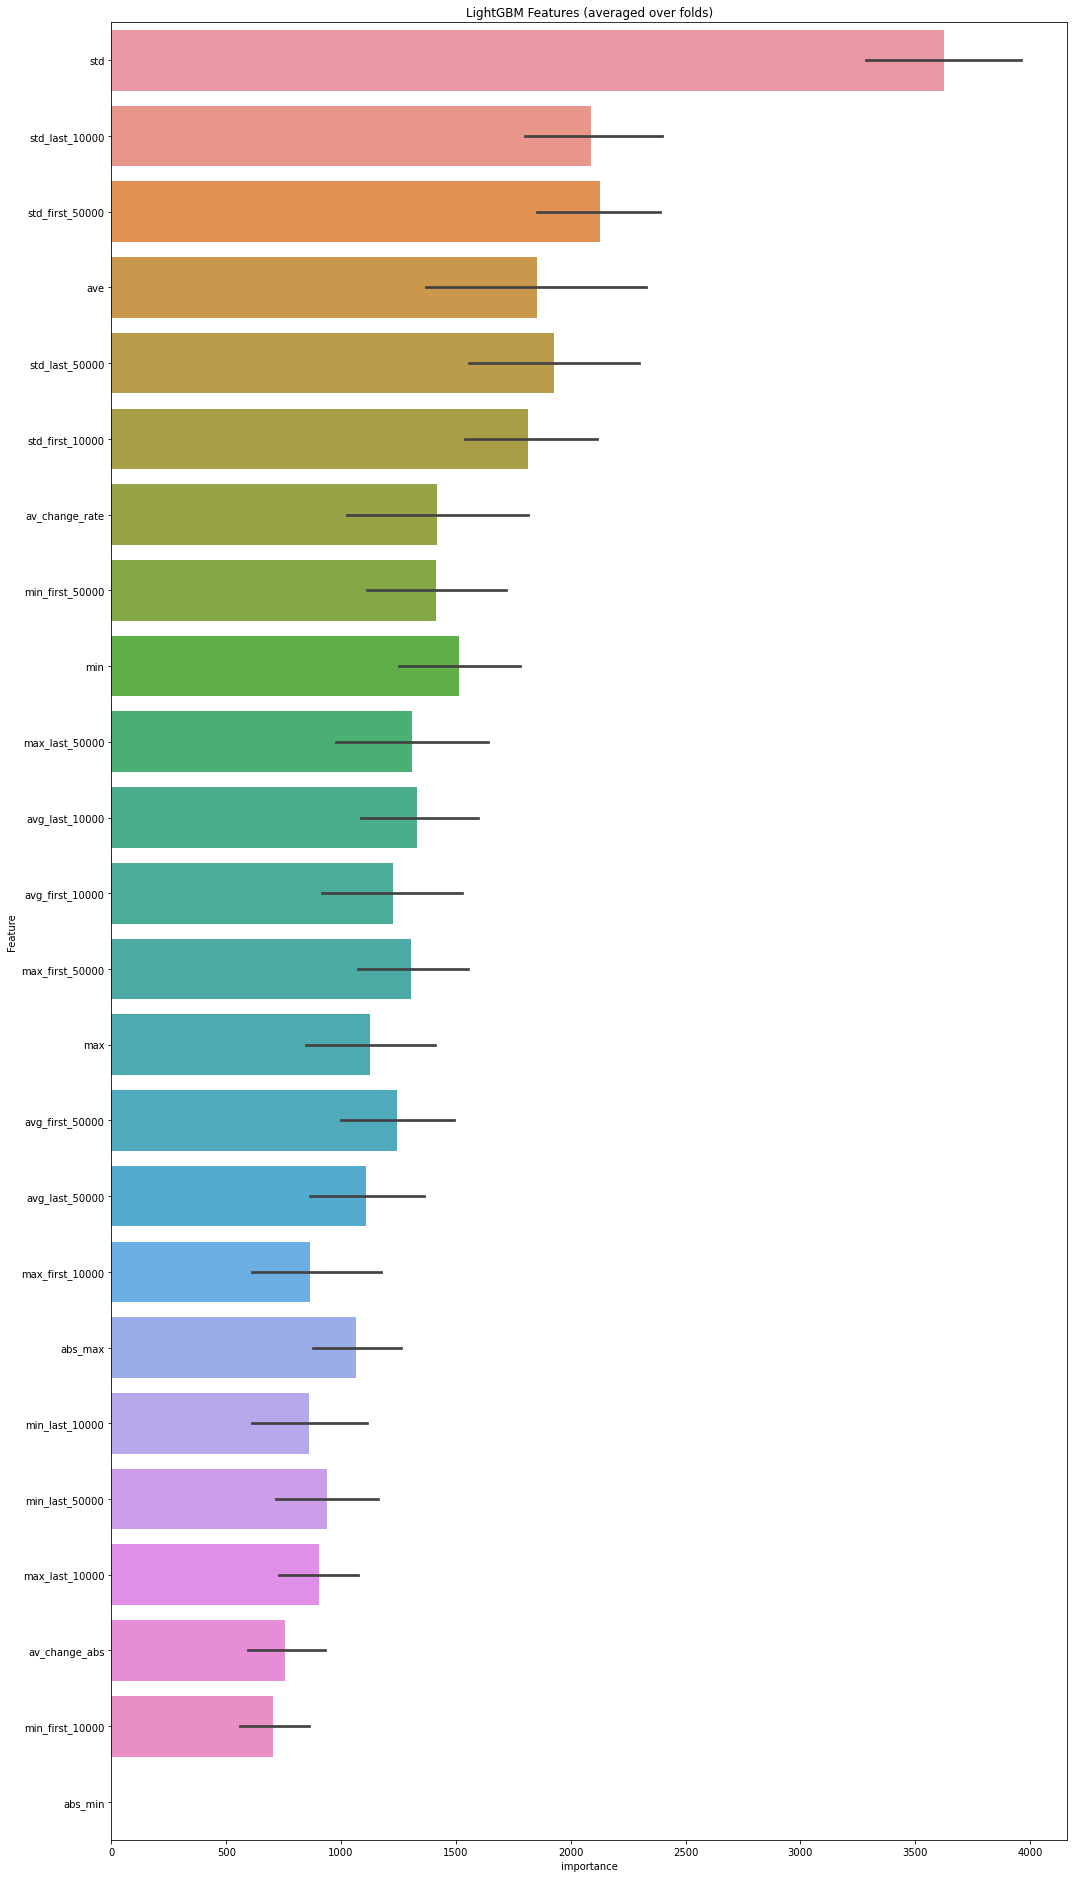

In [32]:
cols = (feature_importance_lgb_1[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", 
                     ascending=False)[:200].index)
best_features = feature_importance_lgb_1.loc[feature_importance_lgb_1.Feature.isin(cols)]

plt.figure(figsize=(14,26))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
sns.barplot(x="importance", 
            y="Feature", 
            data=best_features.sort_values(by="importance",
                                           ascending=False))

In [33]:
prediction_lgb_1[:5]

array([4.44743891, 5.78989824, 4.87367697, 7.91793406, 5.43916123])

In [34]:
score = mean_absolute_error(submission, prediction_lgb_1)
print(f'MAE score: {score:0.4f}')

MAE score: 5.5896


In [35]:
params_2 = {'num_leaves': 51,
            'min_data_in_leaf': 10, 
            'objective':'regression',
            'max_depth': -1,
            'learning_rate': 0.001,
            "boosting": "gbdt",
            "feature_fraction": 0.91,
            "bagging_freq": 1,
            "bagging_fraction": 0.91,
            "bagging_seed": 42,
            "metric": 'mae',
            "lambda_l1": 0.1,
            "verbosity": -1,
            "nthread": -1,
            "random_state": 42}

In [36]:
oof_lgb_2 = np.zeros(len(scaled_train_X))
prediction_lgb_2 = np.zeros(len(scaled_test_X))
feature_importance_lgb_2 = pd.DataFrame()

In [37]:
%%time
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    print('---------------')
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params_2, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof_lgb_2[val_idx] = model.predict(X_val, 
                                       num_iteration=model.best_iteration_)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_lgb_2 = pd.concat([feature_importance_lgb_2, fold_importance_df], axis=0)
    
    #predictions
    prediction_lgb_2 += model.predict(scaled_test_X, 
                                      num_iteration=model.best_iteration_) / \
                        folds.n_splits
    
print('------------------------------')
print('------------------------------')

---------------
fold 0
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 2.13951	valid_1's l1: 2.43515
[2000]	training's l1: 1.80244	valid_1's l1: 2.32536
[3000]	training's l1: 1.60085	valid_1's l1: 2.30408
Early stopping, best iteration is:
[3466]	training's l1: 1.52524	valid_1's l1: 2.30314
---------------
fold 1
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 2.14396	valid_1's l1: 2.38512
[2000]	training's l1: 1.80836	valid_1's l1: 2.26351
[3000]	training's l1: 1.60834	valid_1's l1: 2.23329
[4000]	training's l1: 1.45415	valid_1's l1: 2.22906
Early stopping, best iteration is:
[3644]	training's l1: 1.50525	valid_1's l1: 2.2286
---------------
fold 2
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 2.14823	valid_1's l1: 2.43261
[2000]	training's l1: 1.81831	valid_1's l1: 2.2791
[3000]	training's l1: 1.61669	valid_1's l1: 2.2444
[4000]	training's l1: 1.46028	valid_1's l1: 2.2417
Ear

<AxesSubplot:title={'center':'LightGBM Features (averaged over folds)'}, xlabel='importance', ylabel='Feature'>

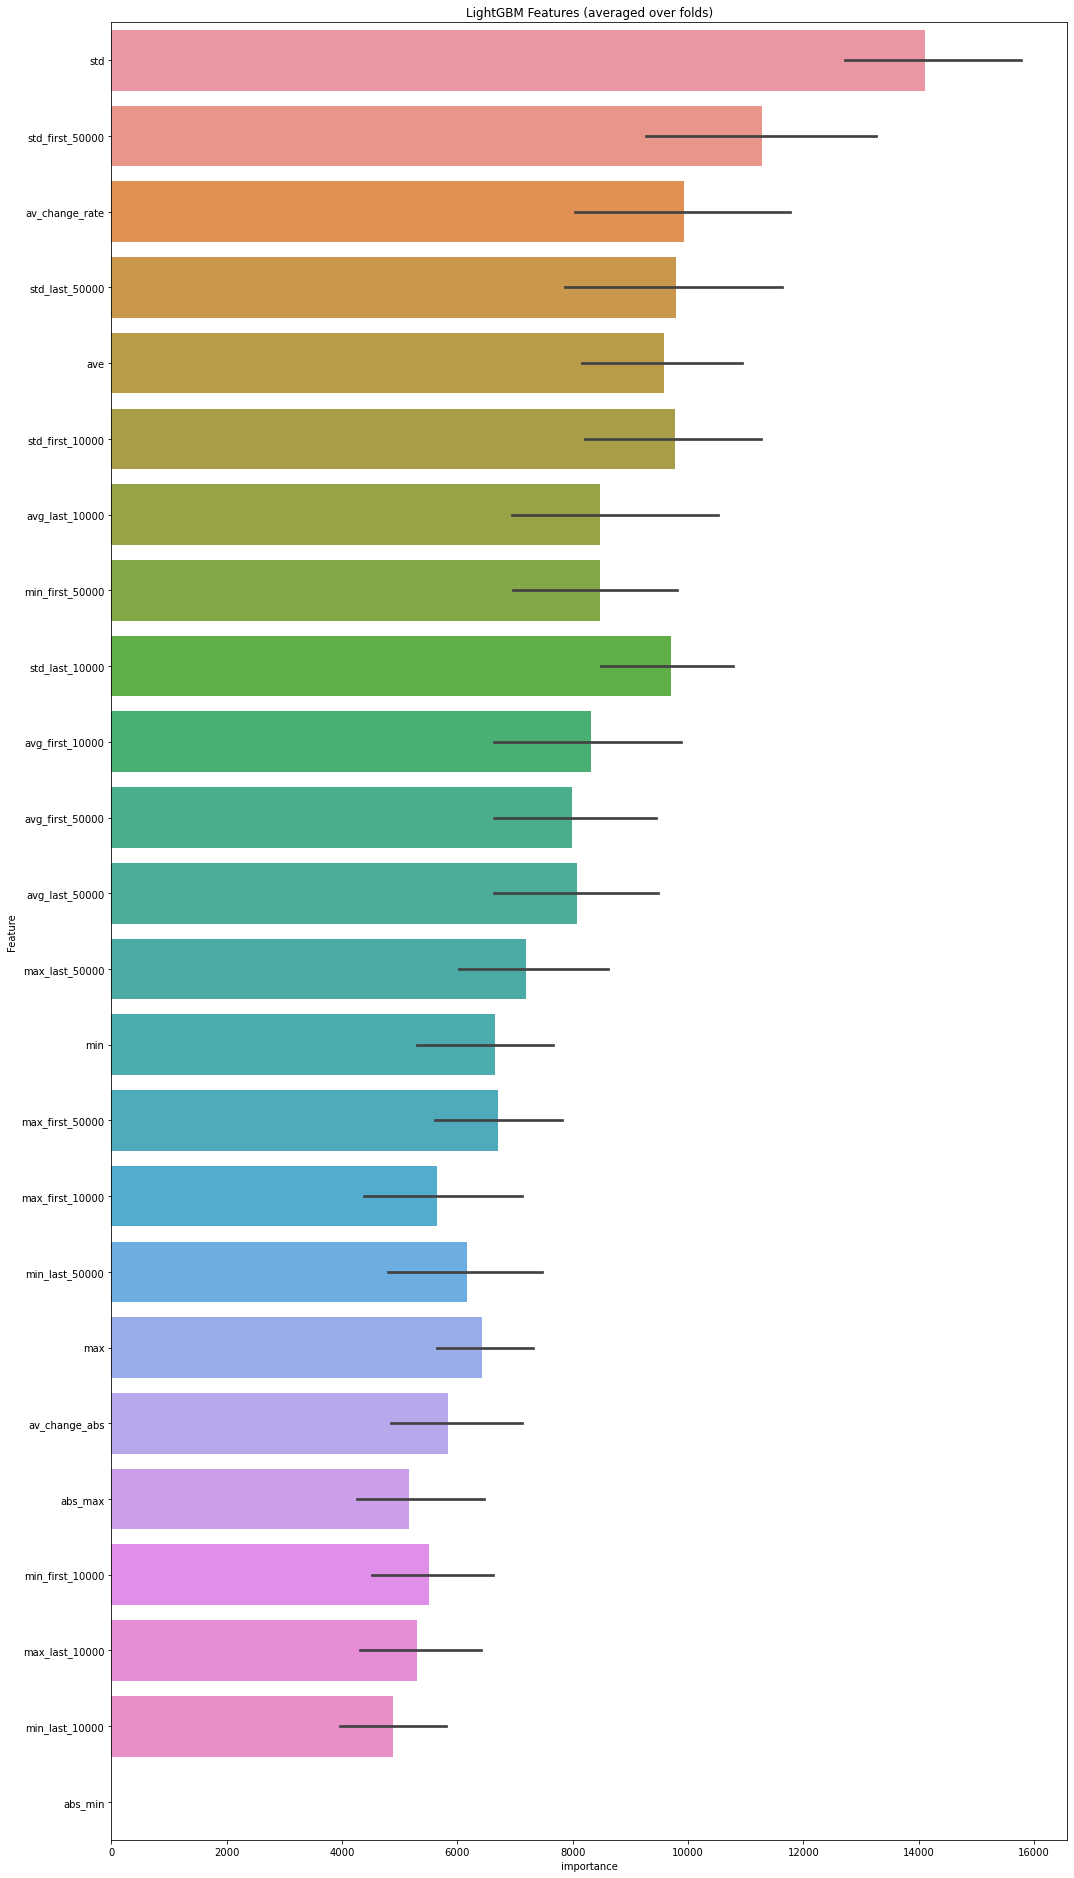

In [38]:
cols = (feature_importance_lgb_2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", 
                     ascending=False)[:200].index)
best_features = feature_importance_lgb_2.loc[feature_importance_lgb_2.Feature.isin(cols)]

plt.figure(figsize=(14,26))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
sns.barplot(x="importance", 
            y="Feature", 
            data=best_features.sort_values(by="importance",
                                           ascending=False))

In [39]:
prediction_lgb_2[:5]

array([4.7238404 , 6.1457451 , 4.66449499, 8.23542317, 5.36210737])

In [40]:
score = mean_absolute_error(submission, prediction_lgb_2)
print(f'MAE score: {score:0.4f}')

MAE score: 5.9865


В первый раз: 5.5896

---

### Model: XGBoostRegressor

In [41]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

train_columns = scaled_train_X.columns.values

In [42]:
xgb_params = {'eta': 0.03, 
              'max_depth': 10, 
              'subsample': 0.85, 
              'colsample_bytree': 0.8, 
              #'objective': 'reg:linear', 
              'eval_metric': 'mae', 
              'silent': True, 
              'nthread': 4}

In [43]:
oof_xgb = np.zeros(len(scaled_train_X))
prediction_xgb = np.zeros(len(scaled_test_X))
feature_importance_xgb = pd.DataFrame()

In [44]:
%%time
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    print('---------------')
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**xgb_params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof_xgb[val_idx] = model.predict(X_val, 
                                     num_iteration=model.best_iteration_)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_xgb = pd.concat([feature_importance_xgb, fold_importance_df], axis=0)
    
    #predictions
    prediction_xgb += model.predict(scaled_test_X, 
                                    num_iteration=model.best_iteration_) / \
                      folds.n_splits
    
print('------------------------------')
print('------------------------------')

---------------
fold 0
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[27]	training's l1: 1.87654	training's l2: 5.72208	valid_1's l1: 2.3114	valid_1's l2: 8.34738
---------------
fold 1
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[28]	training's l1: 1.86379	training's l2: 5.59779	valid_1's l1: 2.24093	valid_1's l2: 8.2755
---------------
fold 2
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[37]	training's l1: 1.78885	training's l2: 5.10859	valid_1's l1: 2.24303	valid_1's l2: 8.38943
---------------
fold 3
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[25]	training's l1: 1.92013	training's l2: 5.95171	valid_1's l1: 2.18457	valid_1's l2: 7.8145
---------------
fold 4
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[34]	training's l1: 1.8

<AxesSubplot:title={'center':'LightGBM Features (averaged over folds)'}, xlabel='importance', ylabel='Feature'>

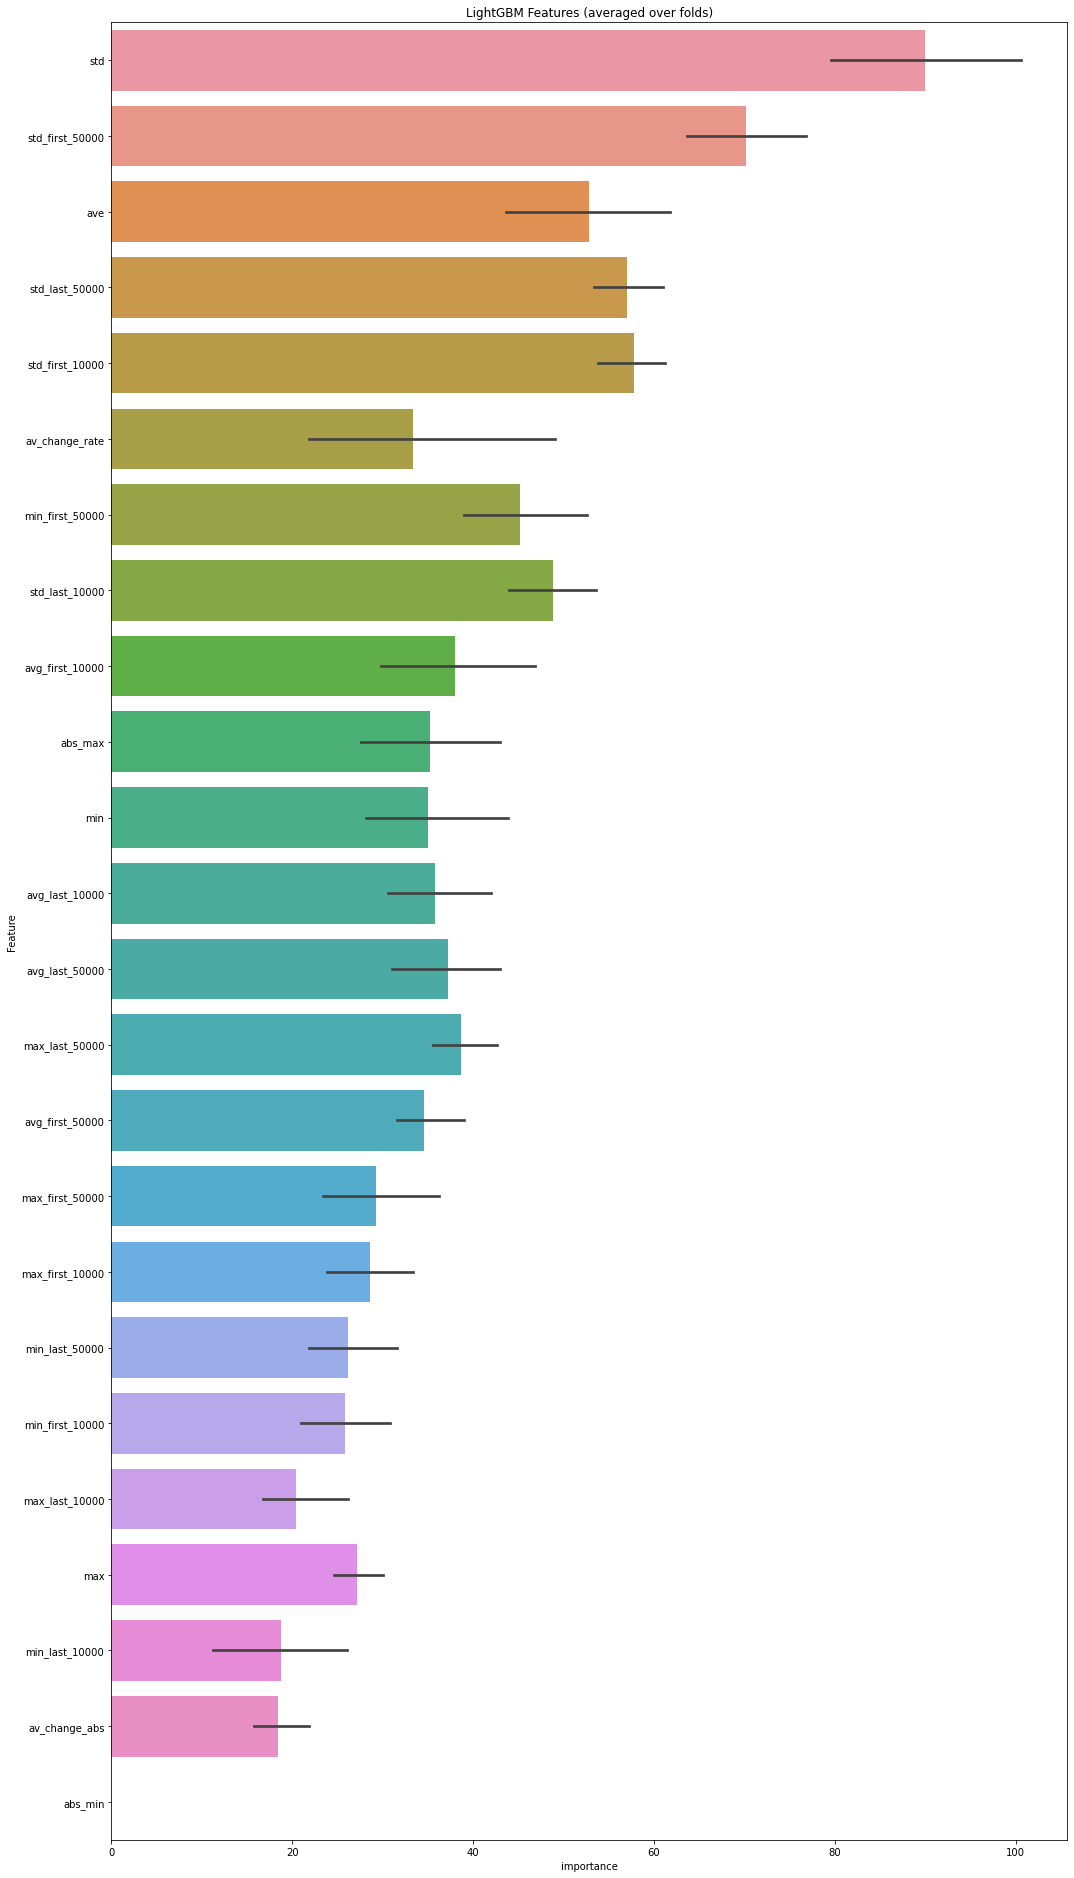

In [45]:
cols = (feature_importance_xgb[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", 
                     ascending=False)[:200].index)
best_features = feature_importance_xgb.loc[feature_importance_xgb.Feature.isin(cols)]

plt.figure(figsize=(14,26))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
sns.barplot(x="importance", 
            y="Feature", 
            data=best_features.sort_values(by="importance",
                                           ascending=False))

In [46]:
prediction_xgb[:5]

array([4.87292926, 5.82850935, 4.82686157, 8.0536109 , 5.28244498])

In [47]:
score = mean_absolute_error(submission, prediction_xgb)
print(f'MAE score: {score:0.4f}')

MAE score: 5.9495


У LGB: 5.5896

---

### Model: NuSVR

In [48]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

train_columns = scaled_train_X.columns.values

In [49]:
svr_params = {'eta': 0.03, 
              }

In [50]:
model = NuSVR(gamma='scale', nu=0.75, C=10.0)

In [51]:
oof_svr = np.zeros(len(scaled_train_X))
prediction_svr = np.zeros(len(scaled_test_X))
feature_importance_svr = pd.DataFrame()

In [52]:
%%time
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    print('---------------')
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**svr_params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof_svr[val_idx] = model.predict(X_val, 
                                     num_iteration=model.best_iteration_)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_svr = pd.concat([feature_importance_svr, fold_importance_df], axis=0)
    
    #predictions
    prediction_svr += model.predict(scaled_test_X, 
                                    num_iteration=model.best_iteration_) / \
                      folds.n_splits
    
print('------------------------------')
print('------------------------------')

---------------
fold 0
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[21]	training's l1: 1.94687	training's l2: 6.11079	valid_1's l1: 2.3496	valid_1's l2: 8.46788
---------------
fold 1
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[26]	training's l1: 1.87747	training's l2: 5.65639	valid_1's l1: 2.22812	valid_1's l2: 8.23829
---------------
fold 2
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[30]	training's l1: 1.83971	training's l2: 5.47009	valid_1's l1: 2.25004	valid_1's l2: 8.44531
---------------
fold 3
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[25]	training's l1: 1.90865	training's l2: 5.83408	valid_1's l1: 2.21141	valid_1's l2: 7.9457
---------------
fold 4
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[38]	training's l1: 1.

<AxesSubplot:title={'center':'LightGBM Features (averaged over folds)'}, xlabel='importance', ylabel='Feature'>

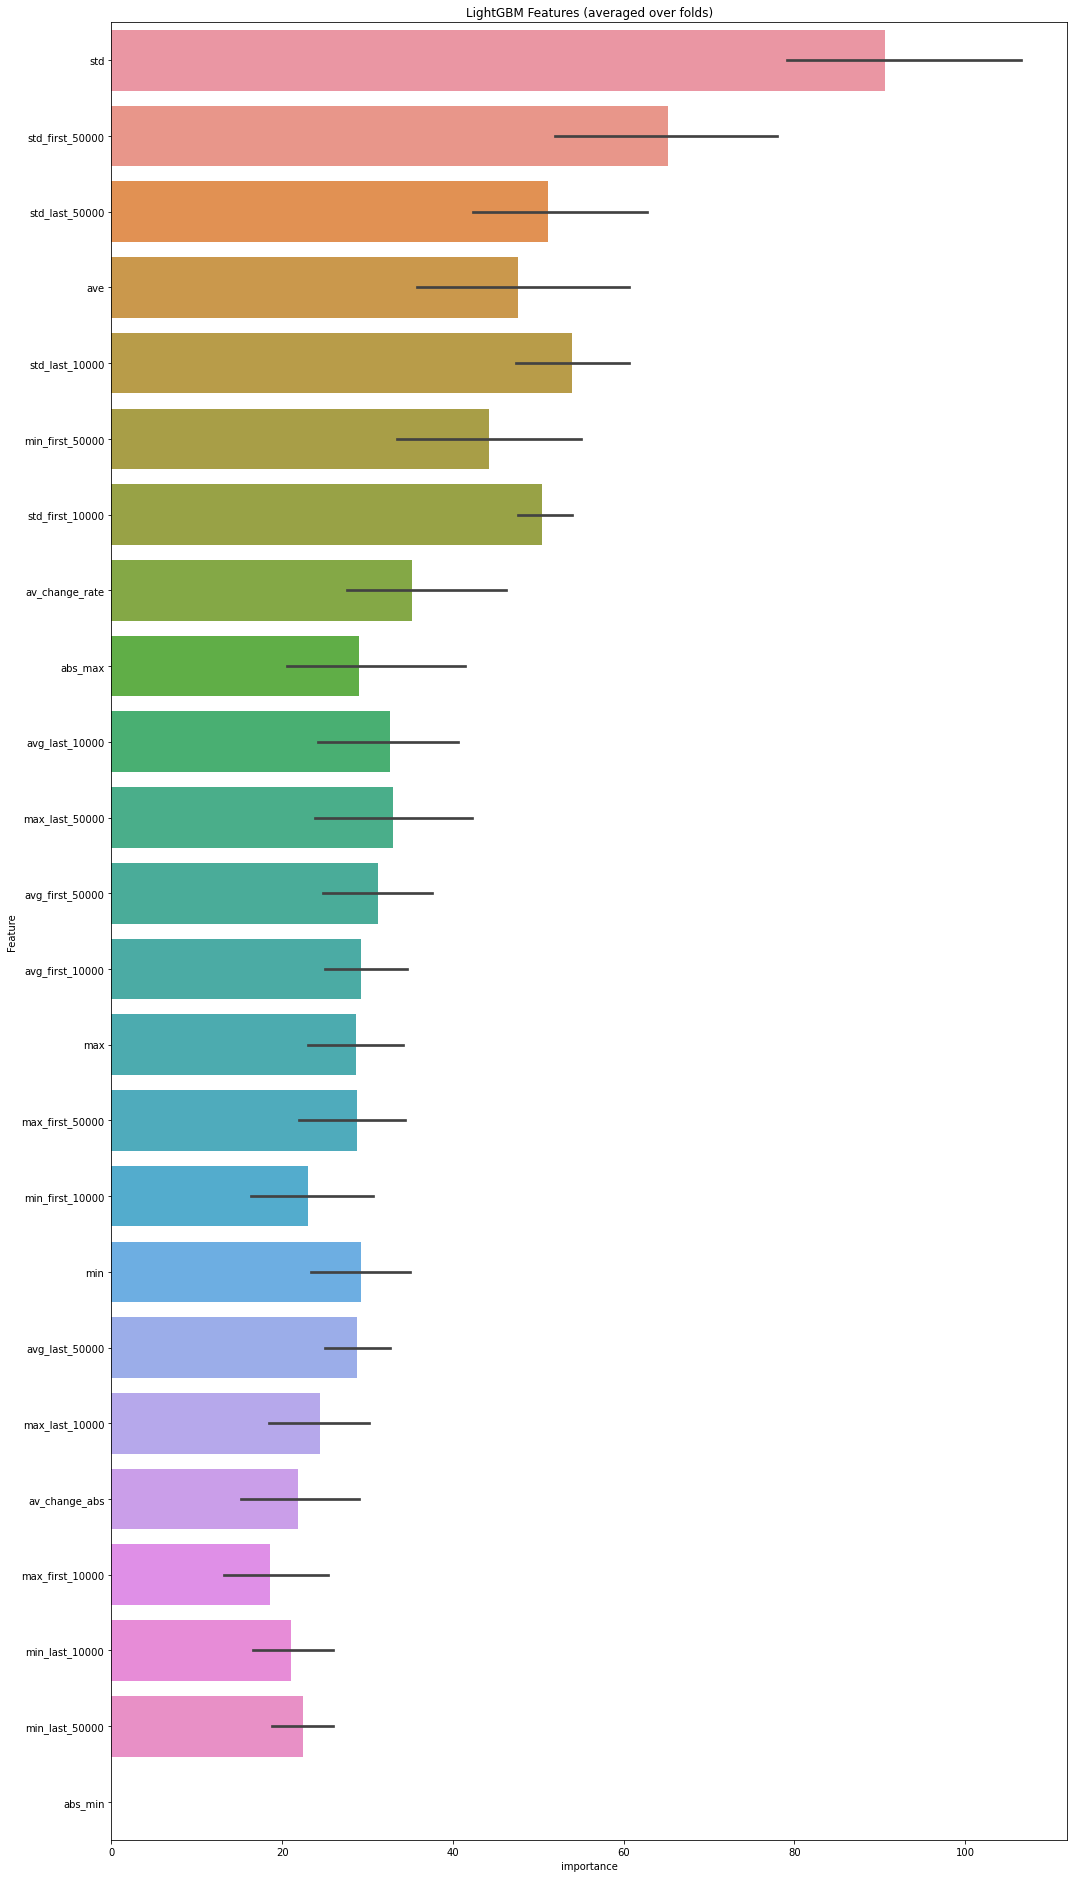

In [53]:
cols = (feature_importance_svr[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", 
                     ascending=False)[:200].index)
best_features = feature_importance_svr.loc[feature_importance_svr.Feature.isin(cols)]

plt.figure(figsize=(14,26))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
sns.barplot(x="importance", 
            y="Feature", 
            data=best_features.sort_values(by="importance",
                                           ascending=False))

In [54]:
prediction_svr[:5]

array([4.98063033, 5.88887296, 4.81689722, 7.91769488, 5.11138023])

In [55]:
score = mean_absolute_error(submission, prediction_svr)
print(f'MAE score: {score:0.4f}')

MAE score: 5.9521


У LGB: 5.5896

---

### Submission

In [ ]:
submission.time_to_failure = prediction_rfr
submission.to_csv('submission_2.1.1.csv', index=True)

submission.time_to_failure = prediction_lgb_
submission.to_csv('submission_2.1.2.csv', index=True)

submission.time_to_failure = prediction_xgb
submission.to_csv('submission_2.1.3.csv', index=True)

submission.time_to_failure = prediction_svr
submission.to_csv('submission_2.1.4.csv', index=True)

---

### Further feature generation

I create several groups of features:

* Usual aggregations: mean, std, min and max;
* Average difference between the consequitive values in absolute and percent values;
* Absolute min and max vallues;
* Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
* Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
* Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
* Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
* Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [56]:
# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

In [57]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [60]:
%%time
X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

CPU times: user 14.5 s, sys: 53 s, total: 1min 7s
Wall time: 1min 55s


In [61]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    
    return np.mean(change)

In [71]:
for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (np.convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_tr.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_tr.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_tr.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + \
                                                 no_of_std * \
                                                 X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - \
                                                no_of_std * \
                                                X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + \
                                                 no_of_std * \
                                                 X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - \
                                                no_of_std * \
                                                X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / \
                                                                                           x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / \
                                                                                            x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [72]:
print(f'{X_tr.shape[0]} samples in new train data and {X_tr.shape[1]} columns.')

4194 samples in new train data and 138 columns.


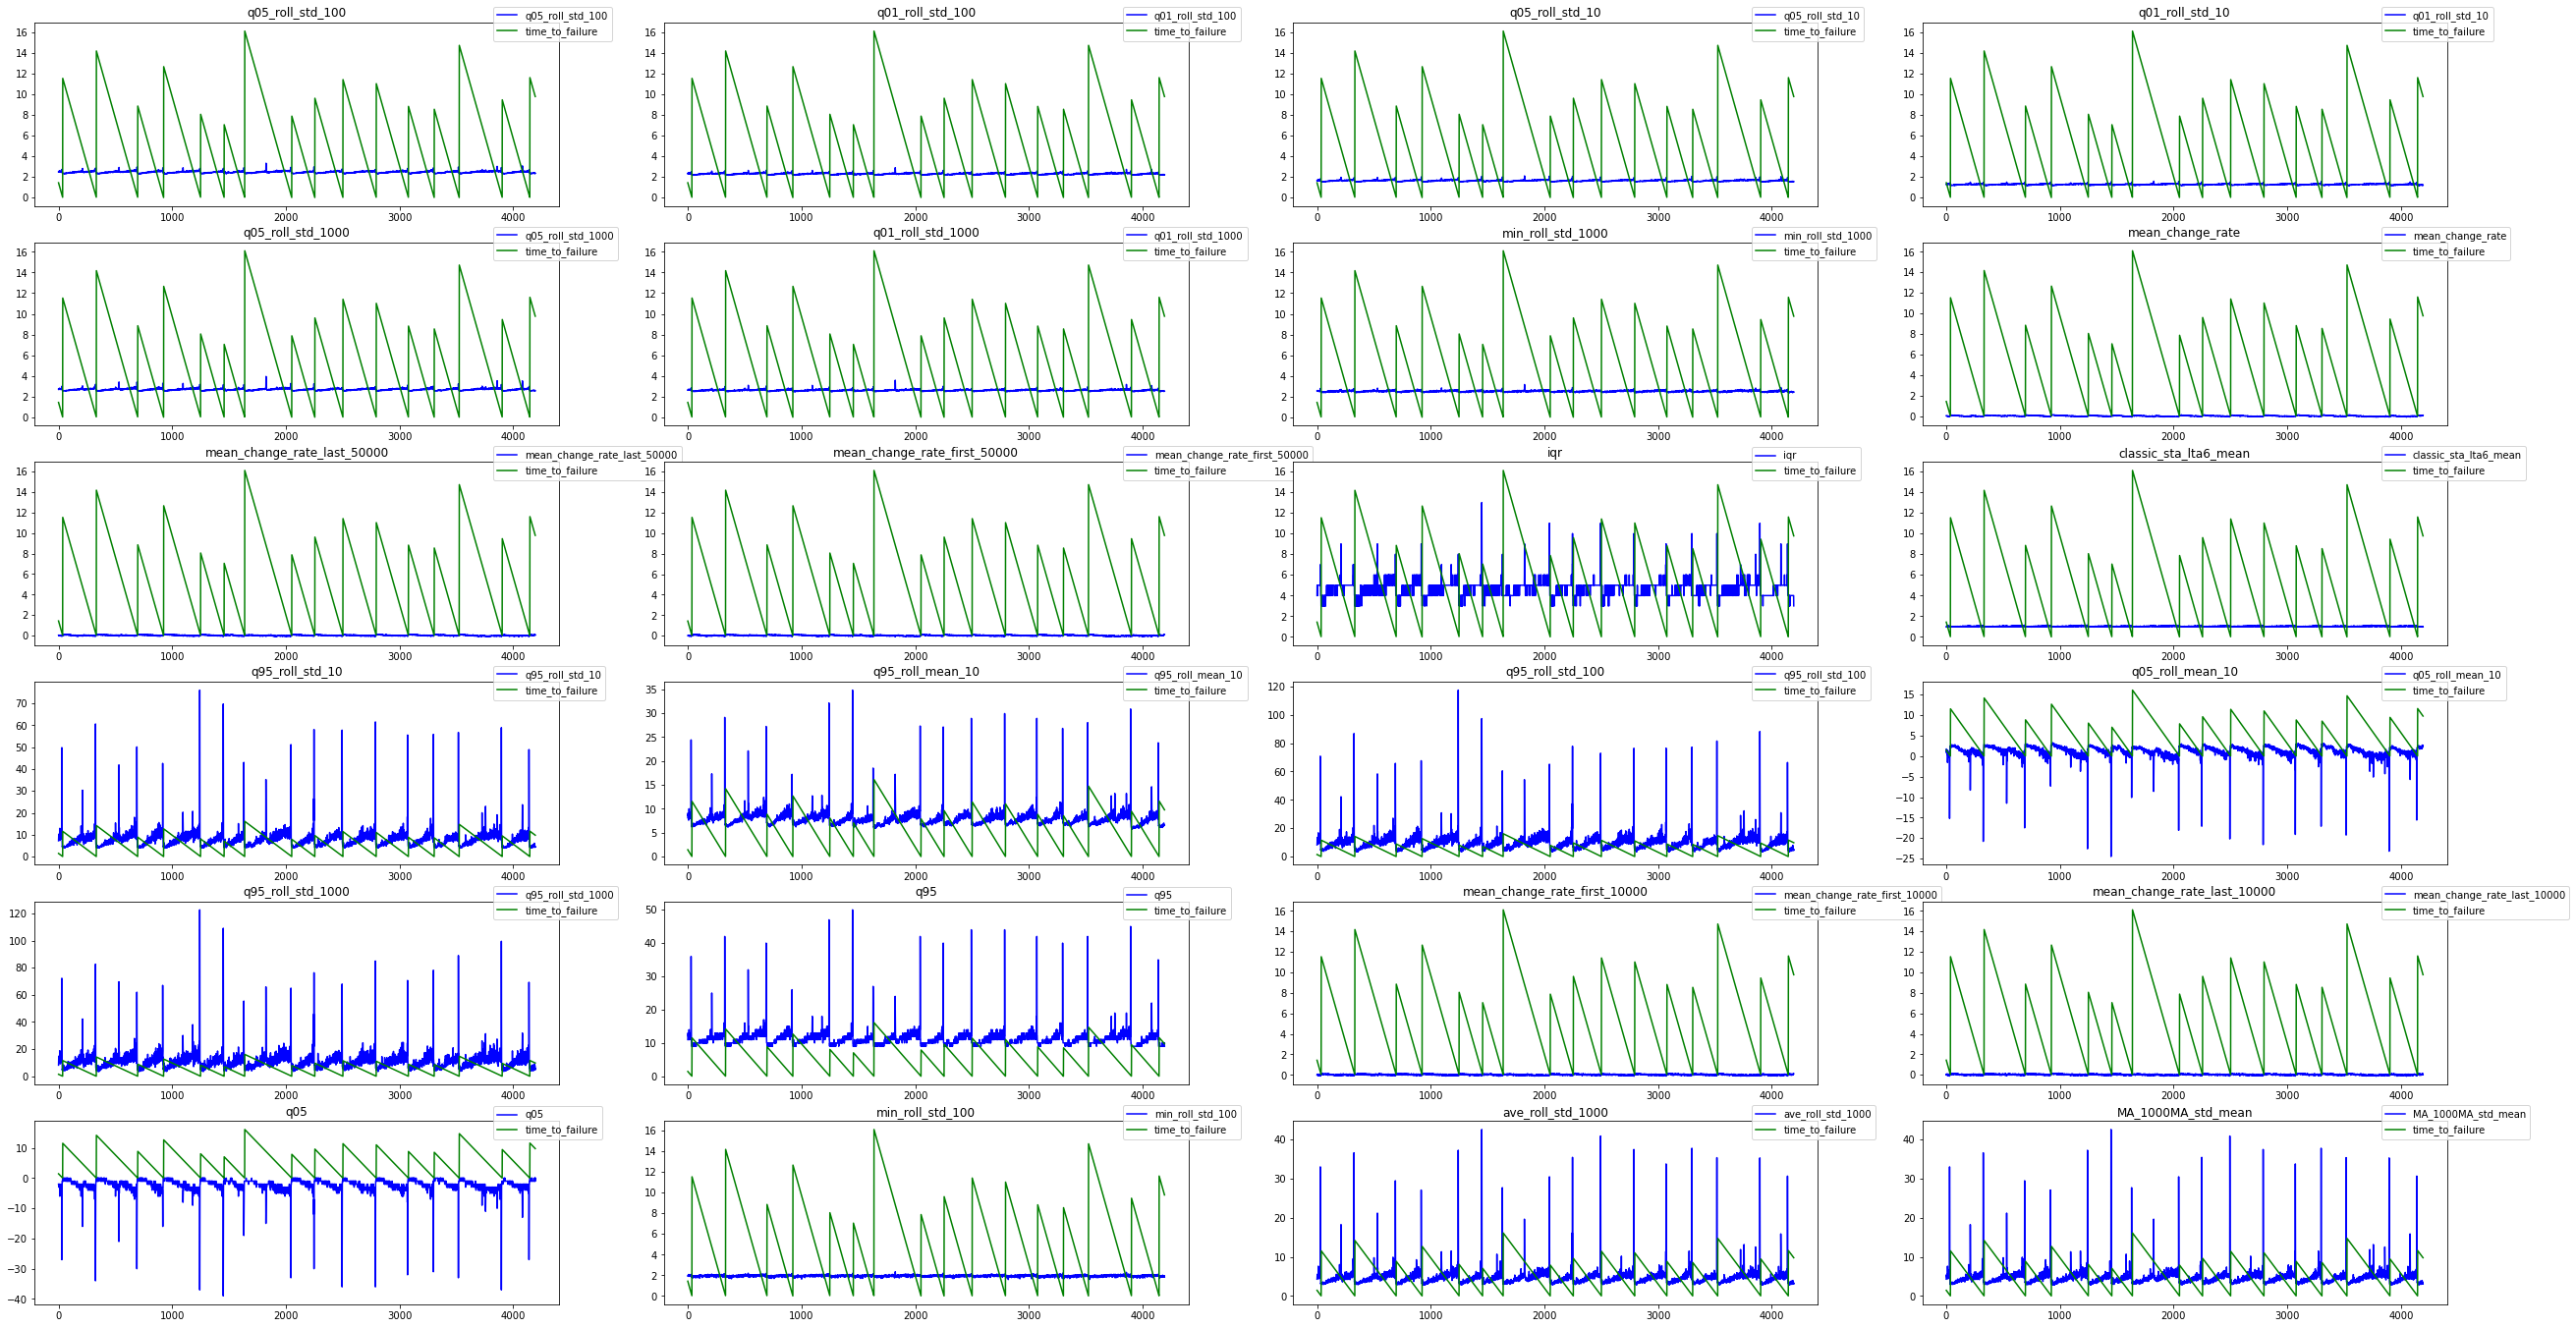

In [73]:
plt.figure(figsize=(44, 24))

cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [74]:
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

classic_sta_lta5_mean
classic_sta_lta7_mean


In [75]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

In [76]:
# Reading test data
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

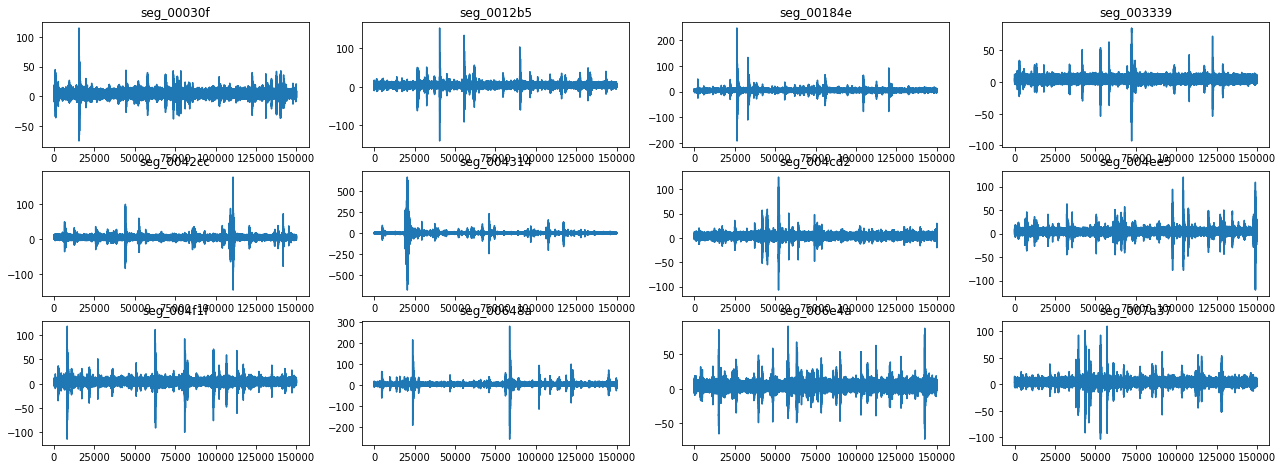

In [79]:
zip_file = zipfile.ZipFile('/Users/mathvan/Documents/anaconda/Kaggle/EarthQuakes/test.zip') 
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv(zip_file.open(seg_id + '.csv'))
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = calc_change_rate(x)
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (np.convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_test.loc[seg_id, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_test.loc[seg_id, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_test.loc[seg_id, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + \
                                                  no_of_std * \
                                                  X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - \
                                                 no_of_std * \
                                                 X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + \
                                                  no_of_std * \
                                                  X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - \
                                                 no_of_std * \
                                                 X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_test.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / \
                                                                                            x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / \
                                                                                             x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)

for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])
        
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Building models

In [80]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [81]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, 
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), 
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, 
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", 
                                                                                    ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Thu Nov 12 21:54:13 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1235]	training's l1: 1.55576	valid_1's l1: 2.05839
Fold 1 started at Thu Nov 12 21:54:24 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1310]	training's l1: 1.53935	valid_1's l1: 2.01544
Fold 2 started at Thu Nov 12 21:54:34 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1295]	training's l1: 1.52705	valid_1's l1: 2.12186
Fold 3 started at Thu Nov 12 21:54:46 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1120]	training's l1: 1.63766	valid_1's l1: 1.89778
Fold 4 started at Thu Nov 12 21:54:55 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1066]	training's l1: 1.6317	valid_1's l1: 2.06456
CV mean score: 2.0316, std: 0.0750.


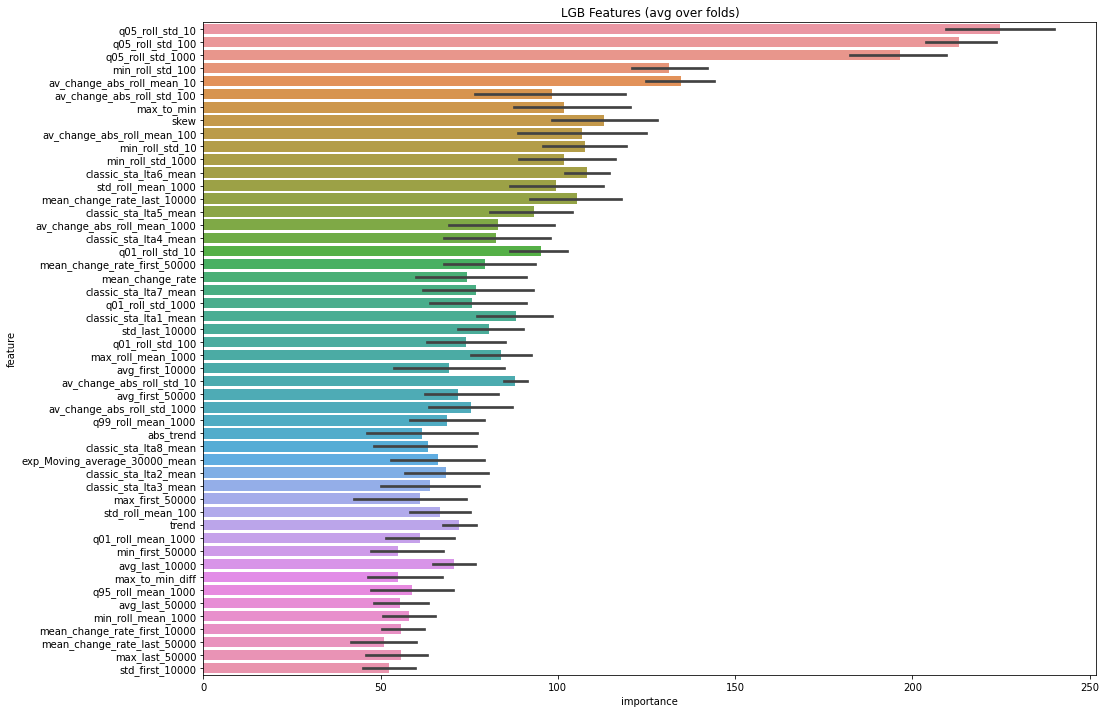

In [82]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', 
                                                          plot_feature_importance=True)

In [83]:
top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)

In [84]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params, model_type='xgb')

Fold 0 started at Thu Nov 12 21:55:07 2020
[21:55:07] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:55:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:5.03527	valid_data-mae:5.17749
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[99]	train-mae:0.82071	valid_data-mae:2.14709

[21:55:18] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
Fold 1 started at Thu Nov 12 21

In [85]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, 
                                      model_type='sklearn', model=model)

Fold 0 started at Thu Nov 12 21:56:05 2020
Fold 0. MAE: 2.1098.

Fold 1 started at Thu Nov 12 21:56:11 2020
Fold 1. MAE: 2.0933.

Fold 2 started at Thu Nov 12 21:56:16 2020
Fold 2. MAE: 2.1618.

Fold 3 started at Thu Nov 12 21:56:21 2020
Fold 3. MAE: 1.9385.

Fold 4 started at Thu Nov 12 21:56:26 2020
Fold 4. MAE: 2.1101.

CV mean score: 2.0827, std: 0.0757.


In [86]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None,
                                        model_type='sklearn', model=model)

Fold 0 started at Thu Nov 12 21:56:32 2020
Fold 0. MAE: 2.0773.

Fold 1 started at Thu Nov 12 21:56:36 2020
Fold 1. MAE: 2.0502.

Fold 2 started at Thu Nov 12 21:56:39 2020
Fold 2. MAE: 2.1337.

Fold 3 started at Thu Nov 12 21:56:43 2020
Fold 3. MAE: 1.9047.

Fold 4 started at Thu Nov 12 21:56:46 2020
Fold 4. MAE: 2.0764.

CV mean score: 2.0484, std: 0.0769.


In [87]:
params = {'loss_function':'MAE'}
oof_cat, prediction_cat = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='cat')

Fold 0 started at Thu Nov 12 21:56:50 2020
Fold 1 started at Thu Nov 12 22:02:53 2020
Fold 2 started at Thu Nov 12 22:08:43 2020
Fold 3 started at Thu Nov 12 22:14:32 2020
Fold 4 started at Thu Nov 12 22:20:19 2020
CV mean score: 2.0263, std: 0.0781.


In [90]:
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, 
                                  model_type='sklearn', model=model)

Fold 0 started at Thu Nov 12 22:33:00 2020
Fold 0. MAE: 2.1826.

Fold 1 started at Thu Nov 12 22:33:02 2020
Fold 1. MAE: 2.1693.

Fold 2 started at Thu Nov 12 22:33:03 2020
Fold 2. MAE: 2.2263.

Fold 3 started at Thu Nov 12 22:33:04 2020
Fold 3. MAE: 2.0002.

Fold 4 started at Thu Nov 12 22:33:05 2020
Fold 4. MAE: 2.2304.

CV mean score: 2.1618, std: 0.0842.


### Stacking

We can use the same function for it:

In [91]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'svr1', 'r', 'cat'])

test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_svr1, prediction_r, 
                        prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

Fold 0 started at Thu Nov 12 22:33:08 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[35]	training's l1: 1.79796	training's l2: 5.32746	valid_1's l1: 2.13136	valid_1's l2: 7.4557
Fold 1 started at Thu Nov 12 22:33:08 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's l1: 1.88859	training's l2: 5.78531	valid_1's l1: 2.07068	valid_1's l2: 7.19975
Fold 2 started at Thu Nov 12 22:33:08 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's l1: 1.86844	training's l2: 5.69974	valid_1's l1: 2.17699	valid_1's l2: 7.78135
Fold 3 started at Thu Nov 12 22:33:08 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[27]	training's l1: 1.88962	training's l2: 5.79725	valid_1's l1: 1.95367	valid_1's l2: 6.55541
Fold 4 started at Thu Nov 12 22:33:09 2020
Training until val

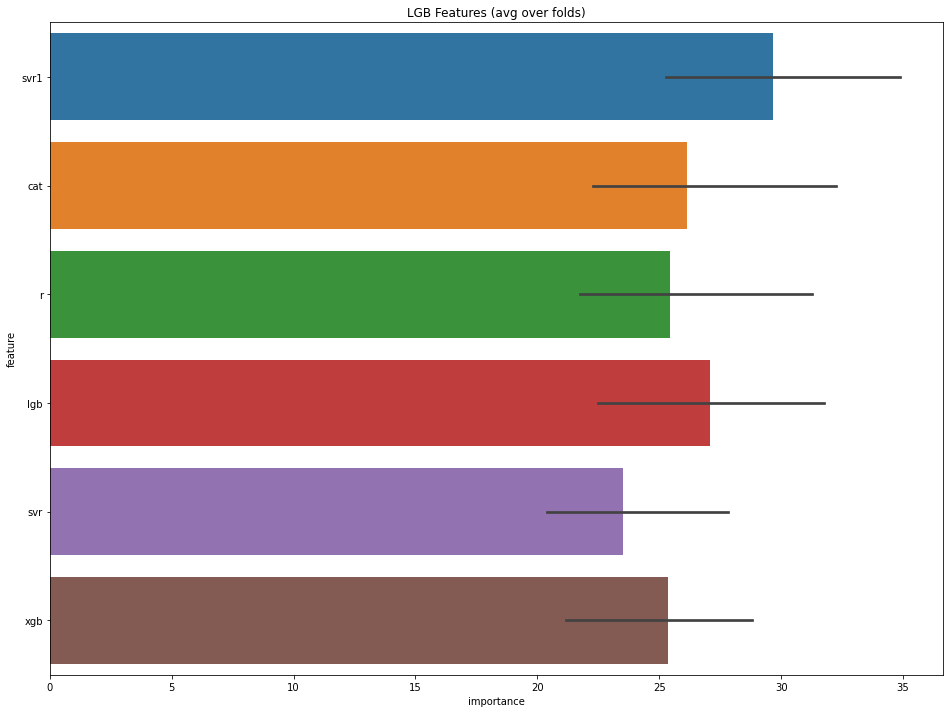

In [92]:
oof_lgb_stack, prediction_lgb_stack, feature_importance = train_model(X=train_stack, X_test=test_stack, params=params, 
                                                                      model_type='lgb', 
                                                                      plot_feature_importance=True)

Let's see how do our models perform:

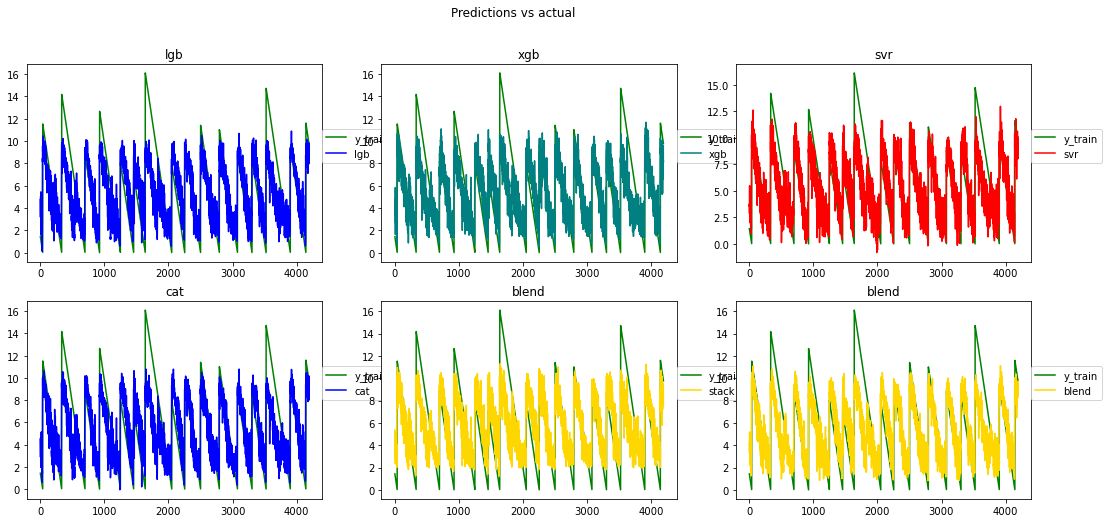

In [93]:
plt.figure(figsize=(18, 8))

plt.subplot(2, 3, 1)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');

plt.subplot(2, 3, 2)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');

plt.subplot(2, 3, 3)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_svr, color='red', label='svr')
plt.legend(loc=(1, 0.5));
plt.title('svr');

plt.subplot(2, 3, 4)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_cat, color='b', label='cat')
plt.legend(loc=(1, 0.5));
plt.title('cat');

plt.subplot(2, 3, 5)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb_stack, color='gold', label='stack')
plt.legend(loc=(1, 0.5));
plt.title('blend');
plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');

plt.subplot(2, 3, 6)
plt.plot(y_tr, color='g', label='y_train')
plt.plot((oof_lgb + oof_xgb + oof_svr + oof_svr1 + oof_r + oof_cat) / 6, color='gold', label='blend')
plt.legend(loc=(1, 0.5));
plt.title('blend');
plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');

It turned out that stacking is much worse than blending on LB.

### Submission

In [94]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr + prediction_svr1 + \
                                 prediction_cat + prediction_r) / 6
# submission['time_to_failure'] = prediction_lgb_stack
print(submission.head())

              time_to_failure
seg_id                       
seg_00030f  2.790379224169277
seg_0012b5  5.849301997855165
seg_00184e  5.310481749185050
seg_003339  8.440211932846672
seg_0042cc  6.960974656222546


In [ ]:
submission.to_csv('submission_3.csv')

---

### Even more feature generation

That high number of available features doesn't mean that using all of them at once is a good idea. Feature selection should be used to limit the number of features.

In [9]:
# Create a training file with simple derived features

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [13]:
class FeatureGenerator(object):
    def __init__(self, dtype, n_jobs=1, chunk_size=None):
        self.chunk_size = chunk_size
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        if self.dtype == 'train':
            zip_file = zipfile.ZipFile('/Users/mathvan/Documents/anaconda/Kaggle/EarthQuakes/train.csv.zip')
            self.filename = zip_file.open('train.csv')
            self.total_data = int(629145481 / self.chunk_size)
        else:
            zip_file = zipfile.ZipFile('/Users/mathvan/Documents/anaconda/Kaggle/EarthQuakes/test.zip') 
            submission = pd.read_csv('sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, zip_file.open(seg_id + '.csv')))
            self.total_data = int(len(submission))

    def read_chunks(self):
        if self.dtype == 'train':
            iter_df = pd.read_csv(self.filename, iterator=True, chunksize=self.chunk_size,
                                  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            for counter, df in enumerate(iter_df):
                x = df.acoustic_data.values
                y = df.time_to_failure.values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y
        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.chunk_size:]
                del df
                yield seg_id, x, -999
    
    def get_features(self, x, y, seg_id):
        """
        Gets three groups of features: from original data and from reald and imaginary parts of FFT.
        """
        
        x = pd.Series(x)
    
        zc = np.fft.fft(x)
        realFFT = pd.Series(np.real(zc))
        imagFFT = pd.Series(np.imag(zc))
        
        main_dict = self.features(x, y, seg_id)
        r_dict = self.features(realFFT, y, seg_id)
        i_dict = self.features(imagFFT, y, seg_id)
        
        for k, v in r_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'fftr_{k}'] = v
                
        for k, v in i_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'ffti_{k}'] = v
        
        return main_dict
        
    
    def features(self, x, y, seg_id):
        feature_dict = dict()
        feature_dict['target'] = y
        feature_dict['seg_id'] = seg_id

        # create features here

        # lists with parameters to iterate over them
        percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
        hann_windows = [50, 150, 1500, 15000]
        spans = [300, 3000, 30000, 50000]
        windows = [10, 50, 100, 500, 1000, 10000]
        borders = list(range(-4000, 4001, 1000))
        peaks = [10, 20, 50, 100]
        coefs = [1, 5, 10, 50, 100]
        lags = [10, 100, 1000, 10000]
        autocorr_lags = [5, 10, 50, 100, 500, 1000, 5000, 10000]

        # basic stats
        feature_dict['mean'] = x.mean()
        feature_dict['std'] = x.std()
        feature_dict['max'] = x.max()
        feature_dict['min'] = x.min()

        # basic stats on absolute values
        feature_dict['mean_change_abs'] = np.mean(np.diff(x))
        feature_dict['abs_max'] = np.abs(x).max()
        feature_dict['abs_mean'] = np.abs(x).mean()
        feature_dict['abs_std'] = np.abs(x).std()

        # geometric and harminic means
        feature_dict['hmean'] = stats.hmean(np.abs(x[np.nonzero(x)[0]]))
        feature_dict['gmean'] = stats.gmean(np.abs(x[np.nonzero(x)[0]])) 

        # k-statistic and moments
        for i in range(1, 5):
            feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
            feature_dict[f'moment_{i}'] = stats.moment(x, i)

        for i in [1, 2]:
            feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)

        # aggregations on various slices of data
        for agg_type, slice_length, direction in product(['std', 'min', 'max', 'mean'], [1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[:slice_length].agg(agg_type)
            elif direction == 'last':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[-slice_length:].agg(agg_type)

        feature_dict['max_to_min'] = x.max() / np.abs(x.min())
        feature_dict['max_to_min_diff'] = x.max() - np.abs(x.min())
        feature_dict['count_big'] = len(x[np.abs(x) > 500])
        feature_dict['sum'] = x.sum()

        feature_dict['mean_change_rate'] = calc_change_rate(x)
        # calc_change_rate on slices of data
        for slice_length, direction in product([1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])

        # percentiles on original and absolute values
        for p in percentiles:
            feature_dict[f'percentile_{p}'] = np.percentile(x, p)
            feature_dict[f'abs_percentile_{p}'] = np.percentile(np.abs(x), p)

        feature_dict['trend'] = add_trend_feature(x)
        feature_dict['abs_trend'] = add_trend_feature(x, abs_values=True)

        feature_dict['mad'] = x.mad()
        feature_dict['kurt'] = x.kurtosis()
        feature_dict['skew'] = x.skew()
        feature_dict['med'] = x.median()

        feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()

        for hw in hann_windows:
            feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()

        feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()

        # exponential rolling statistics
        ewma = pd.Series.ewm
        for s in spans:
            feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x, span=s).mean(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x, span=s).mean(skipna=True)).std(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x, span=s).std(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x, span=s).std(skipna=True)).std(skipna=True)

        feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
        feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
        feature_dict['ave10'] = stats.trim_mean(x, 0.1)
        
        for slice_length, threshold in product([50000, 100000, 150000],
                                                     [5, 10, 20, 50, 100]):
            feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
            feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()

        # tfresh features take too long to calculate, so I comment them for now

#         feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
#         feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
#         feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
#         feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
#         feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
#         feature_dict['mean_change'] = feature_calculators.mean_change(x)
#         feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
        feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
        feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

        for i, j in zip(borders, borders[1:]):
            feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)

#         feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
#         feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
#         feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
#         feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
#         feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)

#         for lag in lags:
#             feature_dict[f'time_rev_asym_stat_{lag}'] = feature_calculators.time_reversal_asymmetry_statistic(x, lag)
        for autocorr_lag in autocorr_lags:
            feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
            feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

#         for coeff, attr in product([1, 2, 3, 4, 5], ['real', 'imag', 'angle']):
#             feature_dict[f'fft_{coeff}_{attr}'] = list(feature_calculators.fft_coefficient(x, [{'coeff': coeff, 'attr': attr}]))[0][1]

#         feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
#         feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
#         feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
#         feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)

        for p in percentiles:
            feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

        feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)

        for peak in peaks:
            feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)

        for c in coefs:
            feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
            feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  

        # statistics on rolling windows of various sizes
        for w in windows:
            x_roll_std = x.rolling(w).std().dropna().values
            x_roll_mean = x.rolling(w).mean().dropna().values

            feature_dict[f'ave_roll_std_{w}'] = x_roll_std.mean()
            feature_dict[f'std_roll_std_{w}'] = x_roll_std.std()
            feature_dict[f'max_roll_std_{w}'] = x_roll_std.max()
            feature_dict[f'min_roll_std_{w}'] = x_roll_std.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_std_{p}_window_{w}'] = np.percentile(x_roll_std, p)

            feature_dict[f'av_change_abs_roll_std_{w}'] = np.mean(np.diff(x_roll_std))
            feature_dict[f'av_change_rate_roll_std_{w}'] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            feature_dict[f'abs_max_roll_std_{w}'] = np.abs(x_roll_std).max()

            feature_dict[f'ave_roll_mean_{w}'] = x_roll_mean.mean()
            feature_dict[f'std_roll_mean_{w}'] = x_roll_mean.std()
            feature_dict[f'max_roll_mean_{w}'] = x_roll_mean.max()
            feature_dict[f'min_roll_mean_{w}'] = x_roll_mean.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_mean_{p}_window_{w}'] = np.percentile(x_roll_mean, p)

            feature_dict[f'av_change_abs_roll_mean_{w}'] = np.mean(np.diff(x_roll_mean))
            feature_dict[f'av_change_rate_roll_mean_{w}'] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            feature_dict[f'abs_max_roll_mean_{w}'] = np.abs(x_roll_mean).max()       

        return feature_dict

    def generate(self):
        feature_list = []
        res = Parallel(n_jobs=self.n_jobs,
                       backend='threading')(delayed(self.get_features)(x, y, s)
                                            for s, x, y in tqdm_notebook(self.read_chunks(), total=self.total_data))
        for r in res:
            feature_list.append(r)
        return pd.DataFrame(feature_list)

I calculate statistics on original values and on real and imaginary parts of FFT:

In [14]:
training_fg = FeatureGenerator(dtype='train', n_jobs=20, chunk_size=150000)
training_data = training_fg.generate()

ValueError: Length of passed values is 1, index implies 150000.

In [5]:
test_fg = FeatureGenerator(dtype='test', n_jobs=20, chunk_size=150000)
test_data = test_fg.generate()

FileNotFoundError: [Errno 2] No such file or directory: '../input/sample_submission.csv'

In [ ]:
X = training_data.drop(['target', 'seg_id'], axis=1)
X_test = test_data.drop(['target', 'seg_id'], axis=1)
test_segs = test_data.seg_id
y = training_data.target